# Quantum Computing Experimentation with Amazon Braket
### Chapter 11 - Single Objective Optimization Use Case

© 2021, 2022, 2023 Packt Publishing

Written by Alex Khan

In [1]:
# Enter the S3 bucket you created during onboarding in the code below
my_bucket = "amazon-braket-[your bucket]" # the name of the bucket
my_prefix = "[your folder]" # the name of the folder in the bucket
s3_folder = (my_bucket, my_prefix)

In [2]:
from braket.circuits import Circuit, Gate, Observable
from braket.devices import LocalSimulator
from braket.aws import AwsDevice, AwsQuantumTask
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

In [3]:
import numpy as np

In [4]:
from scipy.optimize import minimize, curve_fit


In [5]:
# to check all gate operations refer to 
# https://docs.aws.amazon.com/braket/latest/developerguide/braket-constructing-circuit.html

https://docs.aws.amazon.com/braket/latest/developerguide/braket-constructing-circuit.html

In [6]:
def available_devices():
    from braket.aws import AwsDevice
    device_list=AwsDevice.get_devices(statuses=['ONLINE'])
    device_name_list=[]
    for device in device_list:
        device_name_list.append(device.name)
    #print('Valid device names: ',device_name_list)
    return(device_name_list)

In [7]:
available_devices()

['Aquila', 'Aspen-M-2', 'Borealis', 'IonQ Device', 'Lucy', 'SV1', 'TN1', 'dm1']

In [8]:
def set_device(Name):
    device_list=AwsDevice.get_devices(names=Name)
    if len(device_list)==1:
        device=device_list[0]
        print(device)
        return(device)
    else:
        print('No device found')
        print('use name from list', available_devices())

In [68]:
### Please run available_devices() and correct any device names below

def estimate_cost(device,num_shots=1000):
    #device=set_device(Name)
    cost_per_task=0.30
    Name=device.name
    if Name in ['SV1','TN1','dm1']:
        price_per_min=device.properties.service.deviceCost.price
        unit=device.properties.service.deviceCost.unit
        print('simulator cost per ',unit,': $', price_per_min)
        print('total cost cannot be estimated')
    elif Name in['Aspen-M-3','IonQ Device','Lucy','Aquila']:
        price_per_shot=device.properties.service.deviceCost.price
        unit=device.properties.service.deviceCost.unit
        print('device cost per ',unit,': $', price_per_shot)
        print('total cost for {} shots is ${:.2f}'.format(num_shots,cost_per_task+num_shots*price_per_shot))
    else:
        print('device not found')
        print('use name from list', available_devices())


In [10]:
# This function was modified with a return of num_shots
def estimate_cost_measured_qubits(device,measured_qubits):
    #device=set_device(Name)
    min_shots_per_variable=25
    max_shots=device.properties.service.shotsRange[1]
    print('max shots:', max_shots)
    num_shots=min_shots_per_variable*2**measured_qubits
    if num_shots>max_shots:
        num_shots=max_shots
        print('for {} measured qubits the maximum allowed shots: {:,}'.format(measured_qubits,num_shots))
    else:
        print('for {} measured qubits the number of shots recommended: {:,}'.format(measured_qubits,num_shots))
    estimate_cost(device,num_shots)
    return(num_shots)

In [11]:
def actual_simulator_cost(device, result):
        price_per_min=device.properties.service.deviceCost.price
        price_per_ms=price_per_min/60/1000
        unit=device.properties.service.deviceCost.unit
        duration_ms=result.additional_metadata.simulatorMetadata.executionDuration
        if unit=='minute':
            print('simulator cost per ',unit,': $', price_per_min)
            print('total execution time: ', duration_ms, "ms")
            print('total cost estimated: $',duration_ms*price_per_ms)

In [12]:
# this function has been updated from the function in past chapters
def run_circuit(circuit, shots, local=True, device_name='', s3_folder='', display_binary=False, disable_qubit_rewiring=False):
    import matplotlib.pyplot as plt
    %matplotlib inline
    if local==True:
        device = LocalSimulator()
        result = device.run(circuit, shots=shots).result()
    else:
        device=set_device(device_name)
        if shots==0:
            measured_qubits=len(circuit.qubits)
            num_reads=estimate_cost_measured_qubits(device,measured_qubits)
        else:
            num_reads=shots
        print('device', device)
        print('num reads', num_reads)
        if device_name=='Aspen-M-3':
            result = device.run(circuit, shots=num_reads, s3_destination_folder=s3_folder, disable_qubit_rewiring=disable_qubit_rewiring).result()
        else:
            result = device.run(circuit, shots=num_reads, s3_destination_folder=s3_folder).result()
        if device_name in (['SV1','TN1']):
            actual_simulator_cost(device, result)
        else:
            estimate_cost(device, num_reads)
    counts = result.measurement_counts
    if display_binary==True:
        print(counts)
        plt.bar(int(counts.keys(),2), counts.values());
        plt.xlabel('states');
        plt.ylabel('counts');
    else:
        x_val=[]
        y_val=[]
        dec_counts={}
        for i in (counts.keys()):
            x_val.append(int(i,2))
        for i in (counts.values()):
            y_val.append(i)
        for i in range(len(x_val)):
            dec_counts[x_val[i]]=y_val[i]
        print(dec_counts)
        plt.bar(x_val, y_val)

        plt.xlabel('states');
        plt.ylabel('counts');
    
    return(result)

In [13]:
def draw_bloch(q, info=True):
    #©2021-2 Alex Khan
    
    import matplotlib.pyplot as plt
    import numpy as np

    if q.shape != (2,1):
        print('Matrix must be only for one qubit')
        print('Shape needed (2,1). Shape given ',q.shape)
        return
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_aspect("auto")
    if info==True:
        print('Matrix:')
        print(q)
    # draw Bloch Sphere
    u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:50j]
    x = np.cos(u)*np.sin(v)
    y = np.sin(u)*np.sin(v)
    z = np.cos(v)
    ax.plot_surface(x, y, z, color="y", alpha=0.2)

    u = np.linspace(0, 2* np.pi, 100)

    ax.plot(np.sin(u),np.cos(u),0*(u),color='y')
    ax.plot(0*(u),np.sin(u),np.cos(u),color='y')
    ax.plot(np.sin(u),0*(u),np.cos(u),color='y')

    # draw axes
    ax.plot([0,0],[1,-1],[0,0], color='y', linestyle='dotted')
    ax.plot([1,-1],[0,0],[0,0], color='y', linestyle='dotted')
    ax.plot([0,0],[0,0],[1,-1], color='y', linestyle='dotted')

    # draw state labels
    ax.annotate("|0>", xy=(0.0, 0.04), xytext=(0.0, 0.07), arrowprops=dict(arrowstyle="->"), color='y')
    ax.annotate("|1>", xy=(0.0, -0.04), xytext=(0.0, -0.07), arrowprops=dict(arrowstyle="->"), color='y')
    ax.annotate("|+>", xy=(-0.025, -0.022), xytext=(-0.06, -0.04), arrowprops=dict(arrowstyle="->"), color='y')

    # calculate vector
    
    r0=((q[0].real)**2+(q[0].imag)**2)**0.5
    #print('r0=',r0)
    if r0==0:
        phi0=0
    else:
    
        phi0=np.arccos(q[0].real/r0)
    
    r1=((q[1].real)**2+(q[1].imag)**2)**0.5
    #print('r1=',r1)
    if r1==0:
        phi1=0
    else:
    
        phi1=np.arccos(q[1].real/r1)
    r=(r0**2+r1**2)**0.5
    
    if(r<0.999 or r>1.0001):
        print('vector is  not normalized.  Cannot draw')
        return
    
    if np.sin(q[1].imag)<0:
        s1=-1
    else:
        s1=+1#

    if np.sin(q[0].imag)<0:
        s0=-1
    else:
        s0=+1
    

    #print('phi1',phi1,'phi0', phi0)
    phi=s1*phi1-s0*phi0   


    theta=2*np.arccos((q[0].real**2+q[0].imag**2)**0.5)
    
    v_x = np.cos(phi)*np.sin(theta)
    v_y = np.sin(phi)*np.sin(theta)


    v_z = np.cos(theta)
    v_z2= np.sin(theta)
    #print('theta',theta, 'phi',phi)

    #print('vx=cos(phi)',np.cos(phi), 'x sin(theta)', np.sin(theta),'= ',v_x)
    #print('vy=sin(phi)',np.sin(phi), 'x sin(theta)', np.sin(theta),'= ',v_y )
    #print('vz=cos(theta)', v_z)
    
    # print state
    if info==True:
        print(' ')
        print('State Vector: |psi> = sqrt(', q[0].real**2+q[0].imag**2, ') |0> + ( sqrt(', q[1].real**2+q[1].imag**2,')) e^i', phi/np.pi,'pi |1>')
        print(' ')
    # draw vector
    ax.quiver(0,0,0,v_y, -v_x, v_z, color='r')
    #print('cartesian coordinates on Bloch Sphere')
    #print(v_x, v_y, v_z)
    plt.axis('off')
    fig.set_size_inches(7, 7)
    #ax.view_init(10, 10, 10)
    #print('Bloch Sphere:')
    plt.show()
    return(q)

In [14]:
def draw_circuit(circ, info=True):
    # this function is only for one qubit and draws the Bloch sphere
    circ=circ.state_vector()
    if info==True:
        print(circ)
    device = LocalSimulator()
    result = device.run(circ).result()
    arr_r=np.array([[result.values[0][0]],[result.values[0][1]]])
    draw_bloch(arr_r, info)

In [15]:
def qft_gate(qc,qubits_needed):
    
    power=0

    for target in range(qubits_needed-1,-1,-1):
        qc.h(target)
        for control in range(target-1,-1,-1):
 
            power=target-control

            qc.cphaseshift(control, target, (np.pi/(2**(power))))


    #reverse qubits

    #for i in range (int(qubits_needed/2)):
        
        #qc.swap(i,qubits_needed-i-1)
    return(qc)

In [16]:
def qft_inv_gate(qc, qubits_needed, q_start=0):
    
    power=0

    for target in range(0,qubits_needed):
        
        for control in range(0,target):

            power=target-control

            qc.cphaseshift(control+q_start, target+q_start, -(np.pi/(2**(power))))
        
        qc.h(target+q_start)
    
    for i in range (int(qubits_needed/2)-1,-1,-1):
        
        qc.swap(i+q_start,qubits_needed-i-1+q_start)

    return(qc)

In [17]:
def draw_multi_qubit_phase(Qubits, Number, add_hadamard=True):

    b_Number=format(Number, '0'+str(Qubits)+'b')

    print('Qubits:', Qubits, 'Number:', Number, 'binary:', b_Number)
    # qc builds the full circuit 
    # circ is only a qubit by qubit model for showing the bloch sphere
    qc=Circuit()
    for q in range(Qubits):
        print('qubit',q)
        circ=Circuit().h(0)
        
        if add_hadamard==True:
            qc=qc.h(q)
        p=0
        for i in range(Qubits-q-1,Qubits):

            if b_Number[i]=='1':
                circ.phaseshift(0,np.pi/(2**p))
                qc.phaseshift(q,np.pi/(2**p))

            p+=1
        # draw the bloch sphere for each qubit
        draw_circuit(circ, False) 
    return(qc)
        
        
    

In [18]:
def qc_num(num, qubits_needed):
    qubits_format='0'+str(qubits_needed)+'b'
    n_bin=format(num, qubits_format)

    qubits_needed=len(n_bin)

    qc=Circuit()
    for i in range(qubits_needed):
        if n_bin[i]=='1':
            #reverse number
            #qc.x(qubits_needed-i-1)
            qc.x(qubits_needed-i-1)


    return(qc)

In [19]:
def add_coefficient(qc, q_start, Qubits, control_qubit, Number):
    b_Number=format(Number, '0'+str(Qubits)+'b')

    #print('Qubits:', Qubits, 'Number:', Number, 'binary:', b_Number, q_start, control_qubit)


    for q in range(Qubits):
        #print('qubit',q)

        p=0
        for k in range(Qubits-q-1,Qubits):

            if b_Number[k]=='1':

                qc.cphaseshift(control_qubit,q+q_start,np.pi/(2**p))

            p+=1

    return(qc)

In [20]:
def subtract_coefficient(qc, q_start, Qubits, control_qubit, Number):
    b_Number=format(Number, '0'+str(Qubits)+'b')

    #print('Qubits:', Qubits, 'Number:', Number, 'binary:', b_Number, q_start, control_qubit)


    for q in range(Qubits):
        #print('qubit',q)

        p=0
        for k in range(Qubits-q-1,Qubits):

            if b_Number[k]=='1':

                qc.cphaseshift(control_qubit,q+q_start,-np.pi/(2**p))

            p+=1

    return(qc)

In [21]:
def matrix_to_polynomial(objective):
    #Qubits=3    
    #objective=np.array([[2,-1],[0,3]])
    eq=''
    SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
    SUP = str.maketrans("0123456789", "⁰¹²³⁴⁵⁶⁷⁸⁹")
    len_r1=len(objective)

    #extra_qubits={}
    #r2=len_r1
    ex_qu=0

    for i in range (len_r1):
        if objective[i,i]<0:
            eq=eq+str(objective[i,i])+'x'+str(i).translate(SUB)+'2'.translate(SUP)
        elif objective[i,i]>0:
            eq=eq+'+'+str(objective[i,i])+'x'+str(i).translate(SUB)+'2'.translate(SUP)

    for i in range (len_r1):
        for j in range (len_r1):
            if i<j:

                if objective[i,j]<0:
                    #extra_qubits[(i,j)]=r2
                    #r2+=1
                    eq=eq+str(objective[i,j])+'x'+str(i).translate(SUB)+'x'+str(j).translate(SUB)
                elif objective[i,j]>0:
                    #extra_qubits[(i,j)]=r2
                    #r2+=1                
                    eq=eq+'+'+str(objective[i,j])+'x'+str(i).translate(SUB)+'x'+str(j).translate(SUB)
    print(eq)
    return(eq)

In [22]:
def multi_qubit_polynomial(Qubits, objective):
    #Qubits=3    
    #objective=np.array([[2,-1],[0,3]])
    eq=''
    SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
    SUP = str.maketrans("0123456789", "⁰¹²³⁴⁵⁶⁷⁸⁹")
    len_r1=len(objective)

    extra_qubits={}
    r2=len_r1
    ex_qu=0

    for i in range (len_r1):
        if objective[i,i]<0:
            eq=eq+str(objective[i,i])+'x'+str(i).translate(SUB)+'2'.translate(SUP)
        elif objective[i,i]>0:
            eq=eq+'+'+str(objective[i,i])+'x'+str(i).translate(SUB)+'2'.translate(SUP)

    for i in range (len_r1):
        for j in range (len_r1):
            if i<j:

                if objective[i,j]<0:
                    extra_qubits[(i,j)]=r2
                    r2+=1
                    eq=eq+str(objective[i,j])+'x'+str(i).translate(SUB)+'x'+str(j).translate(SUB)
                elif objective[i,j]>0:
                    extra_qubits[(i,j)]=r2
                    r2+=1                
                    eq=eq+'+'+str(objective[i,j])+'x'+str(i).translate(SUB)+'x'+str(j).translate(SUB)
    print(eq)
    # starting qubit for register 2

    q_start=r2

    qc=Circuit()

    #qc=qc.x(1).x(0)
    qc=qc.h(np.arange(len_r1))


    for q in range(Qubits):
        qc=qc.h(q+q_start)


    for i in range (len_r1):
        if objective[i,i]<0:
            qc=subtract_coefficient(qc, q_start, Qubits, i, objective[i,i])
        elif objective[i,i]>0:
            qc=add_coefficient(qc, q_start, Qubits, i, objective[i,i])
    for i in range (len_r1):
        for j in range (len_r1):
            if i<j:
                if objective[i,j]<0:
                    qc=qc.ccnot(i,j,extra_qubits[i,j])
                    qc=subtract_coefficient(qc, q_start, Qubits, extra_qubits[i,j], objective[i,j])
                elif objective[i,j]>0:
                    qc=qc.ccnot(i,j,extra_qubits[i,j])
                    qc=add_coefficient(qc, q_start, Qubits, extra_qubits[i,j], objective[i,j])

    qc=qft_inv_gate(qc, Qubits, q_start ) 

    
    return(qc, len_r1, q_start)

In [23]:
def plot_results_mc(counts):

    figure(figsize=(10, 6), dpi=100)

    len1=len(objective)
    print('valid values',-max_val/2,'to',max_val/2)
    x_val=[]
    y_val=[]
    cost=[]
    #print(len1,Qubits)
    for val in zip(counts.values(), counts.keys()):
        result=int(val[1][q_start:q_start+Qubits],2)
        #print(val[1], val[1][0:len1], result, val[0])
        if result <= max_val/2:


            x_val.append(str(val[1][0:len1])+'('+str(result)+')')
            y_val.append(val[0])
            cost.append(result)
        else:
            x_val.append(str(val[1][0:len1])+'('+str(result-max_val)+')')
            y_val.append(val[0])
            cost.append(result-max_val)        

    sort_index = np.argsort(cost)
    x_val = [x_val[i] for i in sort_index]
    y_val = [y_val[i] for i in sort_index]
    cost = [cost[i] for i in sort_index]

    print('from lowest to highest value')
    print('input (cost) count')
    print('-----  ----- -----')
    for i in range(len(x_val)):
        print(x_val[i], y_val[i])

    plt.bar(x_val, y_val)
    plt.xlabel('value')
    plt.ylabel('counts')
    plt.xticks(rotation = 89) # Rotates X-Axis Ticks by 45-degrees
    plt.show()

In [24]:
def sum_energy(Q,array):
    vals=[]
    for i in range(len(array)):
        if array[int(i)]=='1':
            vals.append(i)
            
    sum=0
    #print(vals)
    for i in (vals):
        sum+=Q[int(i),int(i)]
    for i in (vals):
        for j in (vals):
            if i<j:
                sum+=Q[int(i),int(j)]
    return(sum)
            
    

In [25]:

def param_optimizer(param1, param2, Q, shots):
    import seaborn as sns
    lowest_energy=999999
    lowest_param1=0
    lowest_param2=0
    D=np.zeros((len(param1),len(param2)))


    for p1 in range(len(param1)):
        for p2 in range(len(param2)):

            qc=Circuit()
            qc=qc.x(range(len(Q))).h(range(len(Q)))
            for i in range(len(Q)):
                if Q[i,i]!=0:
                    qc=qc.rz(i,-2*param1[p1]*Q[i,i])
            for i in range (len(Q)):
                for j in range (len(Q)):
                    if i<j:
                        if Q[i,j]!=0:
                            qc=qc.zz(i,j,2*param1[p1]*Q[i,j])
            for i in range(len(Q)):
                qc=qc.rx(i,2*param2[p2])
            print(qc)
            

            device = LocalSimulator()
            result = device.run(qc, shots=shots).result()
            counts = result.measurement_counts

            solution=[]
            quantity=[]
            energy=[]
            for keys,values in zip(counts.keys(),counts.values()):
                solution.append(keys)
                quantity.append(values)
                energy.append(sum_energy(Q,keys))
            index=np.argsort(energy)

            #plt.scatter(energy,quantity)   
            #plt.show()
            D[p1,p2]=energy[index[0]]
            if energy[index[0]]<lowest_energy:
                lowest_energy=energy[index[0]]
                lowest_param1=param1[p1]
                lowest_param2=param2[p2]
            

            #print(p1,p2,'lowest',energy[0])
    plt.figure(1, figsize=[7, 5])
    sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
    #sns.heatmap(D, annot=True,  linewidths=.5, cmap="YlGnBu", annot_kws = {'alpha': 1})
    sns.heatmap(D, 
            annot=True, 
            xticklabels=[f'{x:.0}' for x in param2], 
            yticklabels=[f'{x:.0}' for x in param1],  
            linewidths=.5, 
            cmap="YlGnBu", 
            annot_kws = {'alpha': 1})
    plt.title('parameter landscape');
    plt.tight_layout();
    return(lowest_param1, lowest_param2, lowest_energy)

In [26]:
def param_optimizer_device(param1, param2, Q, shots,device_name):
    import seaborn as sns
    lowest_energy=999999
    lowest_param1=0
    lowest_param2=0
    D=np.zeros((len(param1),len(param2)))

    
    for p1 in range(len(param1)):
        for p2 in range(len(param2)):

            qc=Circuit()
            
            for i in range(len(Q)):
                if Q[i,i]!=0:
                    #print(i,Q[i,i])
                    qc=qc.x(i).h(i)
            
            for i in range(len(Q)):
                if Q[i,i]!=0:
                    qc=qc.rz(i,-2*param1[p1]*Q[i,i])
            for i in range (len(Q)):
                for j in range (len(Q)):
                    if i<j:
                        if Q[i,j]!=0:
                            if device_name=='Aspen-M-3':
                                qc=qc.cnot(i, j).rz(j, param1[p1]*Q[i,j]).cnot(i, j)
                            else:
                                qc=qc.zz(i,j,2*param1[p1]*Q[i,j])
            for i in range(len(Q)):
                if Q[i,i]!=0:
                    qc=qc.rx(i,2*param2[p2])
            print(qc)
            

            result=run_circuit(qc, shots, False, device_name, s3_folder, False, True)
            counts = result.measurement_counts
            
            solution=[]
            quantity=[]
            energy=[]
            for keys,values in zip(counts.keys(),counts.values()):
                solution.append(keys)
                quantity.append(values)
                energy.append(sum_energy(Q,keys))
            index=np.argsort(energy)


            D[p1,p2]=energy[index[0]]
            if energy[index[0]]<lowest_energy:
                lowest_energy=energy[index[0]]
                lowest_param1=param1[p1]
                lowest_param2=param2[p2]
            

            #print(p1,p2,'lowest',energy[0])
    figure(figsize=(15, 9), dpi=300)
    
    sns.heatmap(D, 
            annot=True, 
            xticklabels=[f'{x:.0}' for x in param2], 
            yticklabels=[f'{x:.0}' for x in param1],  
            linewidths=.5, 
            cmap="YlGnBu", 
            annot_kws = {'alpha': 1})
    plt.title('parameter landscape');
    plt.tight_layout();
    return(lowest_param1, lowest_param2, lowest_energy)

In [27]:
def schedule_task(qc, shots, device):
    if device.name=='Aspen-M-3':
        qc_task = device.run(qc, s3_folder, shots=shots, poll_timeout_seconds=5*24*60*60, disable_qubit_rewiring=True)
    else:
        qc_task = device.run(qc, s3_folder, shots=shots, poll_timeout_seconds=5*24*60*60)
    qc_status = qc_task.state()
    print('ID of task:', qc_task.id)
    print('Status of task:', qc_status)
    
    # to retrieve task use
    # results, metadata, counts=recover_task_sum(qc_task_id)
    return(qc_task.id)

In [28]:
def recover_task(task_id):
    # recover task
    task_load = AwsQuantumTask(arn=task_id)

    # print status
    status = task_load.state()
    #print('Status of (reconstructed) task:', status)

    # wait for job to complete
    # terminal_states = ['COMPLETED', 'FAILED', 'CANCELLED']
    if status == 'COMPLETED':
        # get results
        results = task_load.result()
        # print(rigetti_results)

        # get all metadata of submitted task
        metadata = task_load.metadata()
        # example for metadata
        shots = metadata['shots']
        machine = metadata['deviceArn']
        # print example metadata
        print("{} shots taken on machine {}.".format(shots, machine))

        # get measurement counts
        counts = results.measurement_counts
        #print('Measurement counts:', counts)

        return(results, metadata, counts)
       
       

    elif status in ['FAILED', 'CANCELLED']:
        # print terminal message 
        print('Your task is in terminal status, but has not completed.')

    else:
        # print current status
        print('Sorry, your task is still being processed and has not been finalized yet.')

In [29]:
def schedule_optimize_bqm_task(param1, param2, Q, shots, device):
    
    qc=Circuit()
    for i in range(len(Q)):
        if Q[i,i]!=0:
            #print(i,Q[i,i])
            qc=qc.x(i).h(i)
    #qc=qc.x(range(len(Q))).h(range(len(Q)))

    for p in range(len(param1)):
        for i in range(len(Q)):
            if Q[i,i]!=0:
                qc=qc.rz(i,-2*param1[p]*Q[i,i])
        for i in range (len(Q)):
            for j in range (len(Q)):
                if i<j:
                    if Q[i,j]!=0:
                        if device.name=='Aspen-M-3':
                            qc=qc.cnot(i, j).rz(j, param1[p]*Q[i,j]).cnot(i, j)
                        else:
                            qc=qc.zz(i,j,2*param1[p]*Q[i,j])
        for i in range(len(Q)):
            if Q[i,i]!=0:
                qc=qc.rx(i,2*param2[p])
    
    qc_task_id=schedule_task(qc, shots, device)
    
    return(qc_task_id)


In [30]:
# |0> state
arr_0=np.array([[1+0j],[0+0j]])
# |1> state
#arr_1=np.array([[0],[1]])
arr_1=np.array([[0+0j],[1+0j]])


# i operator
arr_i=np.array([[1,0],[0,1]])
# x operator
arr_x=np.array([[0,1],[1,0]])
# y operator
arr_y=np.array([[0,-1j],[1j,0]])
# z opeator
arr_z=np.array([[1,0],[0,-1]])
# h operator
arr_h=(1/np.sqrt(2))*(np.array([[1, 1],[1, -1]]))
# t operator
arr_t=np.array([[1,0],[0,np.exp(1j*np.pi/4)]])
# s operator
arr_s=np.array([[1,0],[0,np.exp(1j*np.pi/2)]])

In [31]:
def func_bqm(x):
    # This function is used by the scipy optimizer
    # It takes a matrix Q and returns the lowest energy found for a single set of parameters in x
    # It allows scipy to find the optimal single set of parameters
    #
    global Q
    global shots
    global param1_list
    global param2_list
    global min_value_list
    global quantity_list
    global solution_list
    global SV
    param1=x[0]
    param2=x[1]
    sum=0
    qc=Circuit()
    
    Qubits=len(Q)
    qc=qc.x(range(Qubits)).h(range(Qubits))
    for i in range(Qubits):
        if Q[i,i]!=0:
            qc=qc.rz(i,-2*param1*Q[i,i])
    for i in range (Qubits):
        for j in range (Qubits):
            if i<j:
                if Q[i,j]!=0:
                    qc=qc.zz(i,j,2*param1*Q[i,j])
    for i in range(len(Q)):
        qc=qc.rx(i,2*param2)
    
    device = LocalSimulator()
    solution=[]
    quantity=[]
    energy=[]
    
    if SV==True:
        qc=qc.state_vector()
        result = device.run(qc, shots=0).result()
        #print(result.values)
        counter=0
        for res in (result.values[0]):
            quantity.append(abs(res)**2)
            keys=format(counter, '0'+str(Qubits)+'b')
            #print(keys)
            solution.append(keys)
            counter+=1
            energy.append(sum_energy(Q,keys))

    else:
        result = device.run(qc, shots=shots).result()
        counts = result.measurement_counts

        for keys,values in zip(counts.keys(),counts.values()):
            solution.append(keys)
            quantity.append(values)
            energy.append(sum_energy(Q,keys))
    
    index=np.argsort(energy)
    param1_list.append(param1)
    param2_list.append(param2)
    min_value_list.append(energy[index[0]])
    solution_list.append(solution[index[0]])
    quantity_list.append(quantity[index[0]])
    return(energy[index[0]])

In [32]:
def optimize_bqm(param1, param2, Q, shots):
    # This function optimizes 
    qc=Circuit()
    qc=qc.x(range(len(Q))).h(range(len(Q)))

    for p in range(len(param1)):
        for i in range(len(Q)):
            if Q[i,i]!=0:
                qc=qc.rz(i,-2*param1[p]*Q[i,i])
        for i in range (len(Q)):
            for j in range (len(Q)):
                if i<j:
                    if Q[i,j]!=0:
                        qc=qc.zz(i,j,2*param1[p]*Q[i,j])
        for i in range(len(Q)):
            qc=qc.rx(i,2*param2[p])


    device = LocalSimulator()
    result = device.run(qc, shots=shots).result()
    counts = result.measurement_counts
    solution=[]
    quantity=[]
    energy=[]
    for keys,values in zip(counts.keys(),counts.values()):
        solution.append(keys)
        quantity.append(values)
        energy.append(sum_energy(Q,keys))
    energy_np=np.array(energy)
    index=np.argsort(energy)
    figure(figsize=(10, 6), dpi=100)
    
    plt.title('param1:'+str(param1)+' param2:'+str(param2))
    plt.xlabel('cost')
    #plt.xlim(-3, 8)
    plt.ylabel('occurrence')
    #plt.ylim(0,2700)
    plt.scatter(energy,quantity)

    plt.show()
    return(solution[index[0]],energy[index[0]],quantity[index[0]])


In [33]:
def ProbabilisticSampler(Q,plot_limit,offset=0, min_limit=0, max_limit=0):
    #(C) 2021, 2022 Alex Khan 

    
    from itertools import combinations
    import numpy as np
    import pandas as pd
    import random
    import math
    import matplotlib.pyplot as plt
    
    def nCr(n,r):
        f = math.factorial
        return int(f(n) / f(r) / f(n-r))
    
    def random_combination(iterable, r):
        "Random selection from itertools.combinations(iterable, r)"
        pool = tuple(iterable)
        n = len(pool)
        indices = sorted(random.sample(range(n), r))
        return list(tuple(pool[i] for i in indices))
    
    def sum(i_list, Q):
        sum_lq=0

        for i in (i_list):
            for j in (i_list):
                
                sum_lq+=Q[i][j]
            
        return(sum_lq+offset)
    
    
    N=len(Q[0])
    if max_limit==0:
        max_limit=N
    t= (2**N)-1
    
    e_min=9999999
    count=0
    min_list=[]
    plot_data=[]
    x_label=[]
    comb_list=[]
    for n in range(min_limit,max_limit+1):  # for groups of items from 1 to N
        comb=nCr(N,n)
        comb_list.append(comb)
        #print('--m ', m, comb)
        if comb>plot_limit:
            combf=plot_limit
        else:
            combf=comb
                
        for i in range (combf):
            i_list=random_combination(range(N), n)
            plot_data.append(sum(list(i_list),Q))
            x_label.append(n)
            
            if sum(list(i_list),Q)<e_min:  

                    e_min=sum(list(i_list),Q)  
                    min_count=n
                    min_list=list(i_list)
                    
                    #print(list(i_list), sum(list(i_list),Q))
            count+=1
    #plt.plot(x_label,plot_data)
    
    figure(figsize=(10, 6), dpi=100)
    
    plt.scatter(x_label,plot_data,s=1)
    plt.ylabel('Energy')
    plt.show()
    
    print('Best found:', min_list)
    print('count:', min_count)
    print('Energy:', e_min)
    print('Solutions Sampled:', count)
    #print('Total Possible solutions:', comb_list)
    return min_list, e_min, comb_list

In [58]:
def run_dwave(Q,strength):
    from dwave.system.samplers import DWaveSampler
    from dwave.system.composites import EmbeddingComposite
    import dimod 
    
    sampler = EmbeddingComposite(DWaveSampler())

    
    #Estimate cost and shots
    dim=len(Q)
    shots=25*2**dim
    print(shots)
    if shots>3000:
        shots=3000
   
    # create BQM
    linear={i:Q[i][i] for i in range(dim)}
    quadratic={(i,j):Q[i][j] for i in range(dim) for j in range(dim) if i<j}
    
    vartype = dimod.BINARY
    bqm = dimod.BinaryQuadraticModel(linear, quadratic, vartype)
    
    # Note: reduce shots if you want to reduce costs
    
    print('chain strength:',strength, 'shots:', shots)

    # run sampler
    response = sampler.sample(bqm, num_reads=shots, chain_strength=chain_strength)
                              
    print(response)
                              
    solution=""
    for i in response:
        print(i)
        for s in i:
            solution=solution+str(i[s])
        break
    print(solution)
    print('decimal equivalent:',int(solution,2))
                              
    print('Validate energy',sum_energy(Q,solution))
    return(response)

In [57]:
def run_neal(Q):
    import neal
    import dimod 
    Nsampler = neal.SimulatedAnnealingSampler()
    QDWaveSA = dimod.BinaryQuadraticModel(Q, dimod.BINARY)
    SAresponse = Nsampler.sample(QDWaveSA)
    for SAsample in SAresponse.data():
        print( SAsample)
    solution=""
    for i in SAresponse:
        print(i)
        for s in i:
            solution=solution+str(i[s])
        break
    print(solution)
    #print(int(solution,2))
    return(solution)

In [36]:
def generate_matrix(Qubits):
    #Generate a fixed matrix for desired number of Qubits
    import pandas as pd
    E = pd.read_csv("100x100.csv", header=None ).values
    if (len(E[0])==len(E[1])):
        dim=len(E)
        print(dim)
    Q=np.zeros((Qubits,Qubits))
    count=0
    for i in range(Qubits):
        for j in range(Qubits):
            if i<j:
                Q[i,j]=E[i,j]
            elif i==j:
                Q[i,j]=-E[i,j]
    return(Q)

In [37]:
def reverse(bitstring):
    return(bitstring[::-1])

In [38]:
def import_file(dat_file_name):
    import pandas as pd
    df = pd.read_csv(data_file_name, header=None)
    df.columns = ['value', 'weight']
    print(df)

    v=df['value']
    w=df['weight']
    return(v,w)

In [39]:
def plot_knapsack(file_name,w_capacity):
    from itertools import combinations
    import numpy as np
    import matplotlib.pyplot as plt
    
    def sum(i_list, p):
        sum_p=0
        for item in (i_list):
            sum_p+=p[item]
        return(int(sum_p))
    
    v,w=import_file(file_name)
    N=len(v)
    v_max=0
    w_max=0
    max_list=[]
    
    plot_w=[]
    plot_v=[]
    plot_wc=[]
    plot_vc=[]
    
    for n in range(1,N):  # for groups of items from 1 to N
        for i_list in combinations(np.arange(N), n): # allcombinations of n items

            plot_v.append(sum(list(i_list),v))  
            plot_w.append(sum(list(i_list),w))  
            #print(list(i_list),sum(list(i_list),v), sum(list(i_list),w))
            
            if sum(list(i_list),w)<=w_capacity: # if the weight of the current list of items is within the weight capacity

                plot_vc.append(sum(list(i_list),v))  
                plot_wc.append(sum(list(i_list),w))                
                
                if sum(list(i_list),v)>v_max:  # if the value of the current list of items is more than the max cost found so far
                    v_max=sum(list(i_list),v)  #c_max updated the cost of the current list of items
                    w_max=sum(list(i_list),w)  #w_max upated to the weifht of the current items
                    max_list=list(i_list)
                    print(list(i_list), sum(list(i_list),v),sum(list(i_list),w))

    
    
    figure(figsize=(10, 6), dpi=100)
    plt.plot(plot_v)
    plt.ylabel('value without constraint')
    plt.show()
    figure(figsize=(10, 6), dpi=100)
    plt.plot(plot_w)
    plt.ylabel('weight without constraint')
    plt.show()
    figure(figsize=(10, 6), dpi=100)                
    plt.plot(plot_vc)
    plt.ylabel('value with constraint')
    plt.show()
    figure(figsize=(10, 6), dpi=100)
    plt.plot(plot_wc)
    plt.ylabel('weight with constraint')
    plt.show()
    
    print('max value:',v_max, 'weight used:',w_max)
    print('items included:',max_list)
    return

In [73]:
def quantum_device_sampler(param1, param2, Q, shots,device_name):
    import seaborn as sns
    lowest_energy=999999
    lowest_param1=0
    lowest_param2=0
    D=np.zeros((len(param1),len(param2)))
    solution=[]
    quantity=[]
    energy=[]
    
    for p1 in range(len(param1)):
        for p2 in range(len(param2)):

            qc=Circuit()
            
            for i in range(len(Q)):
                if Q[i,i]!=0:
                    #print(i,Q[i,i])
                    qc=qc.x(i).h(i)
            
            for i in range(len(Q)):
                if Q[i,i]!=0:
                    qc=qc.rz(i,-2*param1[p1]*Q[i,i])
            for i in range (len(Q)):
                for j in range (len(Q)):
                    if i<j:
                        if Q[i,j]!=0:
                            if device_name=='Aspen-M-3':
                                qc=qc.cnot(i, j).rz(j, param1[p1]*Q[i,j]).cnot(i, j)
                            else:
                                qc=qc.zz(i,j,2*param1[p1]*Q[i,j])
            for i in range(len(Q)):
                if Q[i,i]!=0:
                    qc=qc.rx(i,2*param2[p2])
            #print(qc)
            

            result=run_circuit(qc, shots, False, device_name, s3_folder, False, False)
            counts = result.measurement_counts
            

            for keys,values in zip(counts.keys(),counts.values()):
                solution.append(keys)
                quantity.append(values)
                energy.append(sum_energy(Q,keys))
                #print(keys, values, sum_energy(Q,keys))
    
    index=np.argsort(energy)

    return(solution, quantity, energy, index)

# 1. Knapsack Problems

## Visualizing the knapsack problem

In [41]:
import pandas as pd
data_file_name="knapsack_data.txt"

# parse input data
df = pd.read_csv(data_file_name, header=None)
df.columns = ['value', 'weight']
print(df)

   value  weight
0      2       2
1      4       3
2      6       2
3      8       3
4     10       3
5     12       5
6     14       6
7     16       5
8     18       8
9     20       9


In [42]:
value=[]
weight=[]
for i in (df.values.tolist()):
    value.append(i[0])
    weight.append(i[1])

Various classical recursive and dynamic programming solvers can be found here:
https://www.geeksforgeeks.org/0-1-knapsack-problem-dp-10/

In [43]:
weight_capacity=10

   value  weight
0      2       2
1      4       3
2      6       2
3      8       3
4     10       3
5     12       5
6     14       6
7     16       5
8     18       8
9     20       9
[0] 2 2
[1] 4 3
[2] 6 2
[3] 8 3
[4] 10 3
[5] 12 5
[6] 14 6
[7] 16 5
[8] 18 8
[9] 20 9
[2, 7] 22 7
[2, 8] 24 10
[4, 7] 26 8
[5, 7] 28 10
[2, 3, 7] 30 10
[2, 4, 7] 32 10


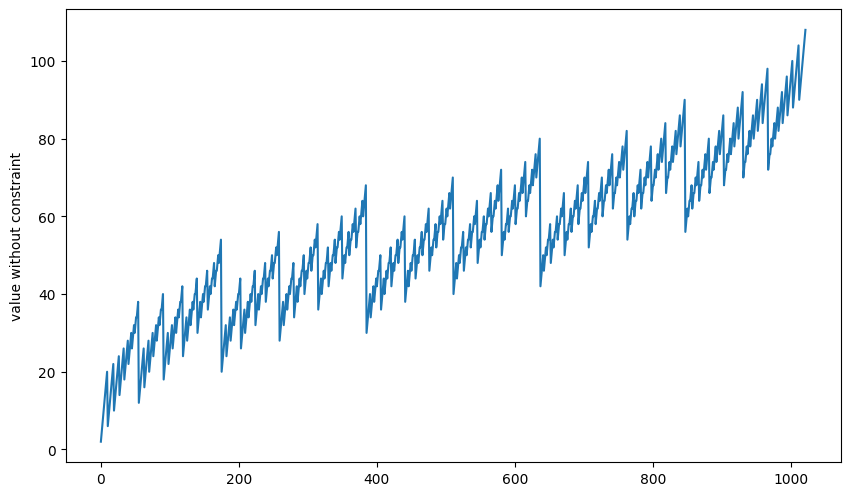

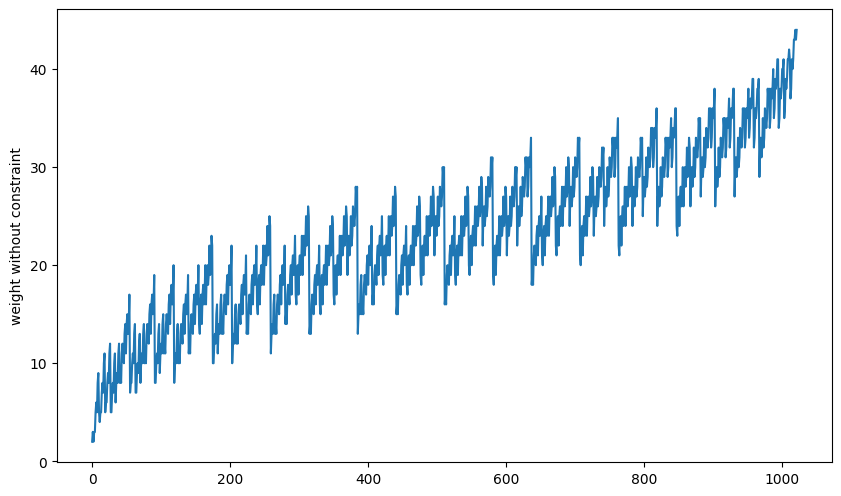

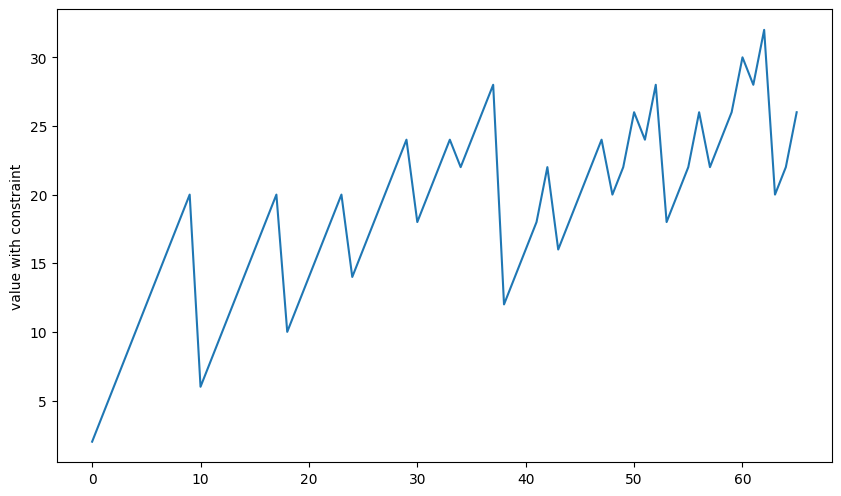

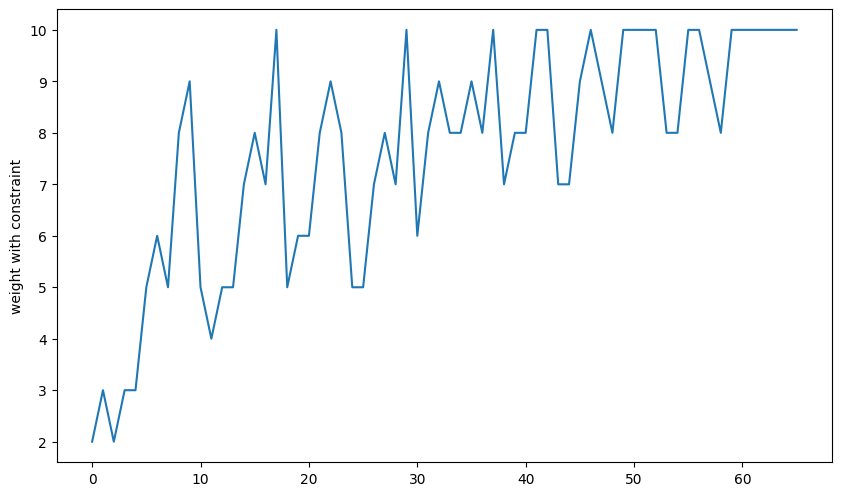

max value: 32 weight used: 10
items included: [2, 4, 7]


In [44]:
plot_knapsack(data_file_name,weight_capacity)

## QUBO formulation for the knapsack problem

### Implementing the Knapsack QUBO

In [44]:
N=len(value)
Mv = np.zeros([N,N],dtype=float)
for i in range(N):
    Mv[i][i] =-value[i]
print(Mv)

[[ -2.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.  -4.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.  -6.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.  -8.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0. -10.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0. -12.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0. -14.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0. -16.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0. -18.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0. -20.]]


In [45]:
#ProbabilisticSampler(Q,plot_limit,offset=0, min_limit=0, max_limit=0):

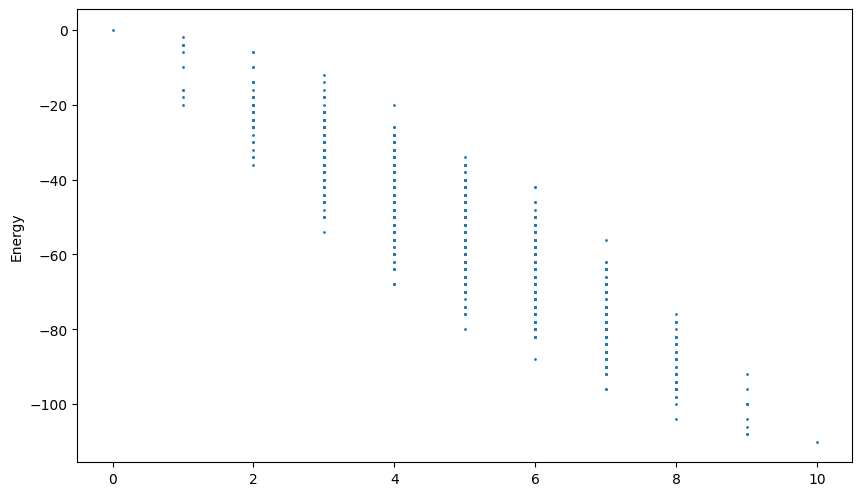

Best found: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
count: 10
Energy: -110.0
Solutions Sampled: 1024


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 -110.0,
 [1, 10, 45, 120, 210, 252, 210, 120, 45, 10, 1])

In [47]:
ProbabilisticSampler(Mv,1000)

In [46]:
N=len(value)
Mx = np.zeros([N,N],dtype=float)
for i in range(N):
    for j in range(N):
        if i==j:
            Mx[i][i] =weight[i]**2
        elif i<j:
            Mx[i][j]=2*weight[i]*weight[j]
print(Mx)

[[  4.  12.   8.  12.  12.  20.  24.  20.  32.  36.]
 [  0.   9.  12.  18.  18.  30.  36.  30.  48.  54.]
 [  0.   0.   4.  12.  12.  20.  24.  20.  32.  36.]
 [  0.   0.   0.   9.  18.  30.  36.  30.  48.  54.]
 [  0.   0.   0.   0.   9.  30.  36.  30.  48.  54.]
 [  0.   0.   0.   0.   0.  25.  60.  50.  80.  90.]
 [  0.   0.   0.   0.   0.   0.  36.  60.  96. 108.]
 [  0.   0.   0.   0.   0.   0.   0.  25.  80.  90.]
 [  0.   0.   0.   0.   0.   0.   0.   0.  64. 144.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.  81.]]


In [47]:
wc=weight_capacity
Myc = np.zeros([wc,wc],dtype=float)
for i in range(wc):
    for j in range(wc):
        if i==j:
            Myc[i][i] =-1
        elif i<j:
            Myc[i][j]=2
print(Myc)
# offset = 1

[[-1.  2.  2.  2.  2.  2.  2.  2.  2.  2.]
 [ 0. -1.  2.  2.  2.  2.  2.  2.  2.  2.]
 [ 0.  0. -1.  2.  2.  2.  2.  2.  2.  2.]
 [ 0.  0.  0. -1.  2.  2.  2.  2.  2.  2.]
 [ 0.  0.  0.  0. -1.  2.  2.  2.  2.  2.]
 [ 0.  0.  0.  0.  0. -1.  2.  2.  2.  2.]
 [ 0.  0.  0.  0.  0.  0. -1.  2.  2.  2.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  2.  2.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.  2.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]]


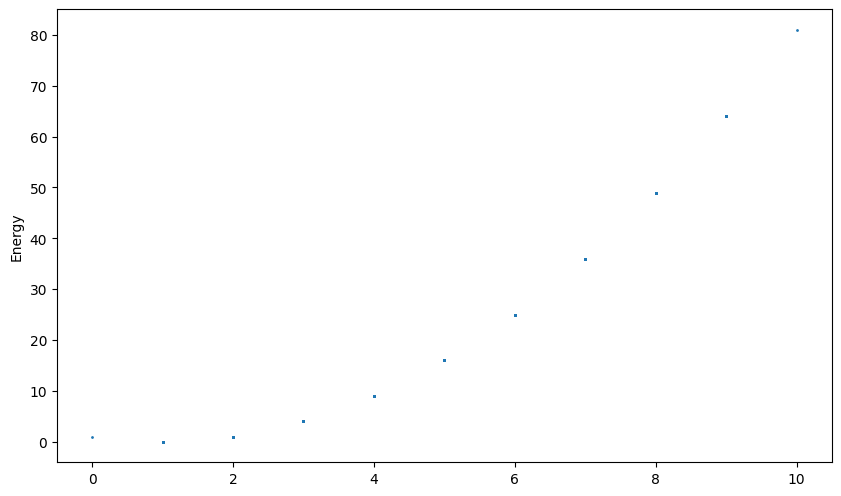

Best found: [2]
count: 1
Energy: 0.0
Solutions Sampled: 1024


([2], 0.0, [1, 10, 45, 120, 210, 252, 210, 120, 45, 10, 1])

In [50]:
ProbabilisticSampler(Myc,1000,1, 0,10)

In [48]:
wc=weight_capacity
My = np.zeros([wc,wc],dtype=float)
for n in range(1,wc+1):
    for m in range(1,wc+1):
        if n==m:
            My[n-1][m-1] =n**2
        elif n<m:
            My[n-1][m-1] =2*(n*m)  
print(My)


[[  1.   4.   6.   8.  10.  12.  14.  16.  18.  20.]
 [  0.   4.  12.  16.  20.  24.  28.  32.  36.  40.]
 [  0.   0.   9.  24.  30.  36.  42.  48.  54.  60.]
 [  0.   0.   0.  16.  40.  48.  56.  64.  72.  80.]
 [  0.   0.   0.   0.  25.  60.  70.  80.  90. 100.]
 [  0.   0.   0.   0.   0.  36.  84.  96. 108. 120.]
 [  0.   0.   0.   0.   0.   0.  49. 112. 126. 140.]
 [  0.   0.   0.   0.   0.   0.   0.  64. 144. 160.]
 [  0.   0.   0.   0.   0.   0.   0.   0.  81. 180.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0. 100.]]


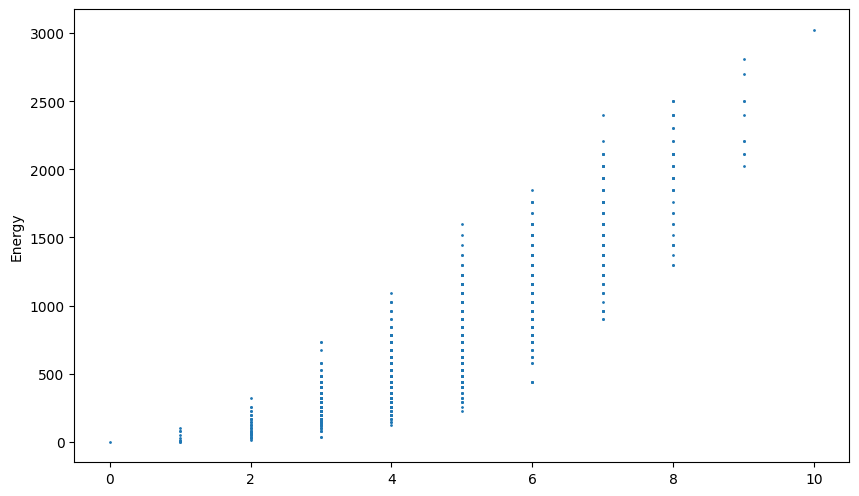

Best found: []
count: 0
Energy: 0
Solutions Sampled: 1024


([], 0, [1, 10, 45, 120, 210, 252, 210, 120, 45, 10, 1])

In [52]:
ProbabilisticSampler(My,1000)

In [49]:
wc=weight_capacity
Mxy = np.zeros([N,wc],dtype=float)
for i in range(N):
    for n in range(1,wc+1):

            Mxy[i][n-1] =-2*weight[i]*n
print(Mxy)


[[  -4.   -8.  -12.  -16.  -20.  -24.  -28.  -32.  -36.  -40.]
 [  -6.  -12.  -18.  -24.  -30.  -36.  -42.  -48.  -54.  -60.]
 [  -4.   -8.  -12.  -16.  -20.  -24.  -28.  -32.  -36.  -40.]
 [  -6.  -12.  -18.  -24.  -30.  -36.  -42.  -48.  -54.  -60.]
 [  -6.  -12.  -18.  -24.  -30.  -36.  -42.  -48.  -54.  -60.]
 [ -10.  -20.  -30.  -40.  -50.  -60.  -70.  -80.  -90. -100.]
 [ -12.  -24.  -36.  -48.  -60.  -72.  -84.  -96. -108. -120.]
 [ -10.  -20.  -30.  -40.  -50.  -60.  -70.  -80.  -90. -100.]
 [ -16.  -32.  -48.  -64.  -80.  -96. -112. -128. -144. -160.]
 [ -18.  -36.  -54.  -72.  -90. -108. -126. -144. -162. -180.]]


### Stitching the QUBO matrices together

In [50]:
A=1 #ensure only one weight is selected
B=1 # ensure weight matches total weight
C=1   # ensure correct items are selected

Mxf=C*np.array(Mv)+B*np.array(Mx)
print('Mxf',np.shape(Mxf))
Myf=A*np.array(Myc)+B*np.array(My)
print('Myf',np.shape(Myf))
MxyMyf=np.append(B*Mxy, Myf , axis=0) 
print('MxyMyf',np.shape(MxyMyf))
Mxzeros=np.zeros([wc,N],dtype=float)
print('Mxzeros',np.shape(Mxzeros))
Mxflarge=np.append(Mxf, Mxzeros, axis=0)
print('Mxflarge',np.shape(Mxflarge))
Mf=np.append(Mxflarge,MxyMyf, axis=1)
print('Mf',np.shape(Mf))
print(Mf)
np.savetxt('Mf.csv', Mf, delimiter=',')

Mxf (10, 10)
Myf (10, 10)
MxyMyf (20, 10)
Mxzeros (10, 10)
Mxflarge (20, 10)
Mf (20, 20)
[[   2.   12.    8.   12.   12.   20.   24.   20.   32.   36.   -4.   -8.
   -12.  -16.  -20.  -24.  -28.  -32.  -36.  -40.]
 [   0.    5.   12.   18.   18.   30.   36.   30.   48.   54.   -6.  -12.
   -18.  -24.  -30.  -36.  -42.  -48.  -54.  -60.]
 [   0.    0.   -2.   12.   12.   20.   24.   20.   32.   36.   -4.   -8.
   -12.  -16.  -20.  -24.  -28.  -32.  -36.  -40.]
 [   0.    0.    0.    1.   18.   30.   36.   30.   48.   54.   -6.  -12.
   -18.  -24.  -30.  -36.  -42.  -48.  -54.  -60.]
 [   0.    0.    0.    0.   -1.   30.   36.   30.   48.   54.   -6.  -12.
   -18.  -24.  -30.  -36.  -42.  -48.  -54.  -60.]
 [   0.    0.    0.    0.    0.   13.   60.   50.   80.   90.  -10.  -20.
   -30.  -40.  -50.  -60.  -70.  -80.  -90. -100.]
 [   0.    0.    0.    0.    0.    0.   22.   60.   96.  108.  -12.  -24.
   -36.  -48.  -60.  -72.  -84.  -96. -108. -120.]
 [   0.    0.    0.    0.    0.    0

In [54]:
A=400 #ensure only one weight is selected
B=2 # ensure weight matches total weight
C=1   # ensure correct items are selected

Mxf=C*np.array(Mv)+B*np.array(Mx)
print('Mxf',np.shape(Mxf))
Myf=A*np.array(Myc)+B*np.array(My)
print('Myf',np.shape(Myf))
MxyMyf=np.append(B*Mxy, Myf , axis=0) 
print('MxyMyf',np.shape(MxyMyf))
Mxzeros=np.zeros([wc,N],dtype=float)
print('Mxzeros',np.shape(Mxzeros))
Mxflarge=np.append(Mxf, Mxzeros, axis=0)
print('Mxflarge',np.shape(Mxflarge))
Mf=np.append(Mxflarge,MxyMyf, axis=1)
print('Mf',np.shape(Mf))
print(Mf)
np.savetxt('Mf.csv', Mf, delimiter=',')

Mxf (10, 10)
Myf (10, 10)
MxyMyf (20, 10)
Mxzeros (10, 10)
Mxflarge (20, 10)
Mf (20, 20)
[[   6.   24.   16.   24.   24.   40.   48.   40.   64.   72.   -8.  -16.
   -24.  -32.  -40.  -48.  -56.  -64.  -72.  -80.]
 [   0.   14.   24.   36.   36.   60.   72.   60.   96.  108.  -12.  -24.
   -36.  -48.  -60.  -72.  -84.  -96. -108. -120.]
 [   0.    0.    2.   24.   24.   40.   48.   40.   64.   72.   -8.  -16.
   -24.  -32.  -40.  -48.  -56.  -64.  -72.  -80.]
 [   0.    0.    0.   10.   36.   60.   72.   60.   96.  108.  -12.  -24.
   -36.  -48.  -60.  -72.  -84.  -96. -108. -120.]
 [   0.    0.    0.    0.    8.   60.   72.   60.   96.  108.  -12.  -24.
   -36.  -48.  -60.  -72.  -84.  -96. -108. -120.]
 [   0.    0.    0.    0.    0.   38.  120.  100.  160.  180.  -20.  -40.
   -60.  -80. -100. -120. -140. -160. -180. -200.]
 [   0.    0.    0.    0.    0.    0.   58.  120.  192.  216.  -24.  -48.
   -72.  -96. -120. -144. -168. -192. -216. -240.]
 [   0.    0.    0.    0.    0.    0

## Getting results from different QUBO samplers

### Using the Probabilistic Sampler

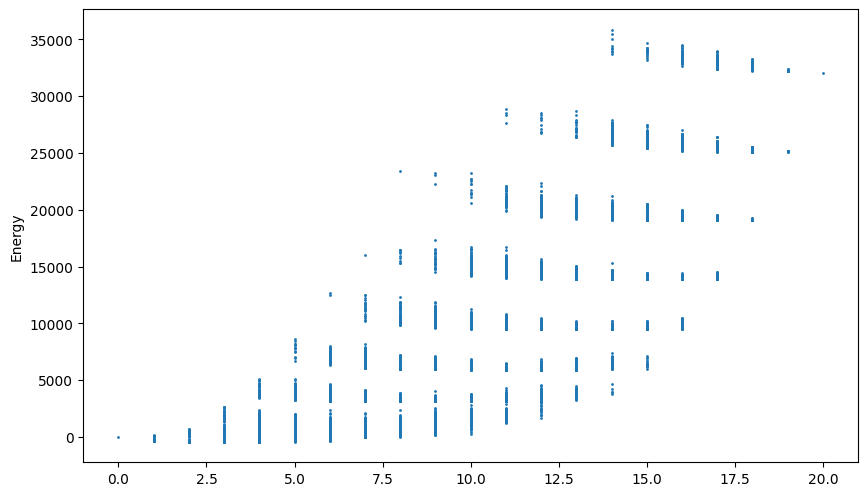

Best found: [4, 7, 17]
count: 3
Energy: -426.0
Solutions Sampled: 15422
[4, 7, 17] -426.0
4 10 3
7 16 5
Items added to Knapsack [4, 7]
Total value: 26
Total weight: 8
Condition 1 - Only one weight should be selected.
OK: condition met [8]
Condition 2 - Total weight should be equal to weight selected
OK: Condition met 8


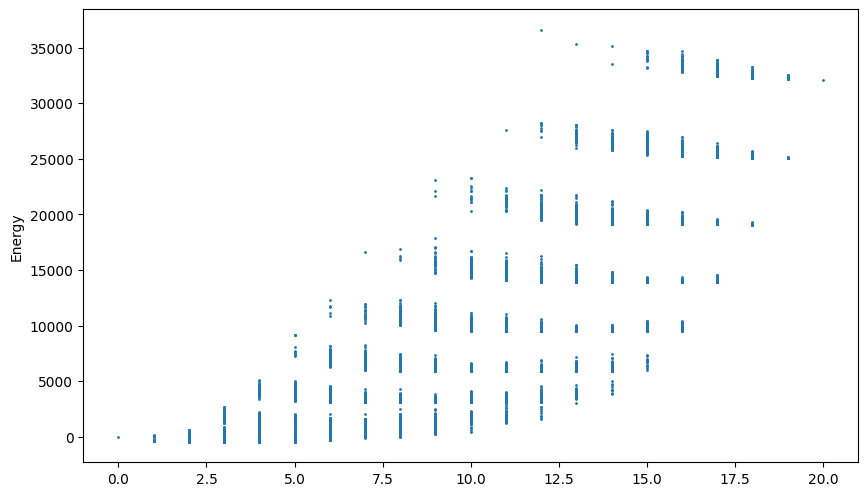

Best found: [3, 4, 7, 19]
count: 4
Energy: -432.0
Solutions Sampled: 15422
[3, 4, 7, 19] -432.0
3 8 3
4 10 3
7 16 5
Items added to Knapsack [3, 4, 7]
Total value: 34
Total weight: 11
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
FAIL: Weight match condition not met 11 10


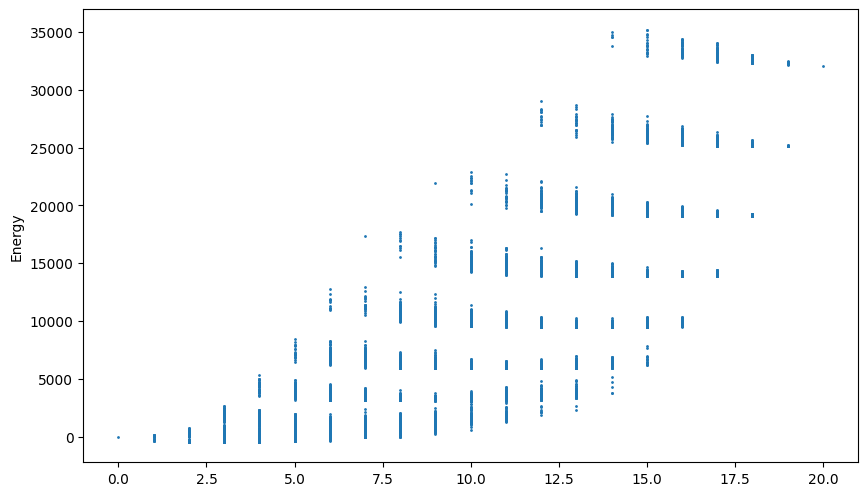

Best found: [0, 4, 7, 19]
count: 4
Energy: -428.0
Solutions Sampled: 15422
[0, 4, 7, 19] -428.0
0 2 2
4 10 3
7 16 5
Items added to Knapsack [0, 4, 7]
Total value: 28
Total weight: 10
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
OK: Condition met 10


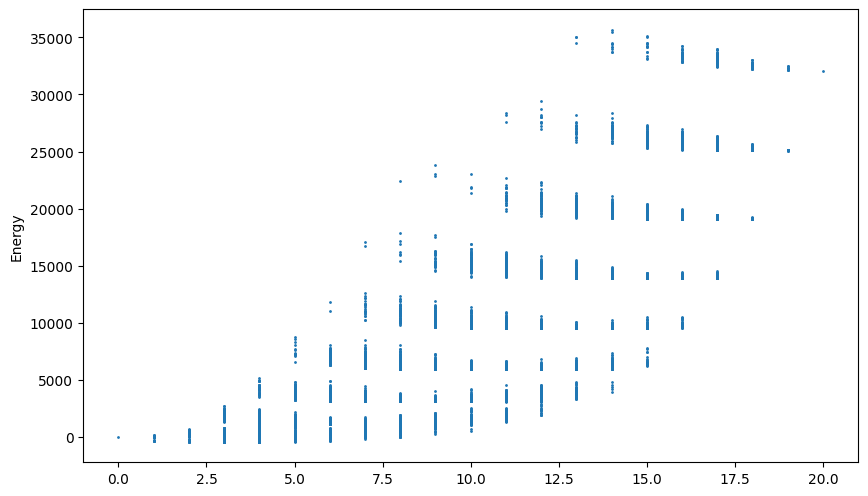

Best found: [3, 4, 7, 19]
count: 4
Energy: -432.0
Solutions Sampled: 15422
[3, 4, 7, 19] -432.0
3 8 3
4 10 3
7 16 5
Items added to Knapsack [3, 4, 7]
Total value: 34
Total weight: 11
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
FAIL: Weight match condition not met 11 10


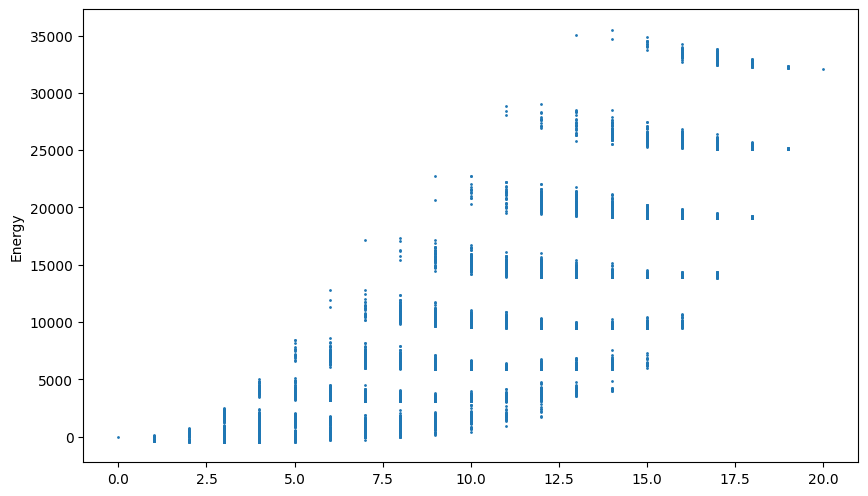

Best found: [2, 4, 7, 18]
count: 4
Energy: -430.0
Solutions Sampled: 15422
[2, 4, 7, 18] -430.0
2 6 2
4 10 3
7 16 5
Items added to Knapsack [2, 4, 7]
Total value: 32
Total weight: 10
Condition 1 - Only one weight should be selected.
OK: condition met [9]
Condition 2 - Total weight should be equal to weight selected
FAIL: Weight match condition not met 10 9


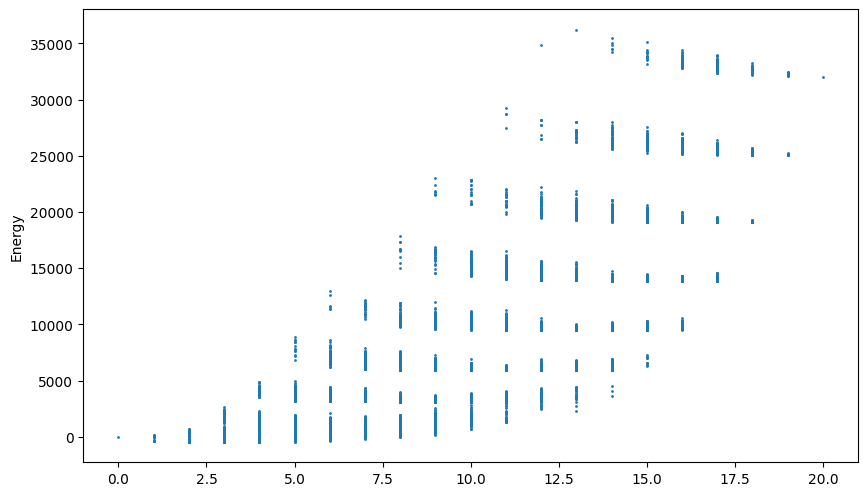

Best found: [6, 7, 19]
count: 3
Energy: -428.0
Solutions Sampled: 15422
[6, 7, 19] -428.0
6 14 6
7 16 5
Items added to Knapsack [6, 7]
Total value: 30
Total weight: 11
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
FAIL: Weight match condition not met 11 10


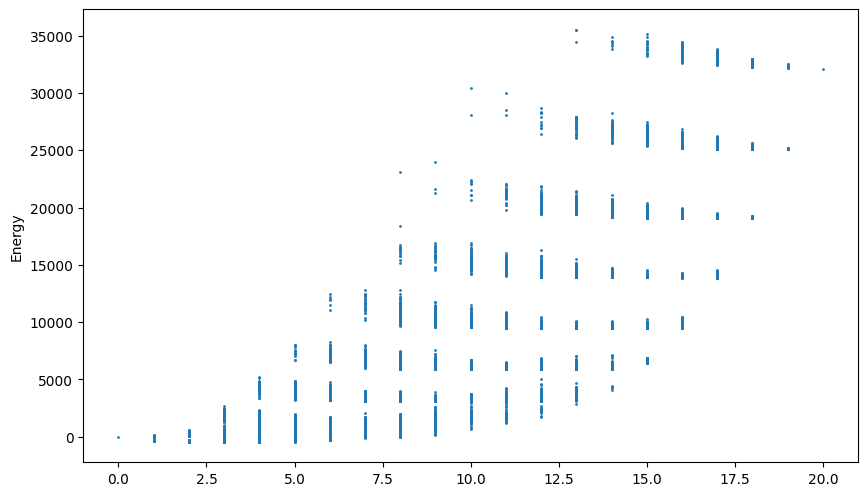

Best found: [5, 7, 19]
count: 3
Energy: -428.0
Solutions Sampled: 15422
[5, 7, 19] -428.0
5 12 5
7 16 5
Items added to Knapsack [5, 7]
Total value: 28
Total weight: 10
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
OK: Condition met 10


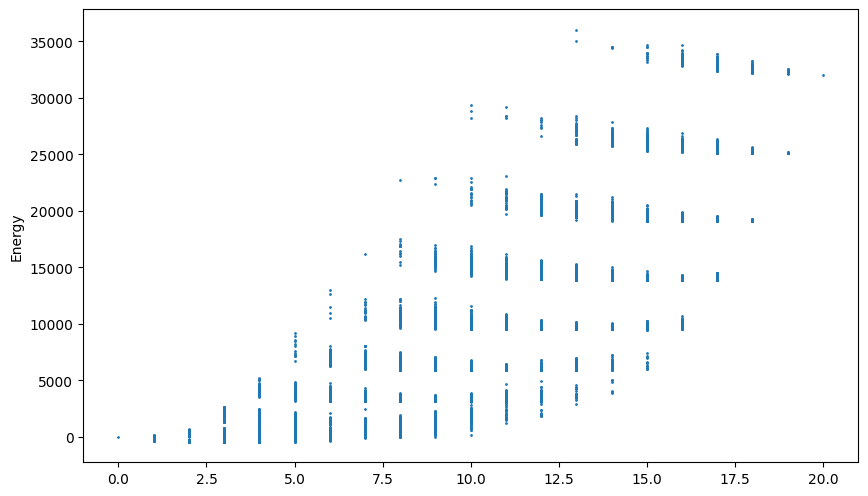

Best found: [2, 3, 7, 19]
count: 4
Energy: -430.0
Solutions Sampled: 15422
[2, 3, 7, 19] -430.0
2 6 2
3 8 3
7 16 5
Items added to Knapsack [2, 3, 7]
Total value: 30
Total weight: 10
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
OK: Condition met 10


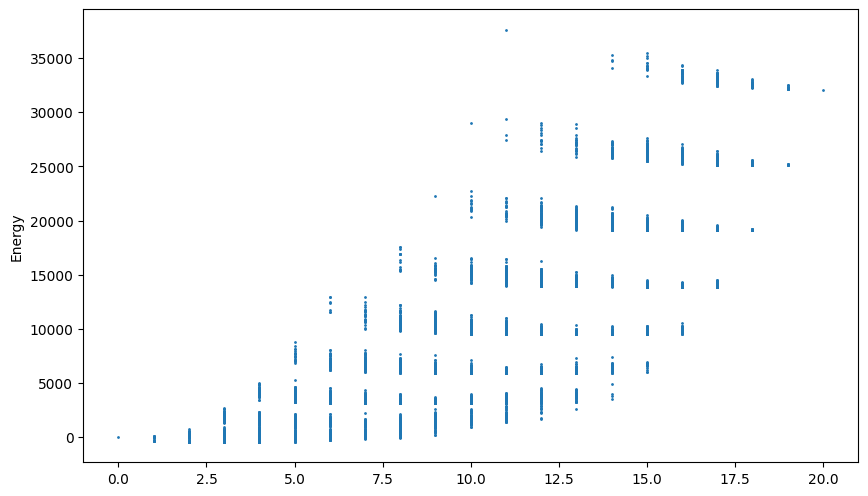

Best found: [2, 4, 7, 18]
count: 4
Energy: -430.0
Solutions Sampled: 15422
[2, 4, 7, 18] -430.0
2 6 2
4 10 3
7 16 5
Items added to Knapsack [2, 4, 7]
Total value: 32
Total weight: 10
Condition 1 - Only one weight should be selected.
OK: condition met [9]
Condition 2 - Total weight should be equal to weight selected
FAIL: Weight match condition not met 10 9


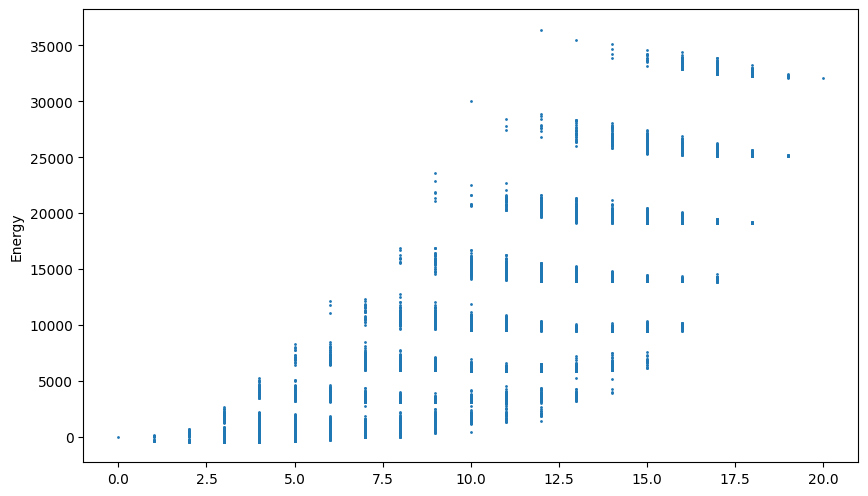

Best found: [2, 4, 7, 18]
count: 4
Energy: -430.0
Solutions Sampled: 15422
[2, 4, 7, 18] -430.0
2 6 2
4 10 3
7 16 5
Items added to Knapsack [2, 4, 7]
Total value: 32
Total weight: 10
Condition 1 - Only one weight should be selected.
OK: condition met [9]
Condition 2 - Total weight should be equal to weight selected
FAIL: Weight match condition not met 10 9


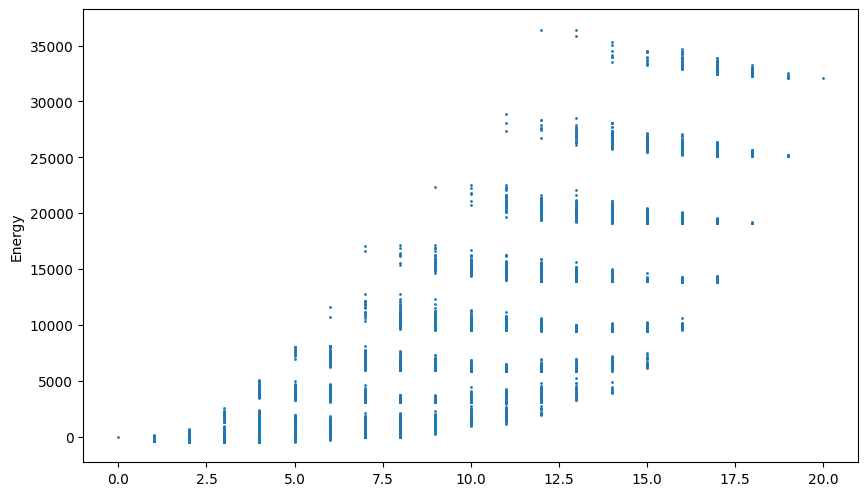

Best found: [5, 7, 19]
count: 3
Energy: -428.0
Solutions Sampled: 15422
[5, 7, 19] -428.0
5 12 5
7 16 5
Items added to Knapsack [5, 7]
Total value: 28
Total weight: 10
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
OK: Condition met 10


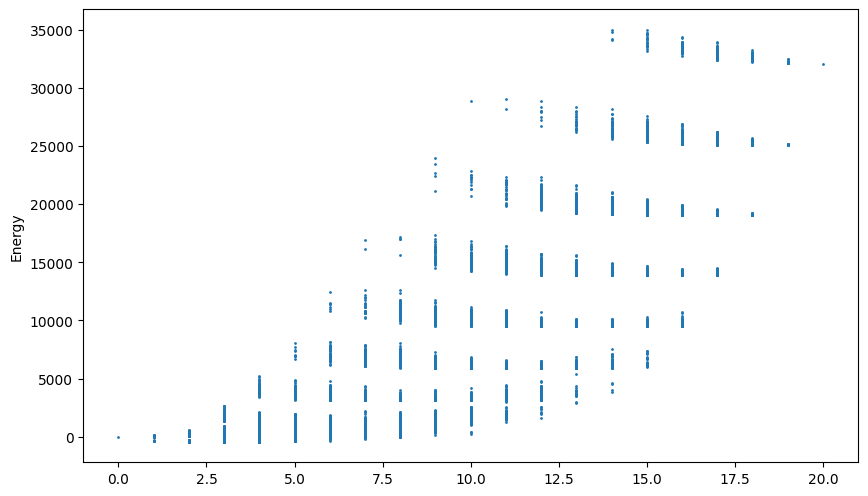

Best found: [2, 3, 7, 19]
count: 4
Energy: -430.0
Solutions Sampled: 15422
[2, 3, 7, 19] -430.0
2 6 2
3 8 3
7 16 5
Items added to Knapsack [2, 3, 7]
Total value: 30
Total weight: 10
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
OK: Condition met 10


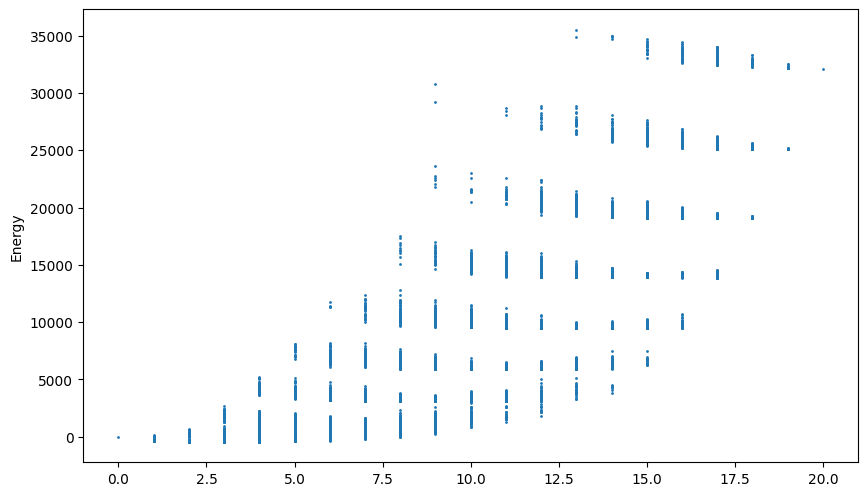

Best found: [2, 4, 7, 19]
count: 4
Energy: -432.0
Solutions Sampled: 15422
[2, 4, 7, 19] -432.0
2 6 2
4 10 3
7 16 5
Items added to Knapsack [2, 4, 7]
Total value: 32
Total weight: 10
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
OK: Condition met 10


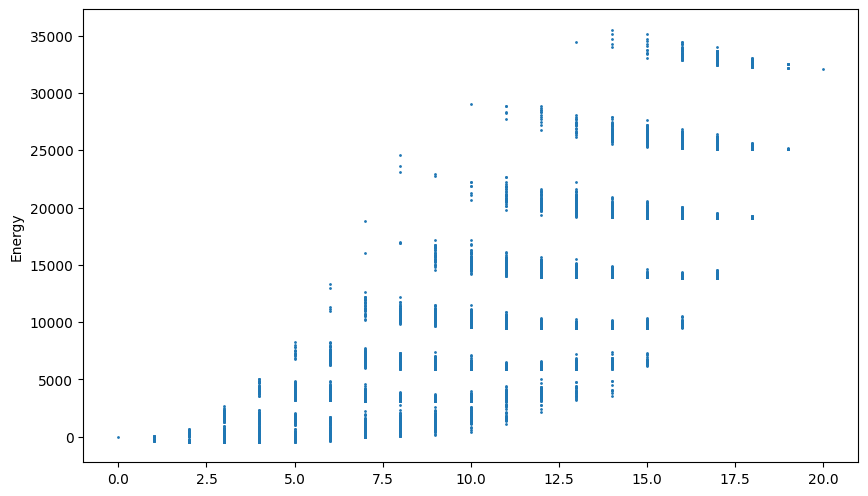

Best found: [5, 7, 19]
count: 3
Energy: -428.0
Solutions Sampled: 15422
[5, 7, 19] -428.0
5 12 5
7 16 5
Items added to Knapsack [5, 7]
Total value: 28
Total weight: 10
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
OK: Condition met 10


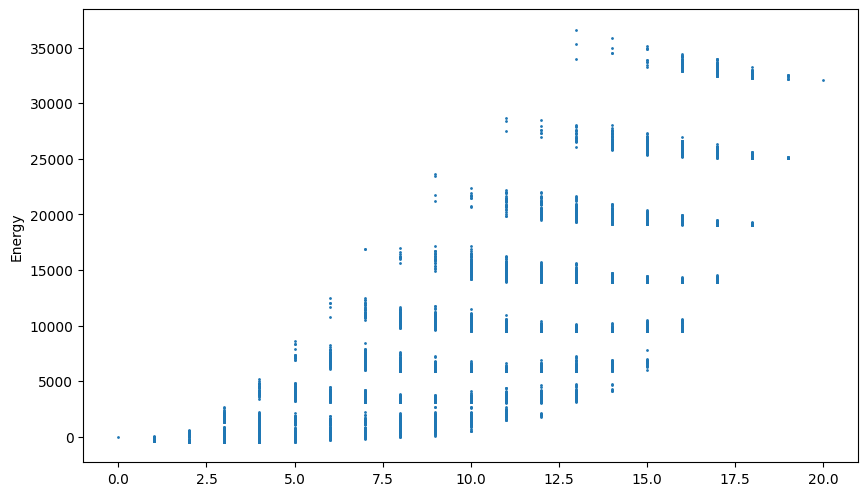

Best found: [3, 4, 7, 19]
count: 4
Energy: -432.0
Solutions Sampled: 15422
[3, 4, 7, 19] -432.0
3 8 3
4 10 3
7 16 5
Items added to Knapsack [3, 4, 7]
Total value: 34
Total weight: 11
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
FAIL: Weight match condition not met 11 10


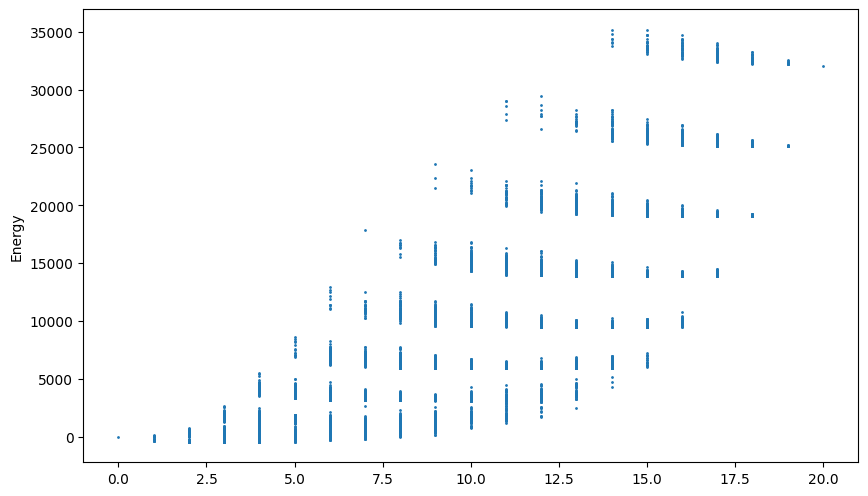

Best found: [2, 3, 7, 19]
count: 4
Energy: -430.0
Solutions Sampled: 15422
[2, 3, 7, 19] -430.0
2 6 2
3 8 3
7 16 5
Items added to Knapsack [2, 3, 7]
Total value: 30
Total weight: 10
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
OK: Condition met 10


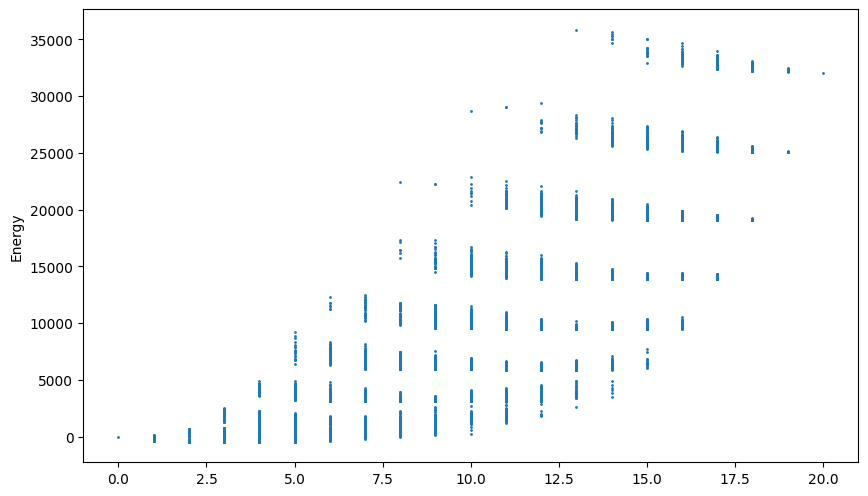

Best found: [2, 4, 7, 19]
count: 4
Energy: -432.0
Solutions Sampled: 15422
[2, 4, 7, 19] -432.0
2 6 2
4 10 3
7 16 5
Items added to Knapsack [2, 4, 7]
Total value: 32
Total weight: 10
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
OK: Condition met 10


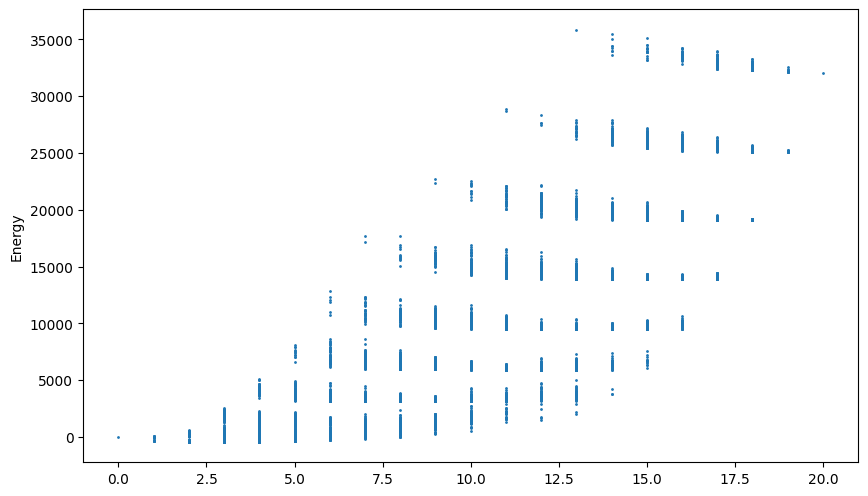

Best found: [5, 7, 19]
count: 3
Energy: -428.0
Solutions Sampled: 15422
[5, 7, 19] -428.0
5 12 5
7 16 5
Items added to Knapsack [5, 7]
Total value: 28
Total weight: 10
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
OK: Condition met 10


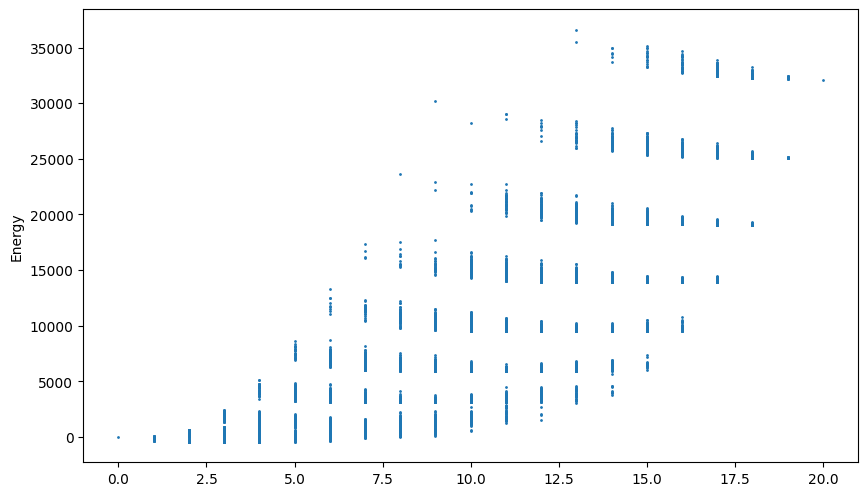

Best found: [2, 4, 7, 18]
count: 4
Energy: -430.0
Solutions Sampled: 15422
[2, 4, 7, 18] -430.0
2 6 2
4 10 3
7 16 5
Items added to Knapsack [2, 4, 7]
Total value: 32
Total weight: 10
Condition 1 - Only one weight should be selected.
OK: condition met [9]
Condition 2 - Total weight should be equal to weight selected
FAIL: Weight match condition not met 10 9


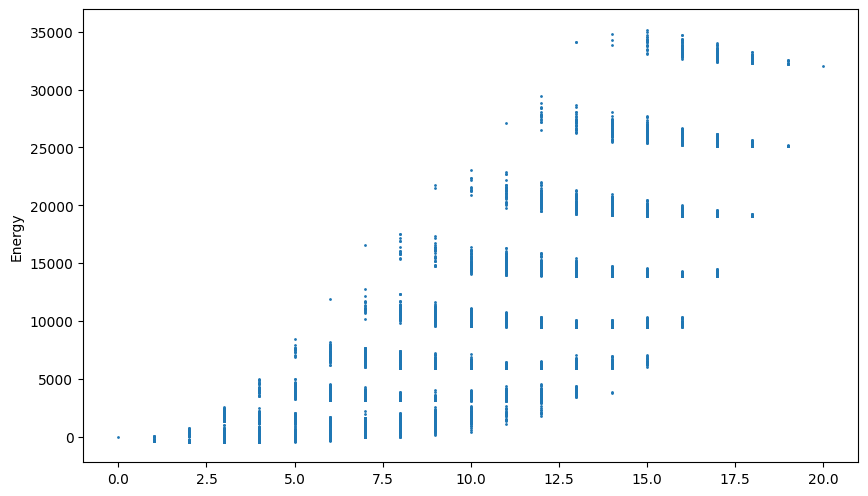

Best found: [2, 3, 7, 19]
count: 4
Energy: -430.0
Solutions Sampled: 15422
[2, 3, 7, 19] -430.0
2 6 2
3 8 3
7 16 5
Items added to Knapsack [2, 3, 7]
Total value: 30
Total weight: 10
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
OK: Condition met 10


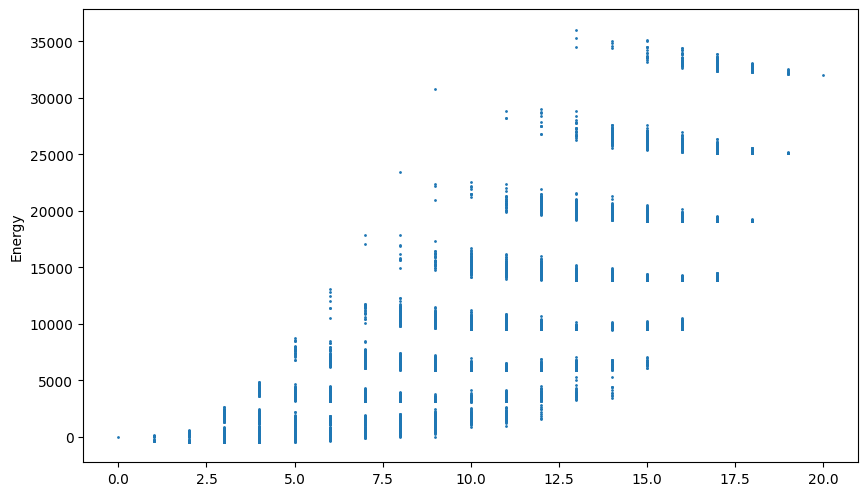

Best found: [2, 4, 7, 18]
count: 4
Energy: -430.0
Solutions Sampled: 15422
[2, 4, 7, 18] -430.0
2 6 2
4 10 3
7 16 5
Items added to Knapsack [2, 4, 7]
Total value: 32
Total weight: 10
Condition 1 - Only one weight should be selected.
OK: condition met [9]
Condition 2 - Total weight should be equal to weight selected
FAIL: Weight match condition not met 10 9


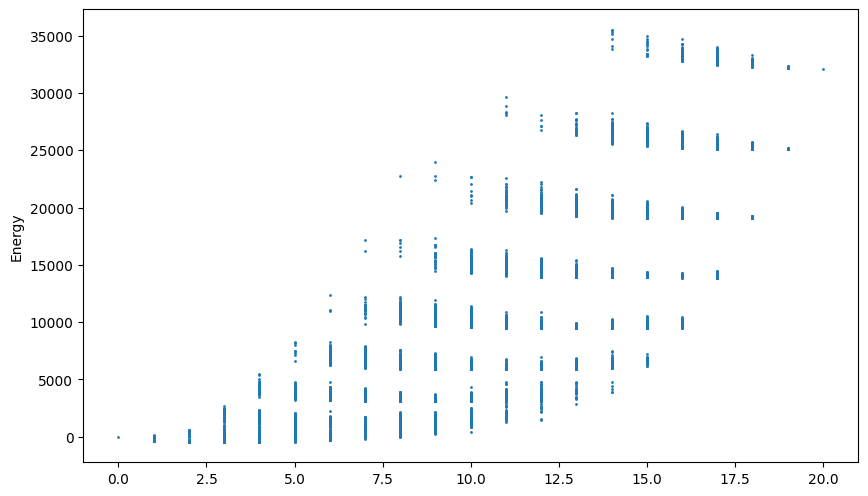

Best found: [6, 7, 19]
count: 3
Energy: -428.0
Solutions Sampled: 15422
[6, 7, 19] -428.0
6 14 6
7 16 5
Items added to Knapsack [6, 7]
Total value: 30
Total weight: 11
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
FAIL: Weight match condition not met 11 10


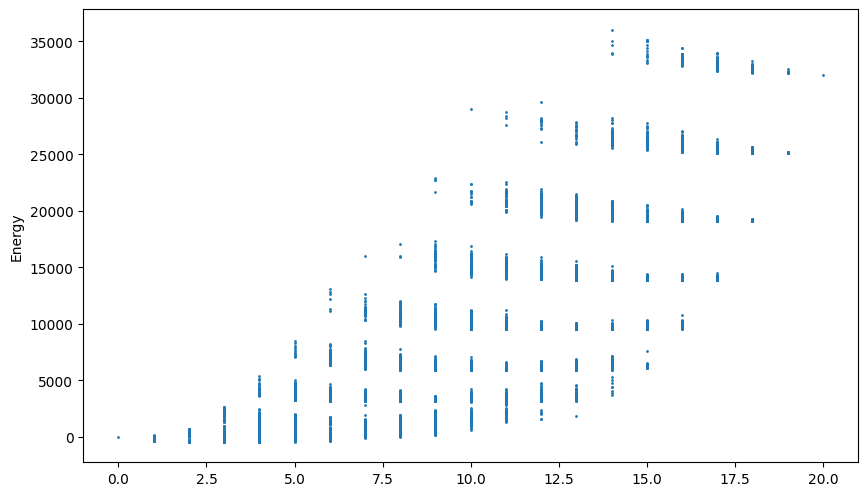

Best found: [2, 4, 7, 19]
count: 4
Energy: -432.0
Solutions Sampled: 15422
[2, 4, 7, 19] -432.0
2 6 2
4 10 3
7 16 5
Items added to Knapsack [2, 4, 7]
Total value: 32
Total weight: 10
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
OK: Condition met 10


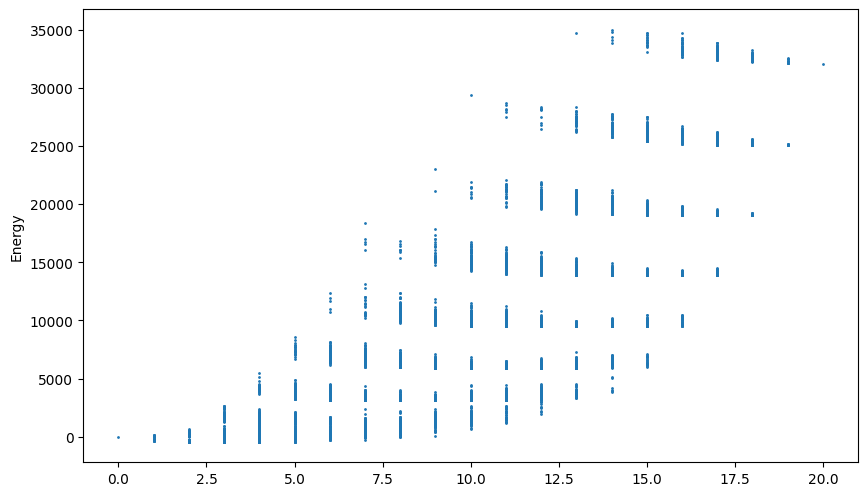

Best found: [3, 4, 5, 19]
count: 4
Energy: -428.0
Solutions Sampled: 15422
[3, 4, 5, 19] -428.0
3 8 3
4 10 3
5 12 5
Items added to Knapsack [3, 4, 5]
Total value: 30
Total weight: 11
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
FAIL: Weight match condition not met 11 10


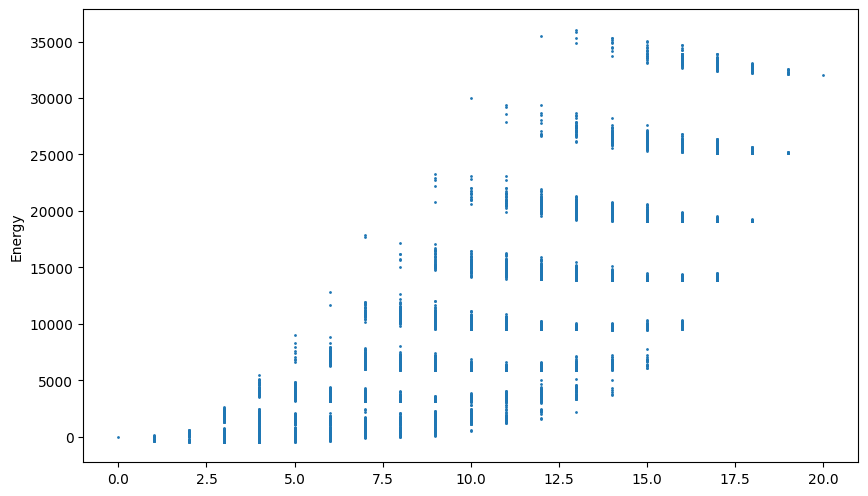

Best found: [2, 3, 7, 19]
count: 4
Energy: -430.0
Solutions Sampled: 15422
[2, 3, 7, 19] -430.0
2 6 2
3 8 3
7 16 5
Items added to Knapsack [2, 3, 7]
Total value: 30
Total weight: 10
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
OK: Condition met 10


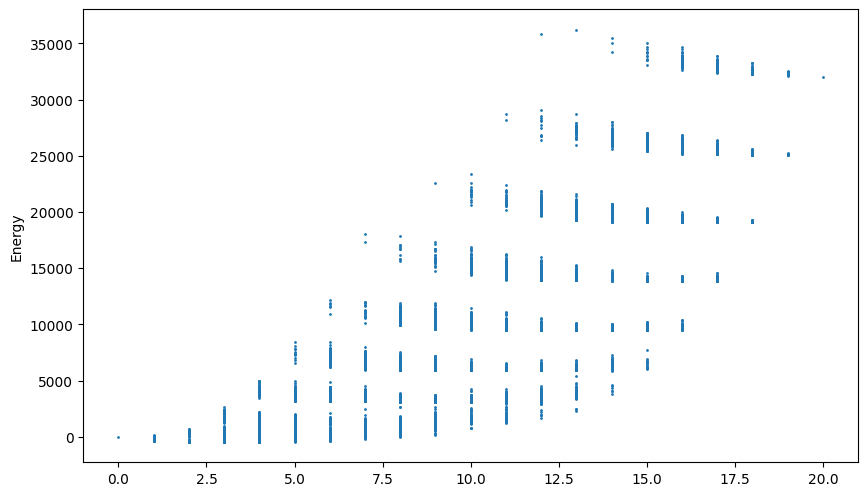

Best found: [6, 7, 19]
count: 3
Energy: -428.0
Solutions Sampled: 15422
[6, 7, 19] -428.0
6 14 6
7 16 5
Items added to Knapsack [6, 7]
Total value: 30
Total weight: 11
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
FAIL: Weight match condition not met 11 10


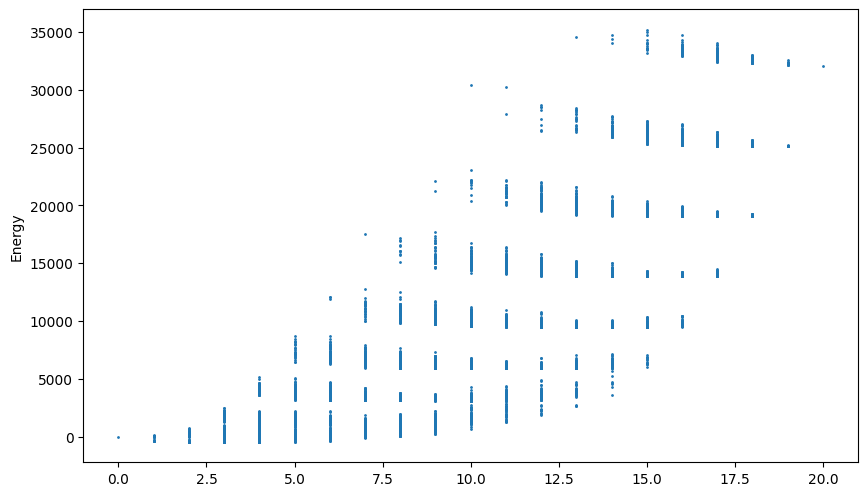

Best found: [6, 7, 19]
count: 3
Energy: -428.0
Solutions Sampled: 15422
[6, 7, 19] -428.0
6 14 6
7 16 5
Items added to Knapsack [6, 7]
Total value: 30
Total weight: 11
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
FAIL: Weight match condition not met 11 10


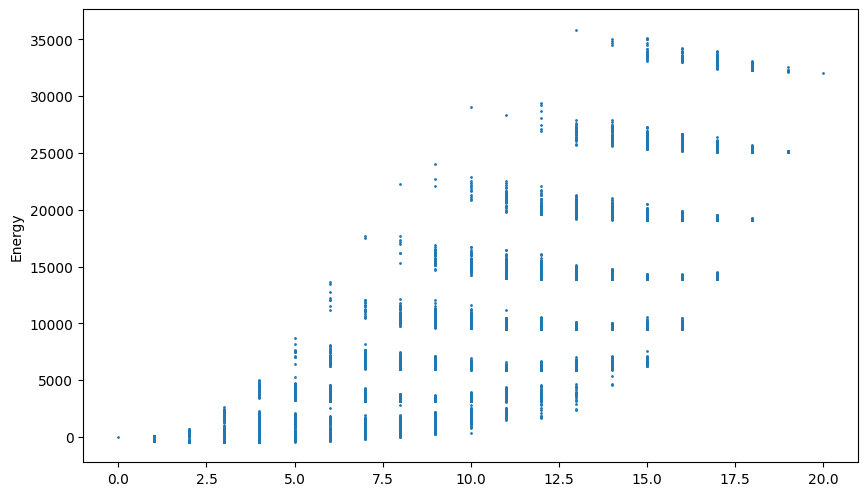

Best found: [2, 4, 5, 19]
count: 4
Energy: -428.0
Solutions Sampled: 15422
[2, 4, 5, 19] -428.0
2 6 2
4 10 3
5 12 5
Items added to Knapsack [2, 4, 5]
Total value: 28
Total weight: 10
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
OK: Condition met 10


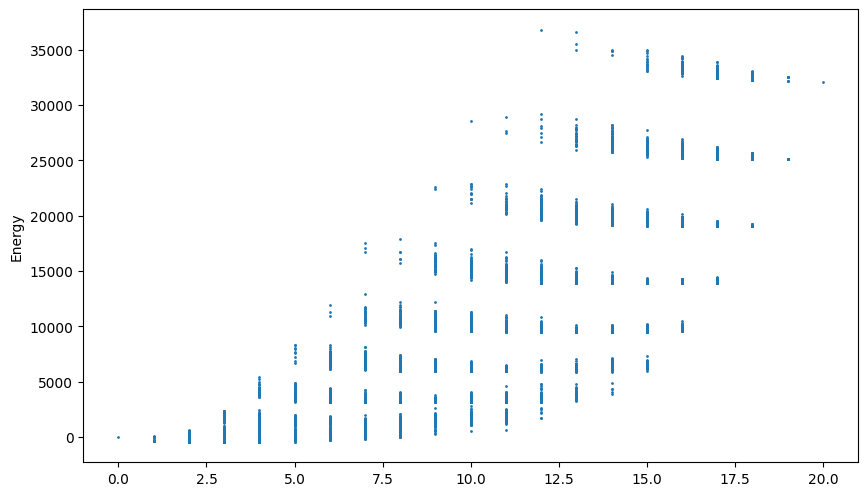

Best found: [6, 7, 19]
count: 3
Energy: -428.0
Solutions Sampled: 15422
[6, 7, 19] -428.0
6 14 6
7 16 5
Items added to Knapsack [6, 7]
Total value: 30
Total weight: 11
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
FAIL: Weight match condition not met 11 10


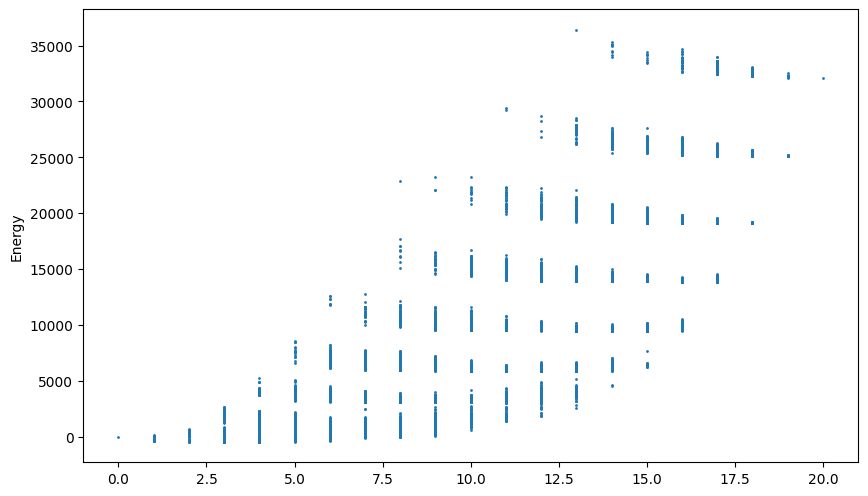

Best found: [3, 4, 7, 19]
count: 4
Energy: -432.0
Solutions Sampled: 15422
[3, 4, 7, 19] -432.0
3 8 3
4 10 3
7 16 5
Items added to Knapsack [3, 4, 7]
Total value: 34
Total weight: 11
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
FAIL: Weight match condition not met 11 10


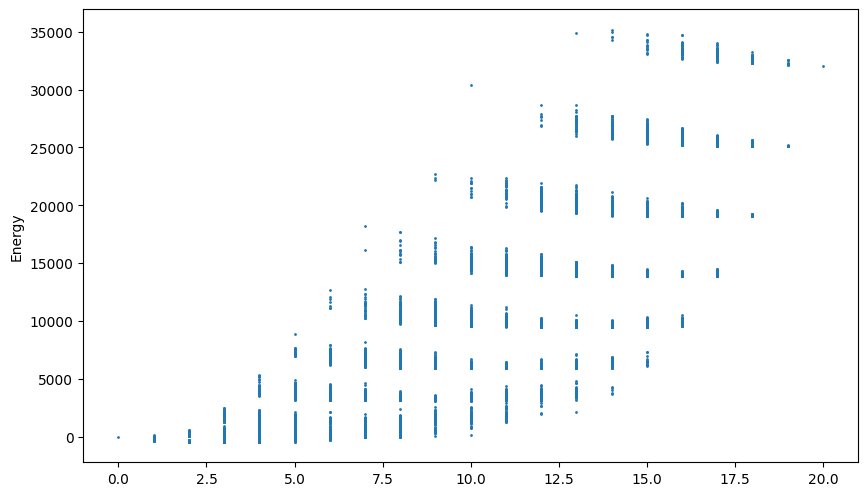

Best found: [5, 7, 19]
count: 3
Energy: -428.0
Solutions Sampled: 15422
[5, 7, 19] -428.0
5 12 5
7 16 5
Items added to Knapsack [5, 7]
Total value: 28
Total weight: 10
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
OK: Condition met 10


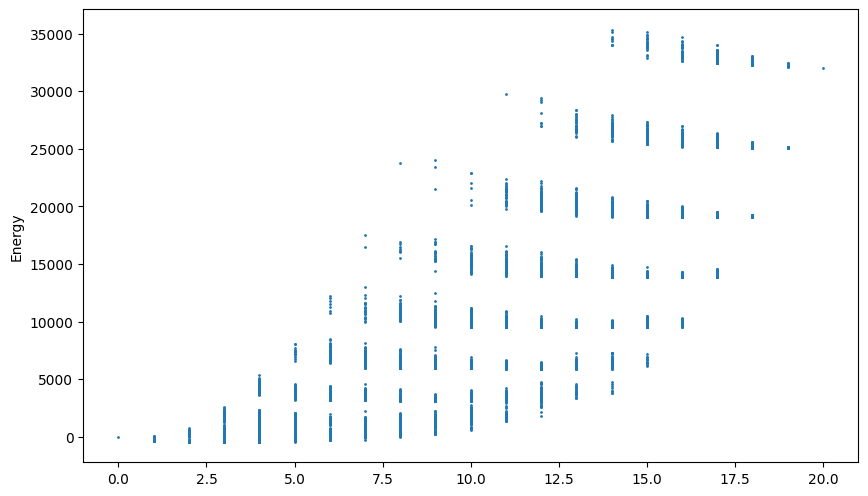

Best found: [2, 4, 7, 19]
count: 4
Energy: -432.0
Solutions Sampled: 15422
[2, 4, 7, 19] -432.0
2 6 2
4 10 3
7 16 5
Items added to Knapsack [2, 4, 7]
Total value: 32
Total weight: 10
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
OK: Condition met 10


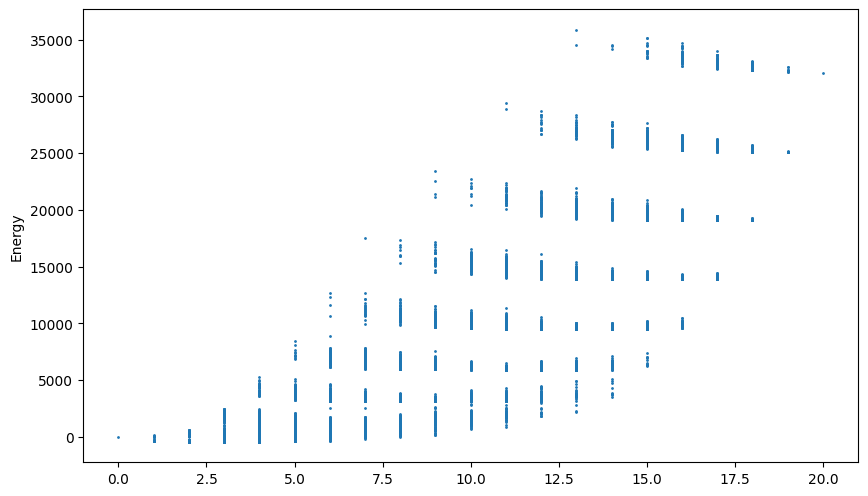

Best found: [6, 7, 19]
count: 3
Energy: -428.0
Solutions Sampled: 15422
[6, 7, 19] -428.0
6 14 6
7 16 5
Items added to Knapsack [6, 7]
Total value: 30
Total weight: 11
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
FAIL: Weight match condition not met 11 10


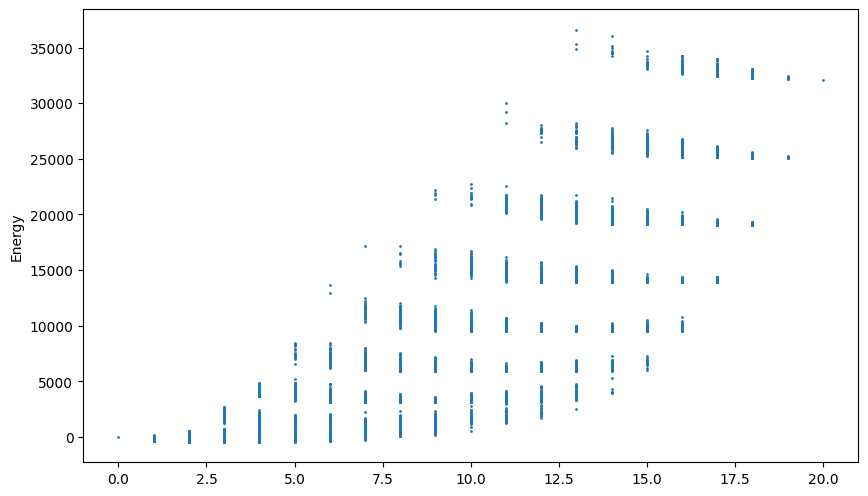

Best found: [4, 7, 17]
count: 3
Energy: -426.0
Solutions Sampled: 15422
[4, 7, 17] -426.0
4 10 3
7 16 5
Items added to Knapsack [4, 7]
Total value: 26
Total weight: 8
Condition 1 - Only one weight should be selected.
OK: condition met [8]
Condition 2 - Total weight should be equal to weight selected
OK: Condition met 8


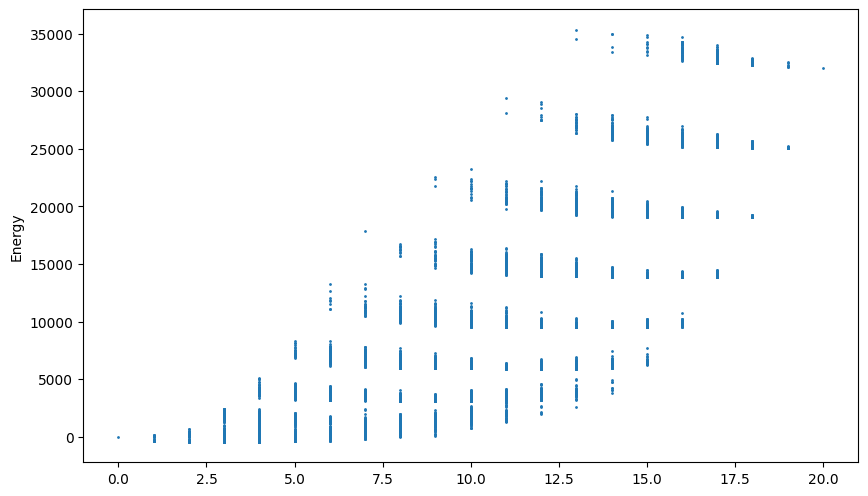

Best found: [2, 4, 7, 18]
count: 4
Energy: -430.0
Solutions Sampled: 15422
[2, 4, 7, 18] -430.0
2 6 2
4 10 3
7 16 5
Items added to Knapsack [2, 4, 7]
Total value: 32
Total weight: 10
Condition 1 - Only one weight should be selected.
OK: condition met [9]
Condition 2 - Total weight should be equal to weight selected
FAIL: Weight match condition not met 10 9


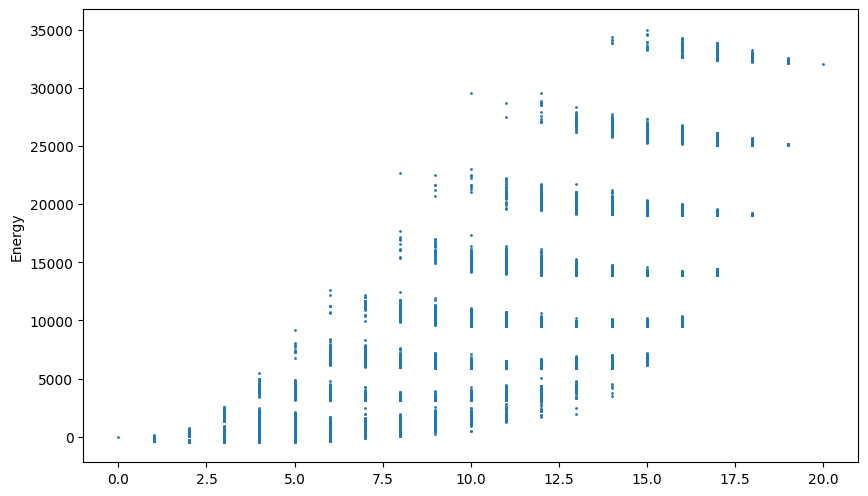

Best found: [2, 3, 7, 19]
count: 4
Energy: -430.0
Solutions Sampled: 15422
[2, 3, 7, 19] -430.0
2 6 2
3 8 3
7 16 5
Items added to Knapsack [2, 3, 7]
Total value: 30
Total weight: 10
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
OK: Condition met 10


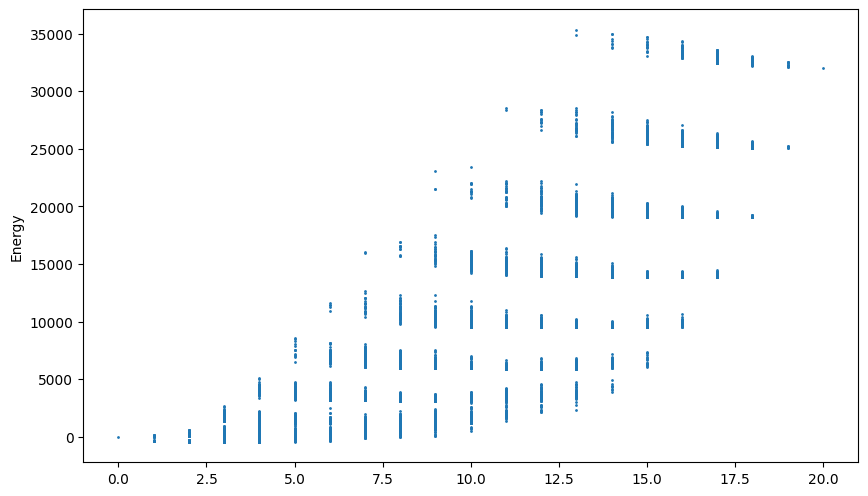

Best found: [2, 3, 7, 19]
count: 4
Energy: -430.0
Solutions Sampled: 15422
[2, 3, 7, 19] -430.0
2 6 2
3 8 3
7 16 5
Items added to Knapsack [2, 3, 7]
Total value: 30
Total weight: 10
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
OK: Condition met 10


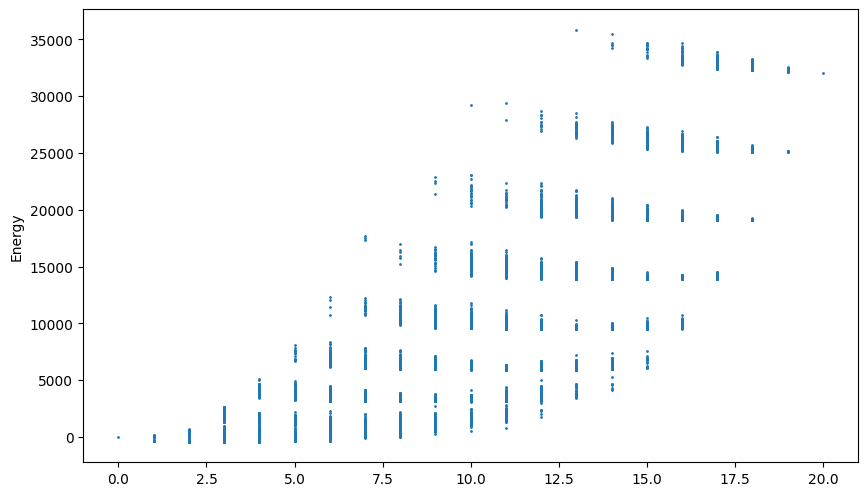

Best found: [5, 7, 19]
count: 3
Energy: -428.0
Solutions Sampled: 15422
[5, 7, 19] -428.0
5 12 5
7 16 5
Items added to Knapsack [5, 7]
Total value: 28
Total weight: 10
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
OK: Condition met 10


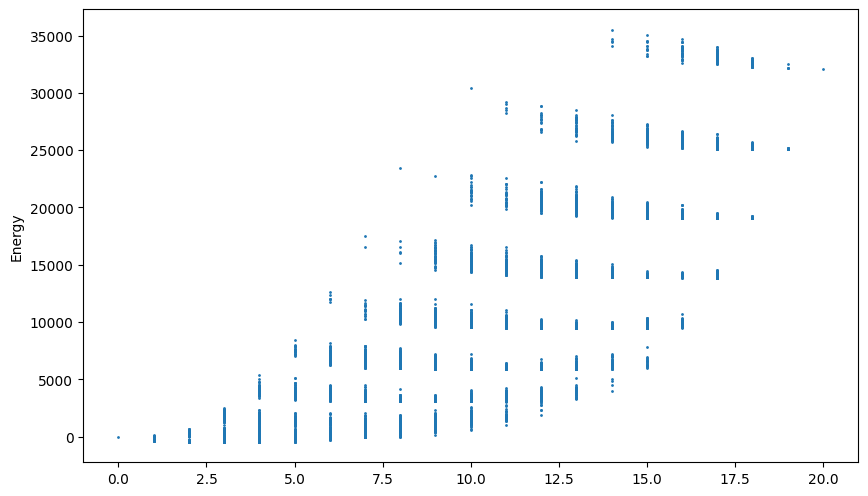

Best found: [5, 7, 19]
count: 3
Energy: -428.0
Solutions Sampled: 15422
[5, 7, 19] -428.0
5 12 5
7 16 5
Items added to Knapsack [5, 7]
Total value: 28
Total weight: 10
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
OK: Condition met 10


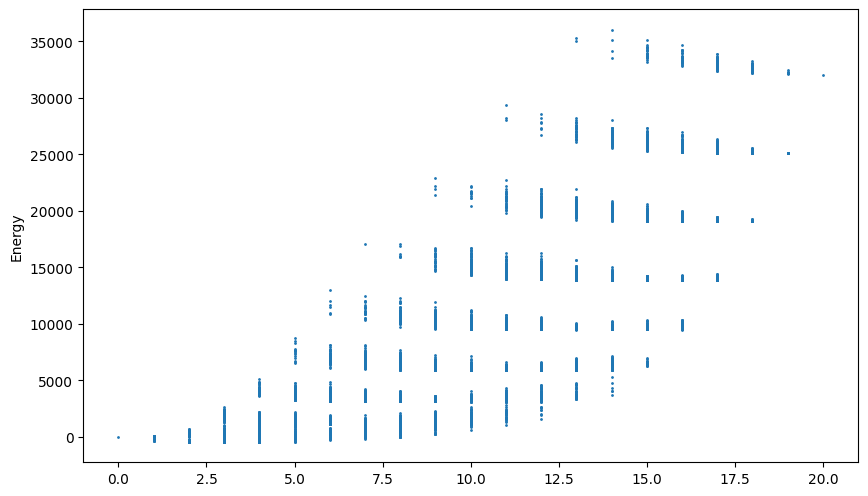

Best found: [2, 4, 5, 19]
count: 4
Energy: -428.0
Solutions Sampled: 15422
[2, 4, 5, 19] -428.0
2 6 2
4 10 3
5 12 5
Items added to Knapsack [2, 4, 5]
Total value: 28
Total weight: 10
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
OK: Condition met 10


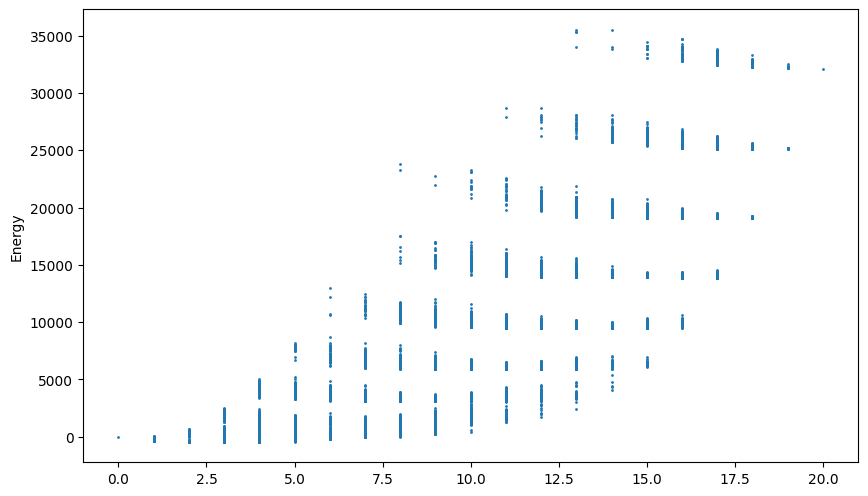

Best found: [5, 7, 19]
count: 3
Energy: -428.0
Solutions Sampled: 15422
[5, 7, 19] -428.0
5 12 5
7 16 5
Items added to Knapsack [5, 7]
Total value: 28
Total weight: 10
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
OK: Condition met 10


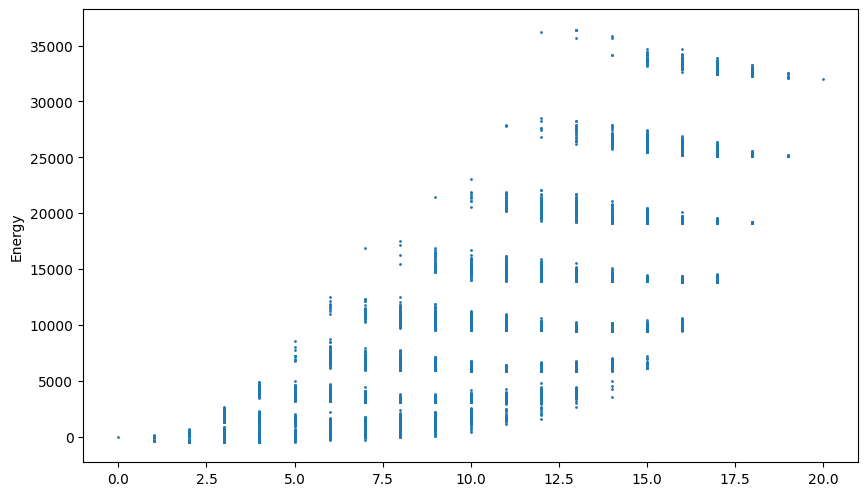

Best found: [3, 4, 7, 19]
count: 4
Energy: -432.0
Solutions Sampled: 15422
[3, 4, 7, 19] -432.0
3 8 3
4 10 3
7 16 5
Items added to Knapsack [3, 4, 7]
Total value: 34
Total weight: 11
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
FAIL: Weight match condition not met 11 10


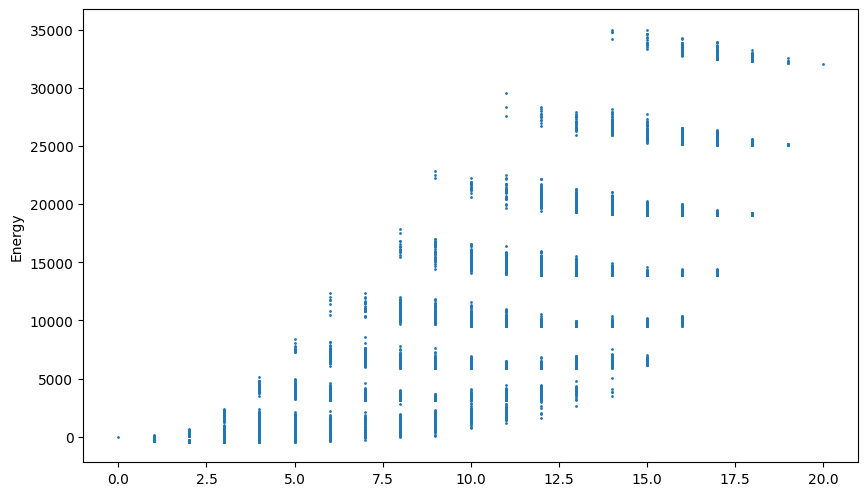

Best found: [6, 7, 19]
count: 3
Energy: -428.0
Solutions Sampled: 15422
[6, 7, 19] -428.0
6 14 6
7 16 5
Items added to Knapsack [6, 7]
Total value: 30
Total weight: 11
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
FAIL: Weight match condition not met 11 10


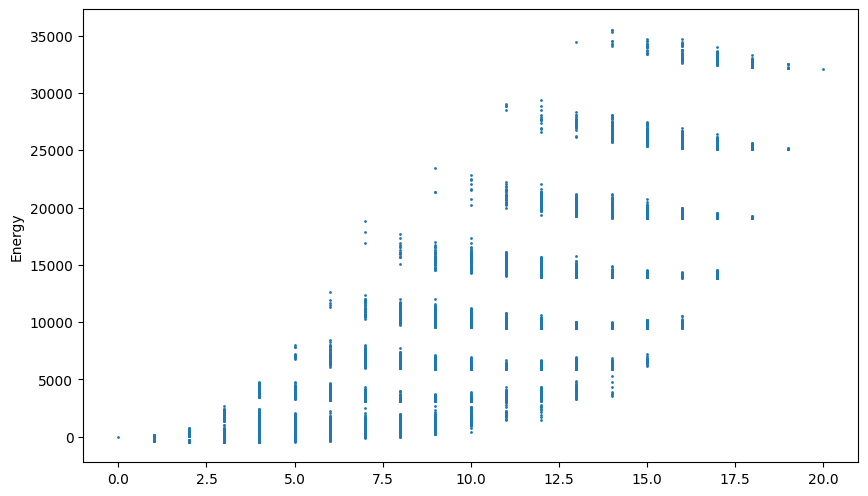

Best found: [2, 4, 7, 18]
count: 4
Energy: -430.0
Solutions Sampled: 15422
[2, 4, 7, 18] -430.0
2 6 2
4 10 3
7 16 5
Items added to Knapsack [2, 4, 7]
Total value: 32
Total weight: 10
Condition 1 - Only one weight should be selected.
OK: condition met [9]
Condition 2 - Total weight should be equal to weight selected
FAIL: Weight match condition not met 10 9


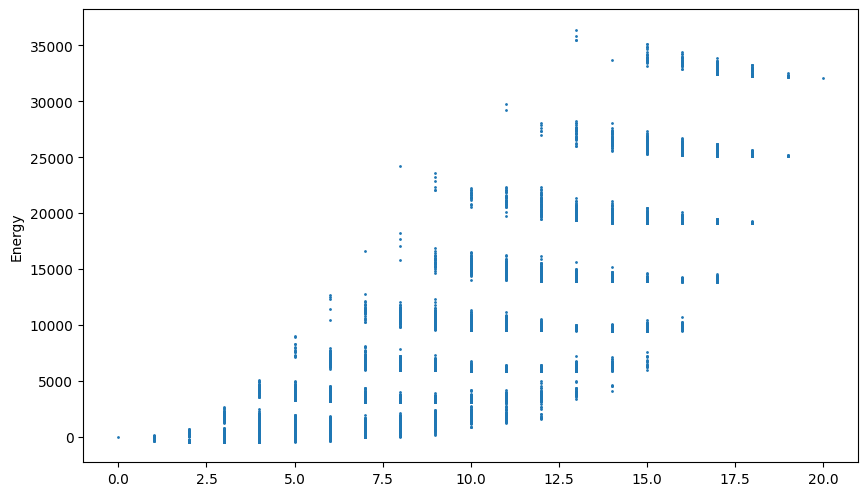

Best found: [3, 4, 7, 19]
count: 4
Energy: -432.0
Solutions Sampled: 15422
[3, 4, 7, 19] -432.0
3 8 3
4 10 3
7 16 5
Items added to Knapsack [3, 4, 7]
Total value: 34
Total weight: 11
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
FAIL: Weight match condition not met 11 10


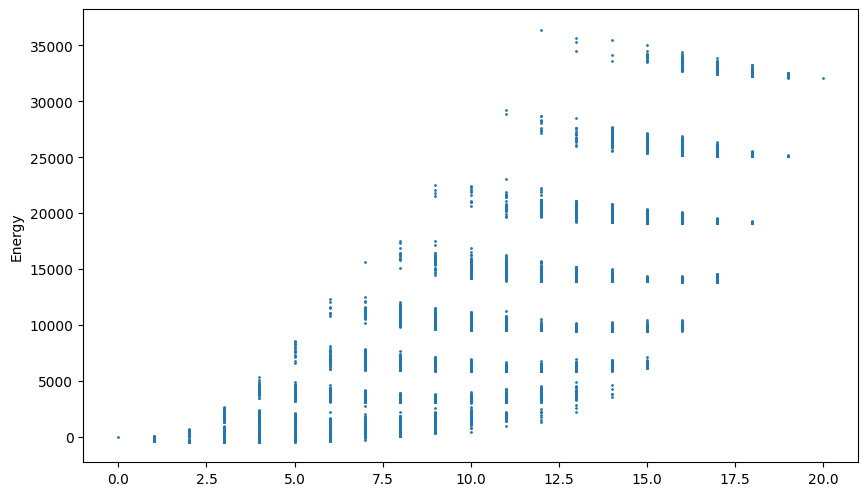

Best found: [5, 7, 19]
count: 3
Energy: -428.0
Solutions Sampled: 15422
[5, 7, 19] -428.0
5 12 5
7 16 5
Items added to Knapsack [5, 7]
Total value: 28
Total weight: 10
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
OK: Condition met 10


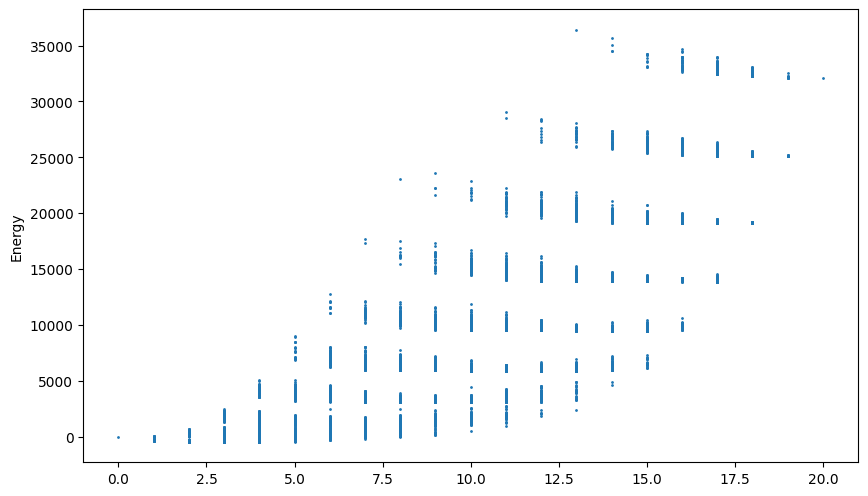

Best found: [3, 4, 7, 19]
count: 4
Energy: -432.0
Solutions Sampled: 15422
[3, 4, 7, 19] -432.0
3 8 3
4 10 3
7 16 5
Items added to Knapsack [3, 4, 7]
Total value: 34
Total weight: 11
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
FAIL: Weight match condition not met 11 10


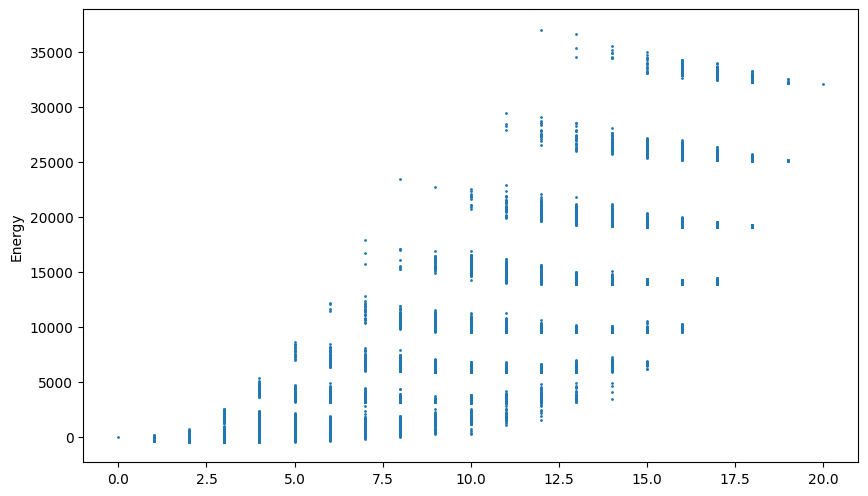

Best found: [3, 4, 7, 19]
count: 4
Energy: -432.0
Solutions Sampled: 15422
[3, 4, 7, 19] -432.0
3 8 3
4 10 3
7 16 5
Items added to Knapsack [3, 4, 7]
Total value: 34
Total weight: 11
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
FAIL: Weight match condition not met 11 10


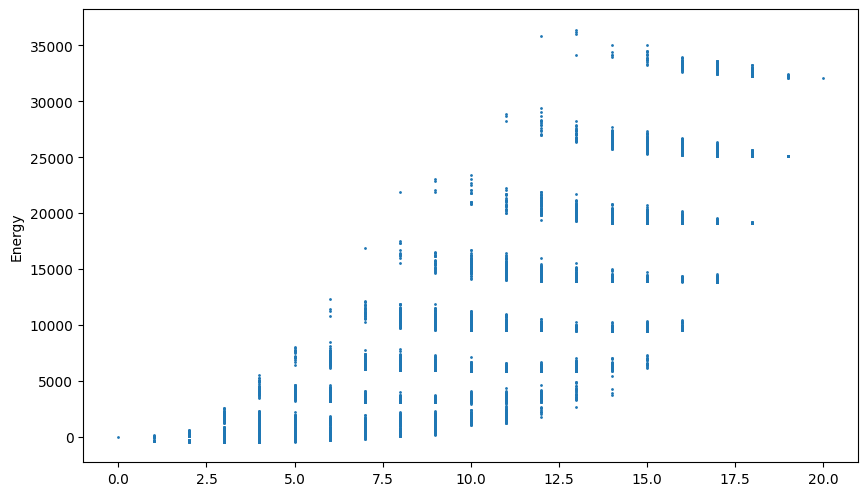

Best found: [2, 4, 7, 19]
count: 4
Energy: -432.0
Solutions Sampled: 15422
[2, 4, 7, 19] -432.0
2 6 2
4 10 3
7 16 5
Items added to Knapsack [2, 4, 7]
Total value: 32
Total weight: 10
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
OK: Condition met 10


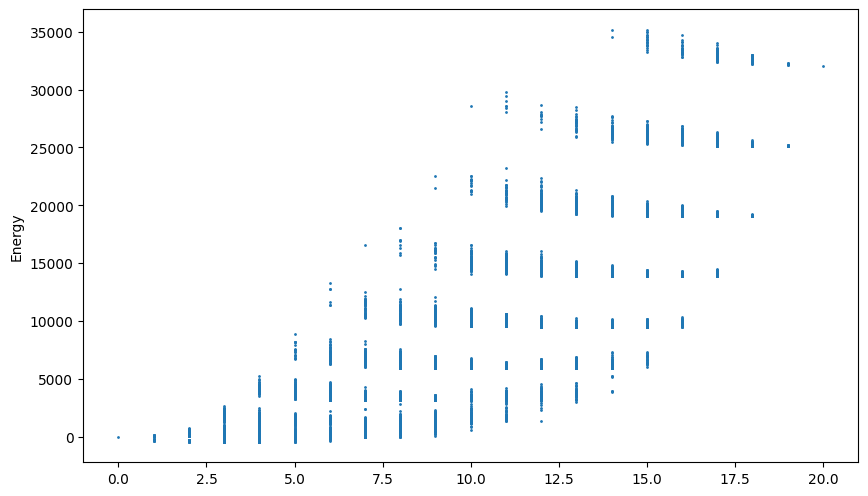

Best found: [3, 4, 7, 19]
count: 4
Energy: -432.0
Solutions Sampled: 15422
[3, 4, 7, 19] -432.0
3 8 3
4 10 3
7 16 5
Items added to Knapsack [3, 4, 7]
Total value: 34
Total weight: 11
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
FAIL: Weight match condition not met 11 10
-------Success!------------
0 [4, 7] Value 26 Wt 8 energy -426.0
1 [0, 4, 7] Value 28 Wt 10 energy -428.0
2 [5, 7] Value 28 Wt 10 energy -428.0
3 [2, 3, 7] Value 30 Wt 10 energy -430.0
4 [5, 7] Value 28 Wt 10 energy -428.0
5 [2, 3, 7] Value 30 Wt 10 energy -430.0
6 [2, 4, 7] Value 32 Wt 10 energy -432.0
7 [5, 7] Value 28 Wt 10 energy -428.0
8 [2, 3, 7] Value 30 Wt 10 energy -430.0
9 [2, 4, 7] Value 32 Wt 10 energy -432.0
10 [5, 7] Value 28 Wt 10 energy -428.0
11 [2, 3, 7] Value 30 Wt 10 energy -430.0
12 [2, 4, 7] Value 32 Wt 10 energy -432.0
13 [2, 3, 7] Value 30 Wt 10 energy -430.0
14 [2, 4, 5] Value 28 Wt 10 energy -428.0
15 [5, 

In [59]:
cond1_fail=0
cond2_fail=0
good_solution=[]
good_value=[]
good_weight=[]
good_energy=[]

count=50
for trial in range (count):

    solution=ProbabilisticSampler(Mf,1000)
    print(solution[0],solution[1])

    # check if constraints were met
    item_list=[]
    Vt=0
    Wt=0
    for i in solution[0]:
        if i <N:
            Vt+=value[i]
            Wt+=weight[i]
            print(i, value[i], weight[i])
            item_list.append(i)
    print('Items added to Knapsack',item_list)
    print('Total value:',Vt)
    print('Total weight:',Wt)

    check_y=0
    weight_list=[]
    for i in solution[0]:
        if i>=N:
            check_y+=1
            weight_list.append(i-N+1)
    print('Condition 1 - Only one weight should be selected.')
    if check_y>1:
        print('FAIL: One weight condition not met', weight_list)
        cond1_fail+=1

    elif check_y==1:
        print('OK: condition met', weight_list)
        print('Condition 2 - Total weight should be equal to weight selected')
        if Wt==weight_list[0]:
            print('OK: Condition met', Wt)
            good_solution.append(item_list)
            good_value.append(Vt)
            good_weight.append(Wt)
            good_energy.append(solution[1])
            
        else:
            print('FAIL: Weight match condition not met', Wt, weight_list[0])
            cond2_fail+=1
    else:
        print('FAIL: No weight was found')


good_count=len(good_value)

if good_count==0:
    print('-------FAIL!------------')
    print('No good values found')
    print('Condition 1: One weight condition failed',(cond1_fail/count)*100, '%')
    print('Condition 2: Weight match condition failed',(cond2_fail/count)*100, '%')
else:
    print('-------Success!------------')
    for i in range(good_count):
        
        print(i, good_solution[i], 'Value', good_value[i],'Wt', good_weight[i], 'energy', good_energy[i])



### Energy returned and on tweaking the multipliers

Create Mf with A=B=C=1

In [51]:
A=1 #ensure only one weight is selected
B=1 # ensure weight matches total weight
C=1   # ensure correct items are selected

Mxf=C*np.array(Mv)+B*np.array(Mx)
print('Mxf',np.shape(Mxf))
Myf=A*np.array(Myc)+B*np.array(My)
print('Myf',np.shape(Myf))
MxyMyf=np.append(B*Mxy, Myf , axis=0) 
print('MxyMyf',np.shape(MxyMyf))
Mxzeros=np.zeros([wc,N],dtype=float)
print('Mxzeros',np.shape(Mxzeros))
Mxflarge=np.append(Mxf, Mxzeros, axis=0)
print('Mxflarge',np.shape(Mxflarge))
Mf=np.append(Mxflarge,MxyMyf, axis=1)
print('Mf',np.shape(Mf))
print(Mf)
np.savetxt('Mf.csv', Mf, delimiter=',')

Mxf (10, 10)
Myf (10, 10)
MxyMyf (20, 10)
Mxzeros (10, 10)
Mxflarge (20, 10)
Mf (20, 20)
[[   2.   12.    8.   12.   12.   20.   24.   20.   32.   36.   -4.   -8.
   -12.  -16.  -20.  -24.  -28.  -32.  -36.  -40.]
 [   0.    5.   12.   18.   18.   30.   36.   30.   48.   54.   -6.  -12.
   -18.  -24.  -30.  -36.  -42.  -48.  -54.  -60.]
 [   0.    0.   -2.   12.   12.   20.   24.   20.   32.   36.   -4.   -8.
   -12.  -16.  -20.  -24.  -28.  -32.  -36.  -40.]
 [   0.    0.    0.    1.   18.   30.   36.   30.   48.   54.   -6.  -12.
   -18.  -24.  -30.  -36.  -42.  -48.  -54.  -60.]
 [   0.    0.    0.    0.   -1.   30.   36.   30.   48.   54.   -6.  -12.
   -18.  -24.  -30.  -36.  -42.  -48.  -54.  -60.]
 [   0.    0.    0.    0.    0.   13.   60.   50.   80.   90.  -10.  -20.
   -30.  -40.  -50.  -60.  -70.  -80.  -90. -100.]
 [   0.    0.    0.    0.    0.    0.   22.   60.   96.  108.  -12.  -24.
   -36.  -48.  -60.  -72.  -84.  -96. -108. -120.]
 [   0.    0.    0.    0.    0.    0

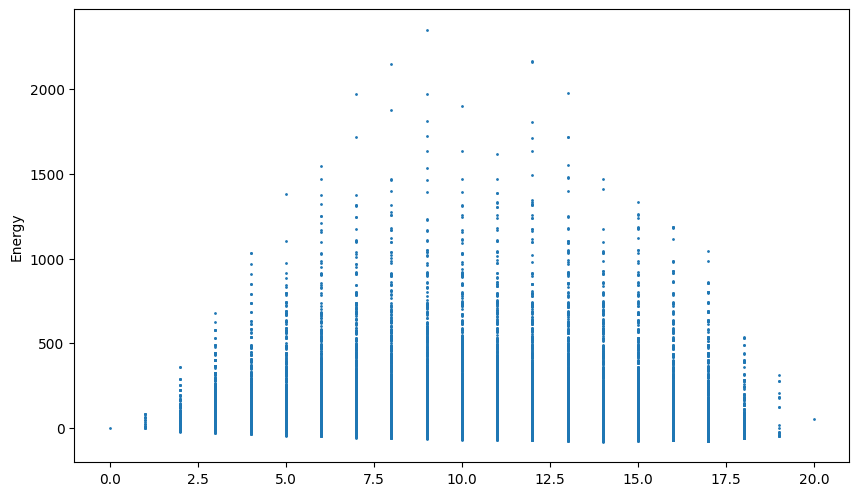

Best found: [0, 1, 2, 3, 4, 5, 7, 8, 9, 15, 16, 17, 18, 19]
count: 14
Energy: -81.0
Solutions Sampled: 15422
[0, 1, 2, 3, 4, 5, 7, 8, 9, 15, 16, 17, 18, 19] -81.0
0 2 2
1 4 3
2 6 2
3 8 3
4 10 3
5 12 5
7 16 5
8 18 8
9 20 9
Items added to Knapsack [0, 1, 2, 3, 4, 5, 7, 8, 9]
Total value: 96
Total weight: 40
Condition 1 - Only one weight should be selected.
FAIL: One weight condition not met [6, 7, 8, 9, 10]


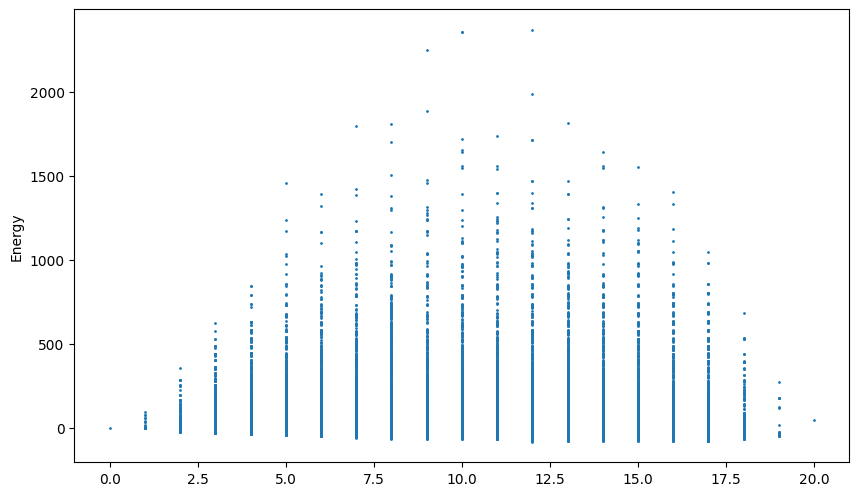

Best found: [2, 4, 5, 6, 7, 8, 9, 14, 16, 17, 18, 19]
count: 12
Energy: -80.0
Solutions Sampled: 15422
[2, 4, 5, 6, 7, 8, 9, 14, 16, 17, 18, 19] -80.0
2 6 2
4 10 3
5 12 5
6 14 6
7 16 5
8 18 8
9 20 9
Items added to Knapsack [2, 4, 5, 6, 7, 8, 9]
Total value: 96
Total weight: 38
Condition 1 - Only one weight should be selected.
FAIL: One weight condition not met [5, 7, 8, 9, 10]


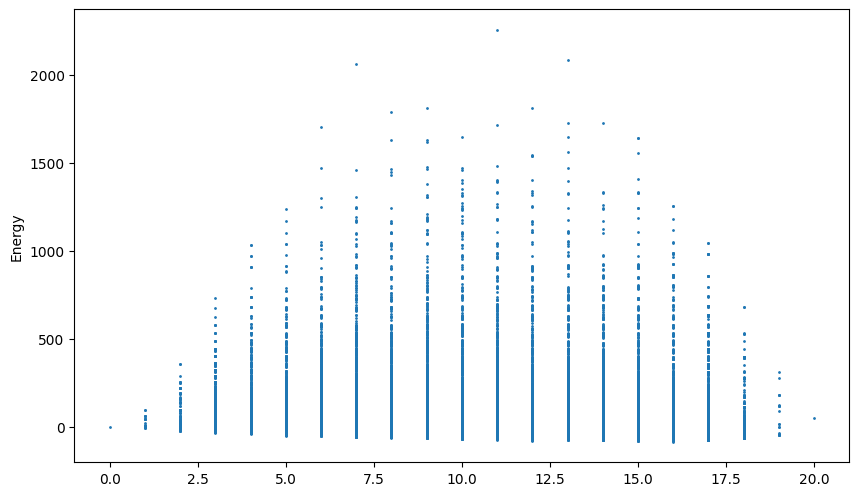

Best found: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 13, 15, 16, 17, 18, 19]
count: 16
Energy: -82.0
Solutions Sampled: 15422
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 13, 15, 16, 17, 18, 19] -82.0
0 2 2
1 4 3
2 6 2
3 8 3
4 10 3
5 12 5
6 14 6
7 16 5
8 18 8
9 20 9
Items added to Knapsack [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Total value: 110
Total weight: 46
Condition 1 - Only one weight should be selected.
FAIL: One weight condition not met [4, 6, 7, 8, 9, 10]


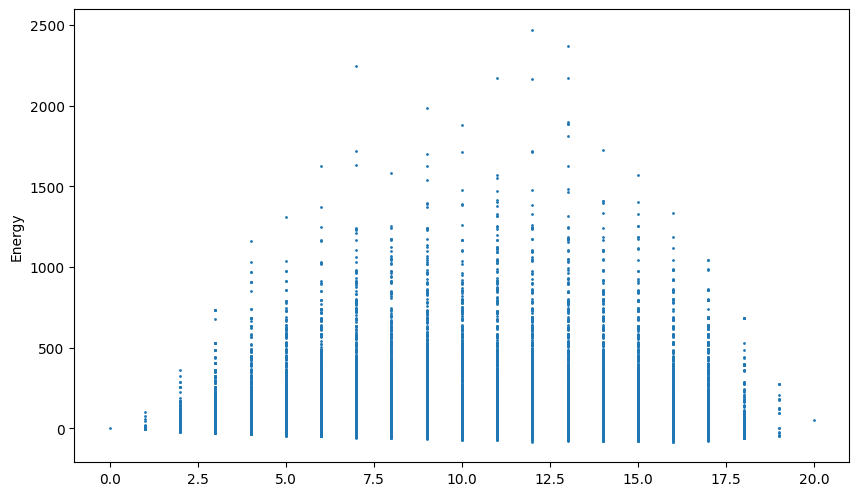

Best found: [3, 4, 5, 6, 7, 8, 9, 14, 15, 17, 18, 19]
count: 12
Energy: -82.0
Solutions Sampled: 15422
[3, 4, 5, 6, 7, 8, 9, 14, 15, 17, 18, 19] -82.0
3 8 3
4 10 3
5 12 5
6 14 6
7 16 5
8 18 8
9 20 9
Items added to Knapsack [3, 4, 5, 6, 7, 8, 9]
Total value: 98
Total weight: 39
Condition 1 - Only one weight should be selected.
FAIL: One weight condition not met [5, 6, 8, 9, 10]


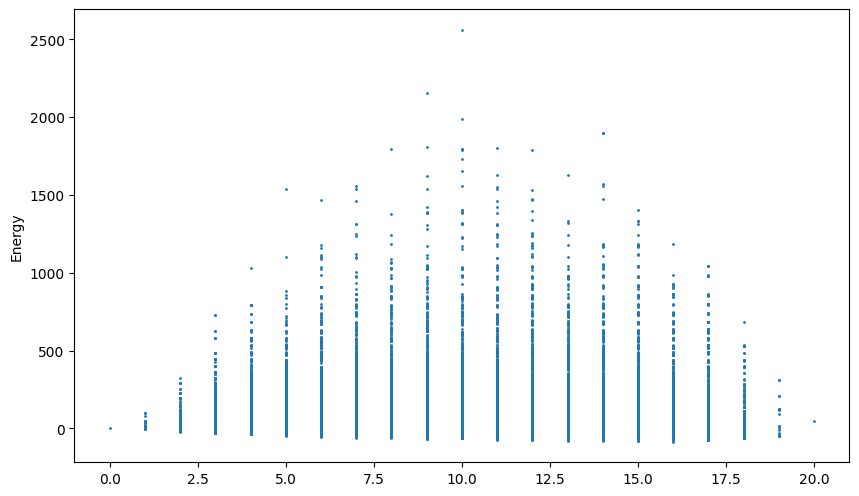

Best found: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 14, 15, 16, 17, 18, 19]
count: 16
Energy: -85.0
Solutions Sampled: 15422
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 14, 15, 16, 17, 18, 19] -85.0
0 2 2
1 4 3
2 6 2
3 8 3
4 10 3
5 12 5
6 14 6
7 16 5
8 18 8
9 20 9
Items added to Knapsack [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Total value: 110
Total weight: 46
Condition 1 - Only one weight should be selected.
FAIL: One weight condition not met [5, 6, 7, 8, 9, 10]


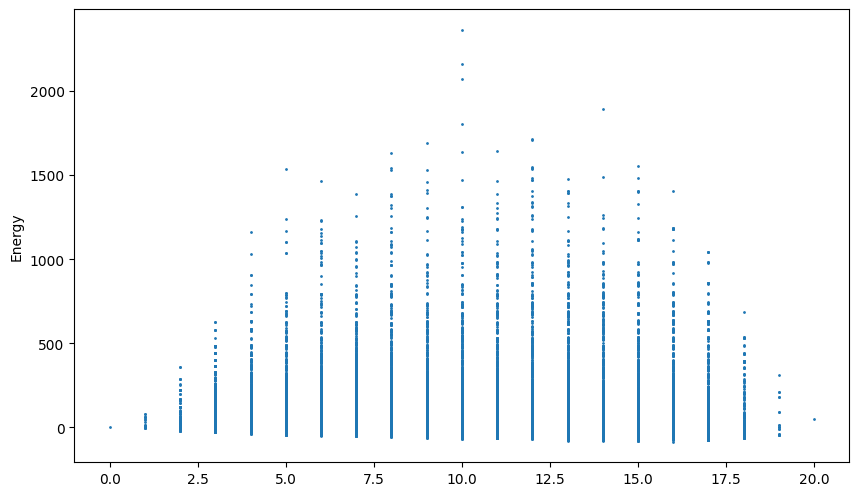

Best found: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 14, 15, 16, 17, 18, 19]
count: 16
Energy: -85.0
Solutions Sampled: 15422
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 14, 15, 16, 17, 18, 19] -85.0
0 2 2
1 4 3
2 6 2
3 8 3
4 10 3
5 12 5
6 14 6
7 16 5
8 18 8
9 20 9
Items added to Knapsack [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Total value: 110
Total weight: 46
Condition 1 - Only one weight should be selected.
FAIL: One weight condition not met [5, 6, 7, 8, 9, 10]


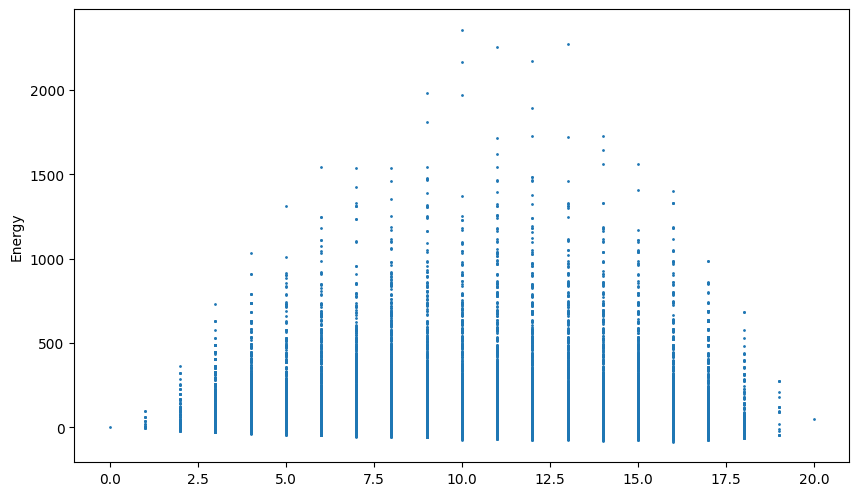

Best found: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 14, 15, 16, 17, 18, 19]
count: 16
Energy: -85.0
Solutions Sampled: 15422
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 14, 15, 16, 17, 18, 19] -85.0
0 2 2
1 4 3
2 6 2
3 8 3
4 10 3
5 12 5
6 14 6
7 16 5
8 18 8
9 20 9
Items added to Knapsack [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Total value: 110
Total weight: 46
Condition 1 - Only one weight should be selected.
FAIL: One weight condition not met [5, 6, 7, 8, 9, 10]


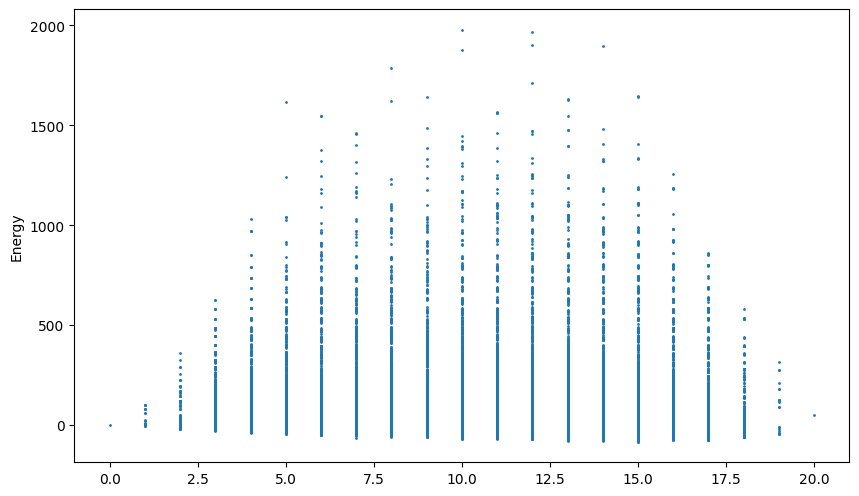

Best found: [1, 2, 3, 4, 5, 6, 7, 8, 9, 14, 15, 16, 17, 18, 19]
count: 15
Energy: -83.0
Solutions Sampled: 15422
[1, 2, 3, 4, 5, 6, 7, 8, 9, 14, 15, 16, 17, 18, 19] -83.0
1 4 3
2 6 2
3 8 3
4 10 3
5 12 5
6 14 6
7 16 5
8 18 8
9 20 9
Items added to Knapsack [1, 2, 3, 4, 5, 6, 7, 8, 9]
Total value: 108
Total weight: 44
Condition 1 - Only one weight should be selected.
FAIL: One weight condition not met [5, 6, 7, 8, 9, 10]


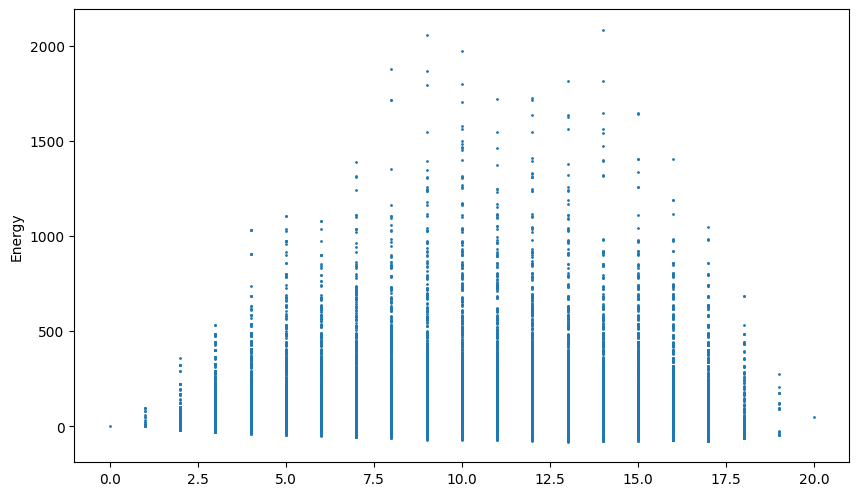

Best found: [0, 2, 3, 5, 6, 7, 8, 9, 14, 16, 17, 18, 19]
count: 13
Energy: -80.0
Solutions Sampled: 15422
[0, 2, 3, 5, 6, 7, 8, 9, 14, 16, 17, 18, 19] -80.0
0 2 2
2 6 2
3 8 3
5 12 5
6 14 6
7 16 5
8 18 8
9 20 9
Items added to Knapsack [0, 2, 3, 5, 6, 7, 8, 9]
Total value: 96
Total weight: 40
Condition 1 - Only one weight should be selected.
FAIL: One weight condition not met [5, 7, 8, 9, 10]


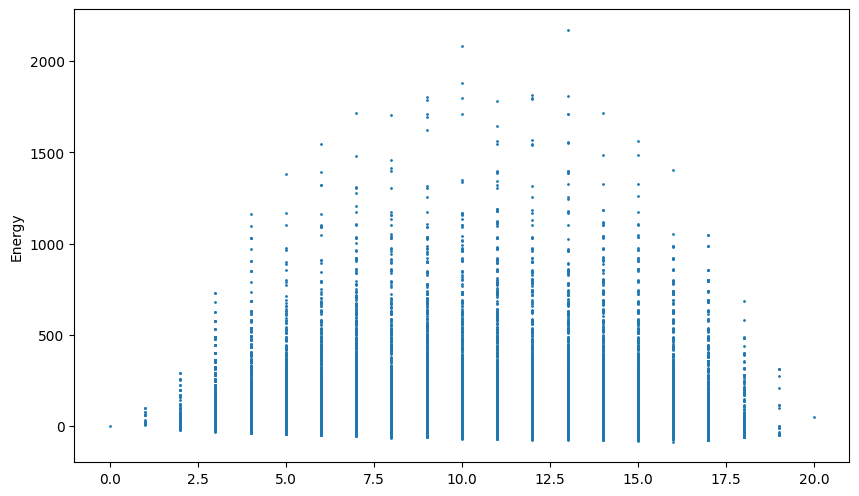

Best found: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 14, 15, 16, 17, 18, 19]
count: 16
Energy: -85.0
Solutions Sampled: 15422
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 14, 15, 16, 17, 18, 19] -85.0
0 2 2
1 4 3
2 6 2
3 8 3
4 10 3
5 12 5
6 14 6
7 16 5
8 18 8
9 20 9
Items added to Knapsack [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Total value: 110
Total weight: 46
Condition 1 - Only one weight should be selected.
FAIL: One weight condition not met [5, 6, 7, 8, 9, 10]


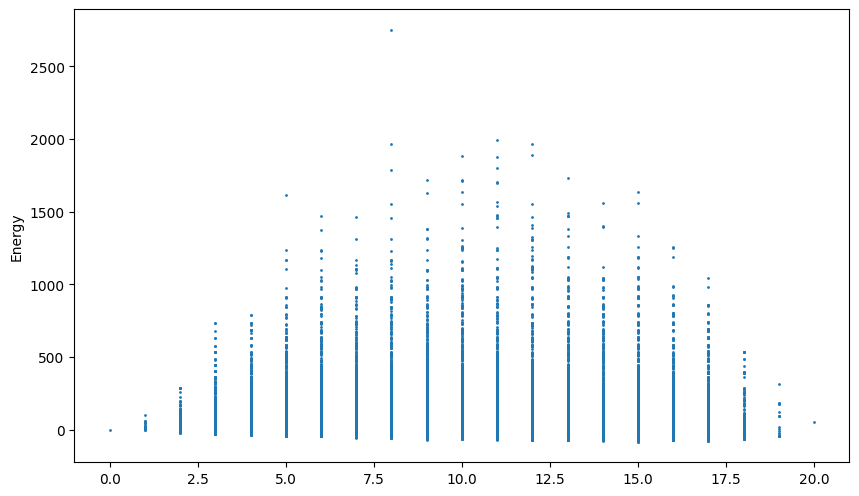

Best found: [1, 2, 3, 4, 5, 6, 7, 8, 9, 13, 14, 16, 17, 18, 19]
count: 15
Energy: -83.0
Solutions Sampled: 15422
[1, 2, 3, 4, 5, 6, 7, 8, 9, 13, 14, 16, 17, 18, 19] -83.0
1 4 3
2 6 2
3 8 3
4 10 3
5 12 5
6 14 6
7 16 5
8 18 8
9 20 9
Items added to Knapsack [1, 2, 3, 4, 5, 6, 7, 8, 9]
Total value: 108
Total weight: 44
Condition 1 - Only one weight should be selected.
FAIL: One weight condition not met [4, 5, 7, 8, 9, 10]


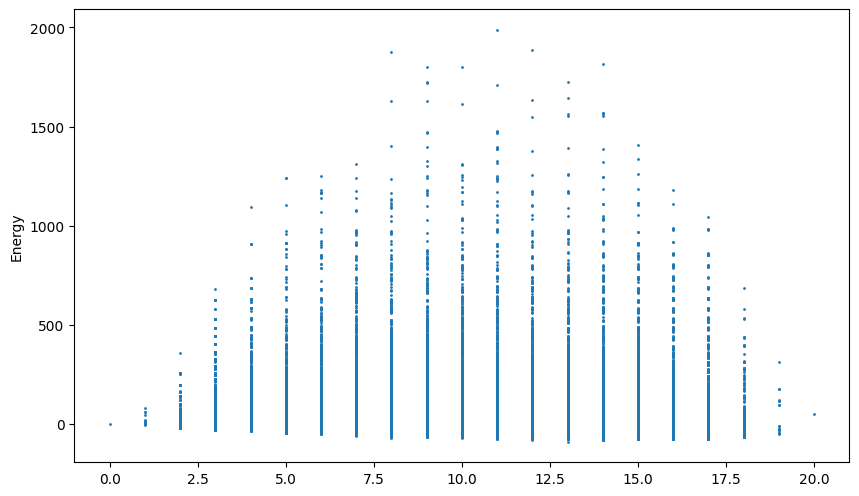

Best found: [2, 3, 4, 5, 6, 7, 8, 9, 15, 16, 17, 18, 19]
count: 13
Energy: -88.0
Solutions Sampled: 15422
[2, 3, 4, 5, 6, 7, 8, 9, 15, 16, 17, 18, 19] -88.0
2 6 2
3 8 3
4 10 3
5 12 5
6 14 6
7 16 5
8 18 8
9 20 9
Items added to Knapsack [2, 3, 4, 5, 6, 7, 8, 9]
Total value: 104
Total weight: 41
Condition 1 - Only one weight should be selected.
FAIL: One weight condition not met [6, 7, 8, 9, 10]


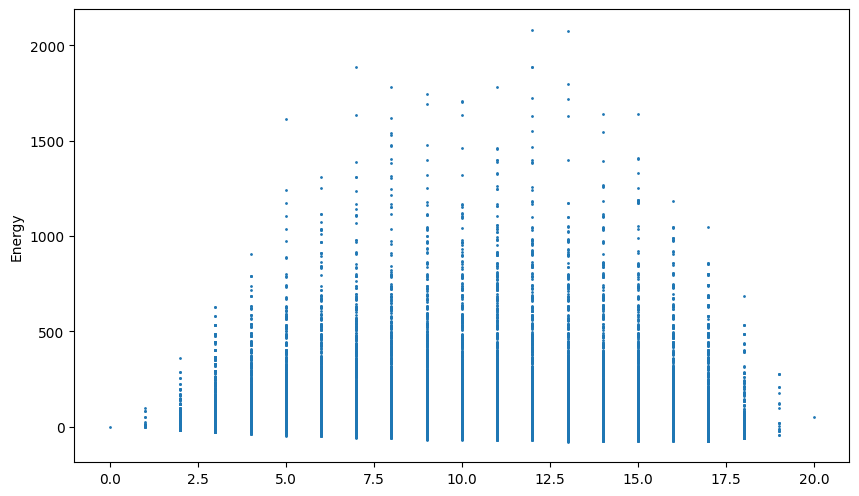

Best found: [0, 2, 3, 4, 6, 7, 8, 9, 14, 15, 17, 18, 19]
count: 13
Energy: -79.0
Solutions Sampled: 15422
[0, 2, 3, 4, 6, 7, 8, 9, 14, 15, 17, 18, 19] -79.0
0 2 2
2 6 2
3 8 3
4 10 3
6 14 6
7 16 5
8 18 8
9 20 9
Items added to Knapsack [0, 2, 3, 4, 6, 7, 8, 9]
Total value: 94
Total weight: 38
Condition 1 - Only one weight should be selected.
FAIL: One weight condition not met [5, 6, 8, 9, 10]


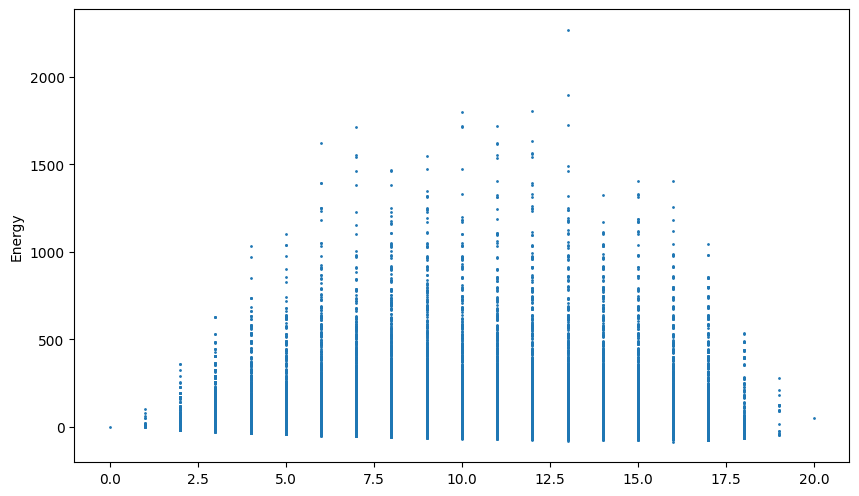

Best found: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 14, 15, 16, 17, 18, 19]
count: 16
Energy: -85.0
Solutions Sampled: 15422
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 14, 15, 16, 17, 18, 19] -85.0
0 2 2
1 4 3
2 6 2
3 8 3
4 10 3
5 12 5
6 14 6
7 16 5
8 18 8
9 20 9
Items added to Knapsack [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Total value: 110
Total weight: 46
Condition 1 - Only one weight should be selected.
FAIL: One weight condition not met [5, 6, 7, 8, 9, 10]


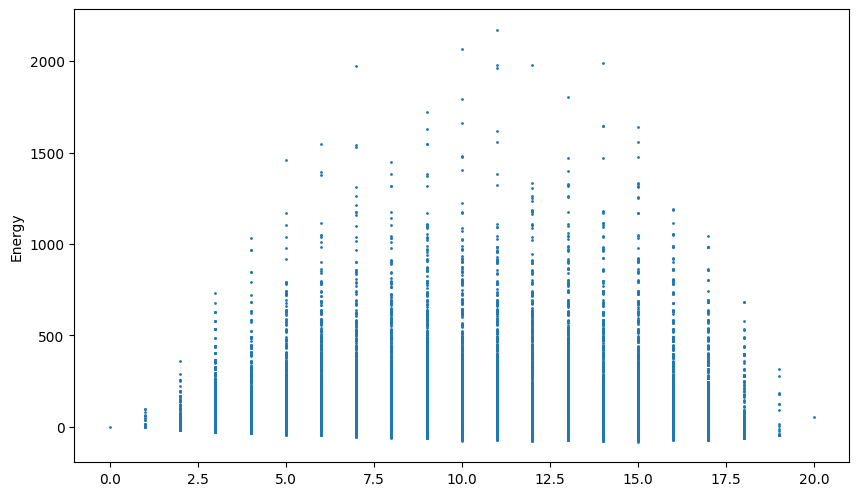

Best found: [0, 2, 3, 4, 5, 6, 7, 8, 9, 13, 14, 16, 17, 18, 19]
count: 15
Energy: -82.0
Solutions Sampled: 15422
[0, 2, 3, 4, 5, 6, 7, 8, 9, 13, 14, 16, 17, 18, 19] -82.0
0 2 2
2 6 2
3 8 3
4 10 3
5 12 5
6 14 6
7 16 5
8 18 8
9 20 9
Items added to Knapsack [0, 2, 3, 4, 5, 6, 7, 8, 9]
Total value: 106
Total weight: 43
Condition 1 - Only one weight should be selected.
FAIL: One weight condition not met [4, 5, 7, 8, 9, 10]


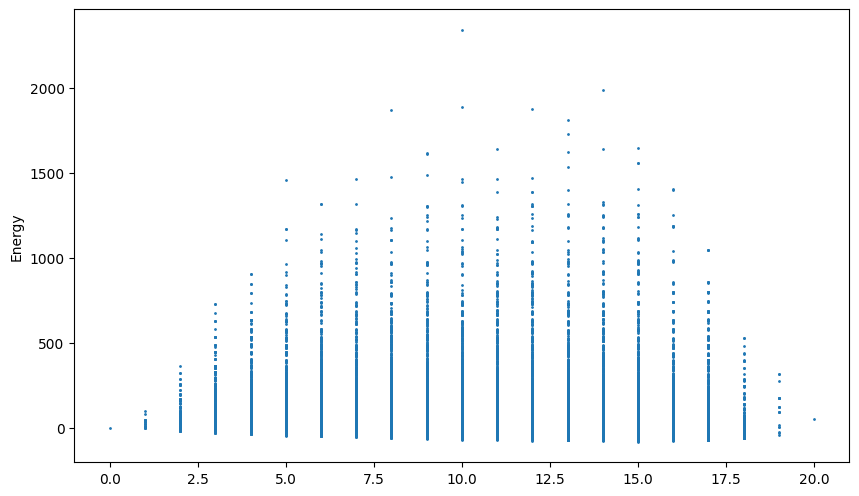

Best found: [0, 2, 3, 4, 5, 6, 7, 8, 9, 13, 14, 16, 17, 18, 19]
count: 15
Energy: -82.0
Solutions Sampled: 15422
[0, 2, 3, 4, 5, 6, 7, 8, 9, 13, 14, 16, 17, 18, 19] -82.0
0 2 2
2 6 2
3 8 3
4 10 3
5 12 5
6 14 6
7 16 5
8 18 8
9 20 9
Items added to Knapsack [0, 2, 3, 4, 5, 6, 7, 8, 9]
Total value: 106
Total weight: 43
Condition 1 - Only one weight should be selected.
FAIL: One weight condition not met [4, 5, 7, 8, 9, 10]


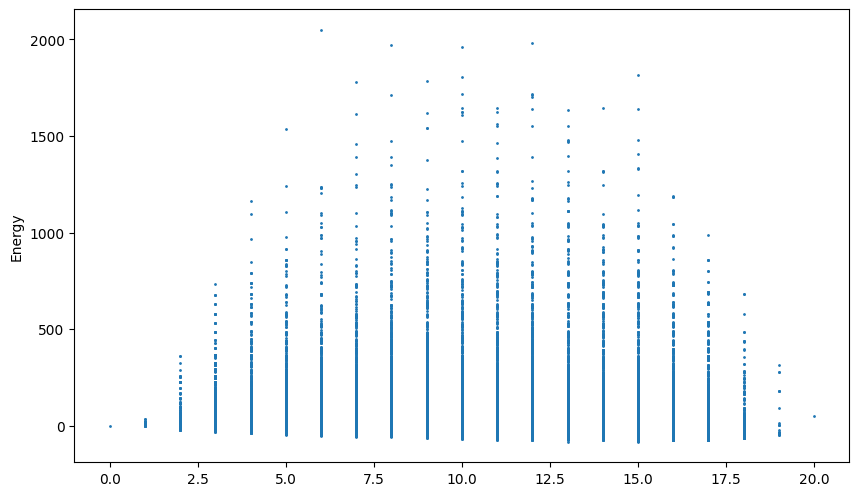

Best found: [1, 2, 3, 5, 6, 7, 8, 9, 15, 16, 17, 18, 19]
count: 13
Energy: -82.0
Solutions Sampled: 15422
[1, 2, 3, 5, 6, 7, 8, 9, 15, 16, 17, 18, 19] -82.0
1 4 3
2 6 2
3 8 3
5 12 5
6 14 6
7 16 5
8 18 8
9 20 9
Items added to Knapsack [1, 2, 3, 5, 6, 7, 8, 9]
Total value: 98
Total weight: 41
Condition 1 - Only one weight should be selected.
FAIL: One weight condition not met [6, 7, 8, 9, 10]


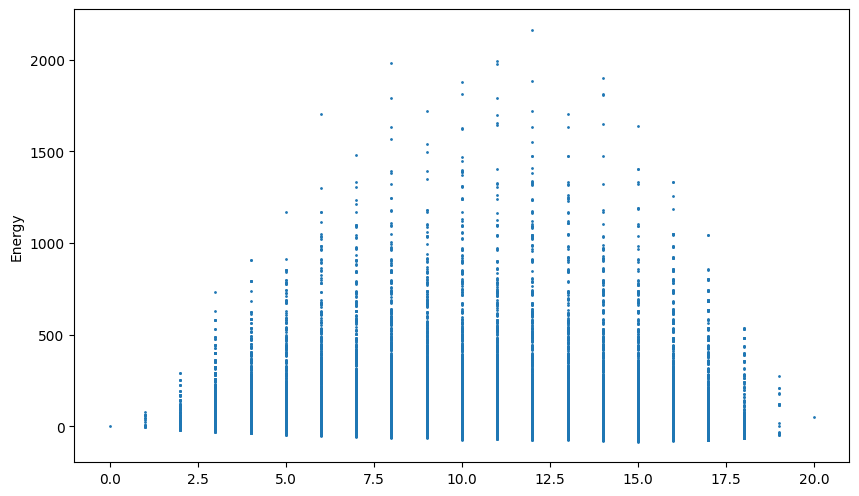

Best found: [1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 15, 16, 17, 18, 19]
count: 15
Energy: -83.0
Solutions Sampled: 15422
[1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 15, 16, 17, 18, 19] -83.0
1 4 3
2 6 2
3 8 3
4 10 3
5 12 5
6 14 6
7 16 5
8 18 8
9 20 9
Items added to Knapsack [1, 2, 3, 4, 5, 6, 7, 8, 9]
Total value: 108
Total weight: 44
Condition 1 - Only one weight should be selected.
FAIL: One weight condition not met [3, 6, 7, 8, 9, 10]


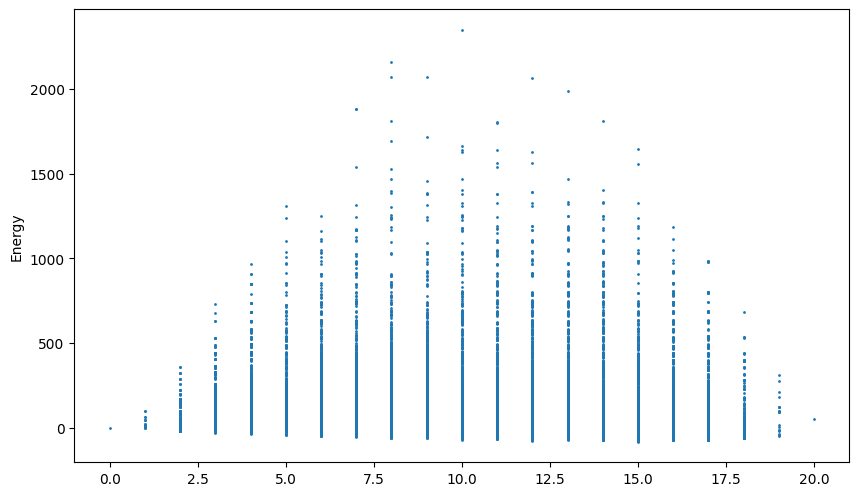

Best found: [1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 15, 16, 17, 18, 19]
count: 15
Energy: -83.0
Solutions Sampled: 15422
[1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 15, 16, 17, 18, 19] -83.0
1 4 3
2 6 2
3 8 3
4 10 3
5 12 5
6 14 6
7 16 5
8 18 8
9 20 9
Items added to Knapsack [1, 2, 3, 4, 5, 6, 7, 8, 9]
Total value: 108
Total weight: 44
Condition 1 - Only one weight should be selected.
FAIL: One weight condition not met [3, 6, 7, 8, 9, 10]


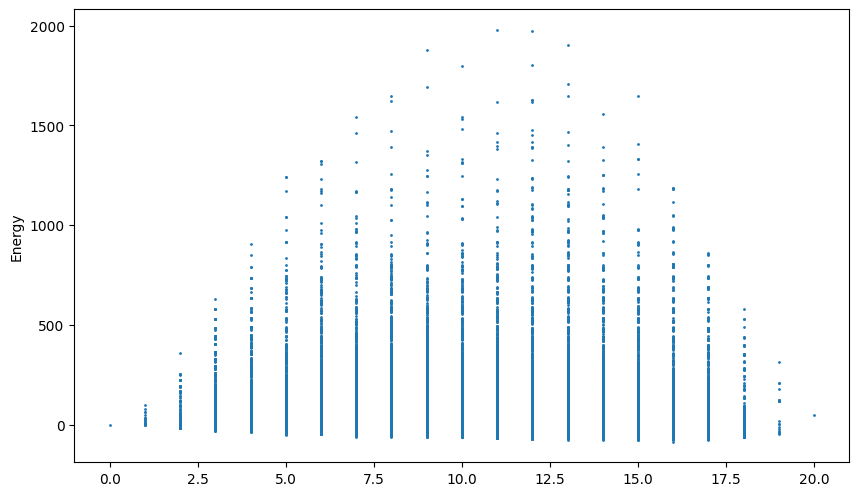

Best found: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 14, 15, 16, 17, 18, 19]
count: 16
Energy: -85.0
Solutions Sampled: 15422
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 14, 15, 16, 17, 18, 19] -85.0
0 2 2
1 4 3
2 6 2
3 8 3
4 10 3
5 12 5
6 14 6
7 16 5
8 18 8
9 20 9
Items added to Knapsack [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Total value: 110
Total weight: 46
Condition 1 - Only one weight should be selected.
FAIL: One weight condition not met [5, 6, 7, 8, 9, 10]


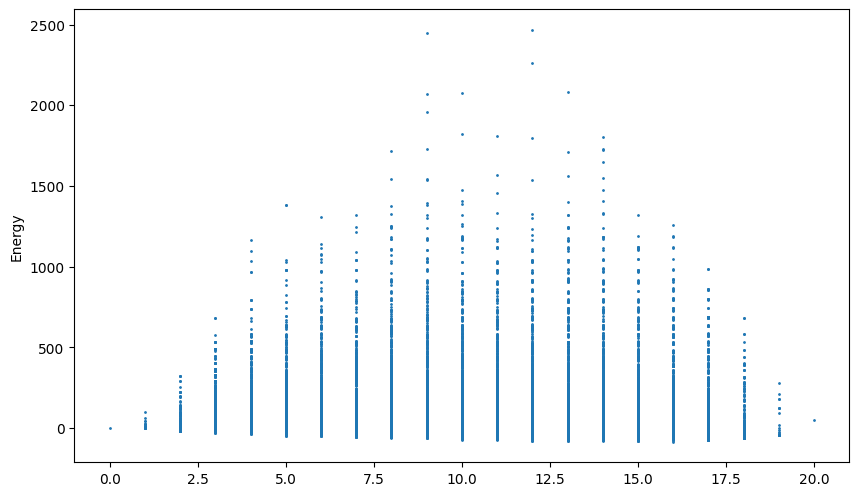

Best found: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 14, 15, 16, 17, 18, 19]
count: 16
Energy: -85.0
Solutions Sampled: 15422
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 14, 15, 16, 17, 18, 19] -85.0
0 2 2
1 4 3
2 6 2
3 8 3
4 10 3
5 12 5
6 14 6
7 16 5
8 18 8
9 20 9
Items added to Knapsack [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Total value: 110
Total weight: 46
Condition 1 - Only one weight should be selected.
FAIL: One weight condition not met [5, 6, 7, 8, 9, 10]


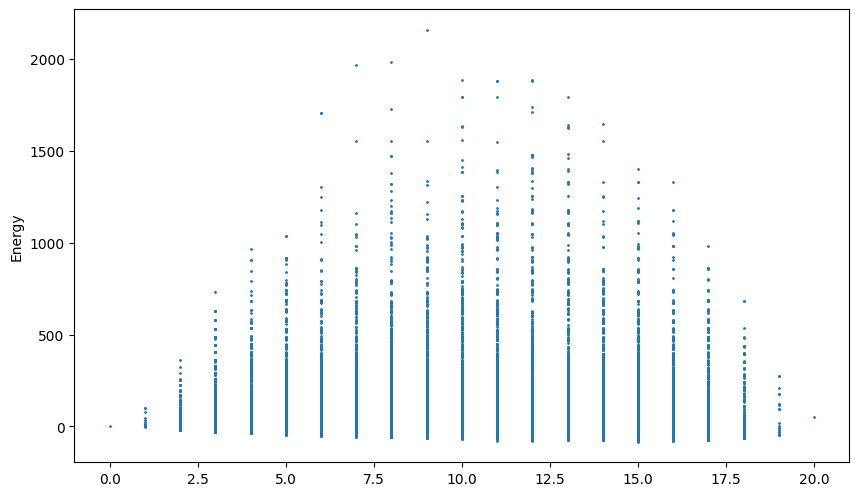

Best found: [1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 15, 16, 17, 18, 19]
count: 15
Energy: -83.0
Solutions Sampled: 15422
[1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 15, 16, 17, 18, 19] -83.0
1 4 3
2 6 2
3 8 3
4 10 3
5 12 5
6 14 6
7 16 5
8 18 8
9 20 9
Items added to Knapsack [1, 2, 3, 4, 5, 6, 7, 8, 9]
Total value: 108
Total weight: 44
Condition 1 - Only one weight should be selected.
FAIL: One weight condition not met [3, 6, 7, 8, 9, 10]


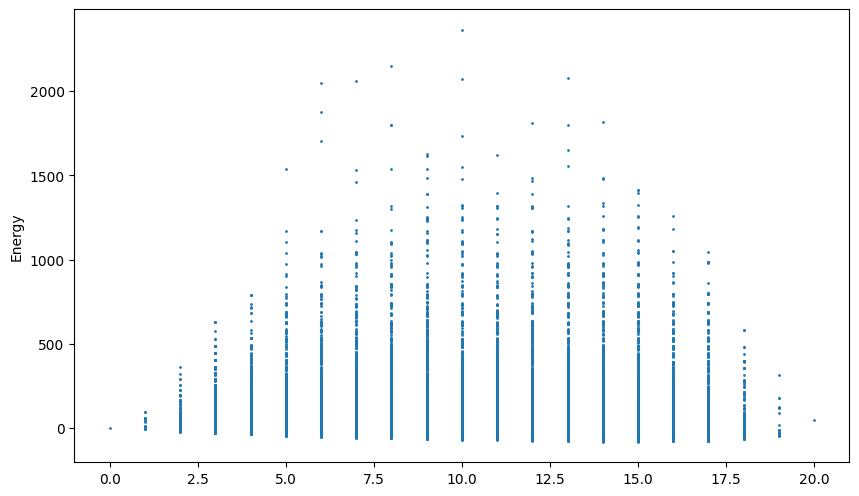

Best found: [1, 2, 3, 4, 5, 6, 7, 8, 9, 13, 14, 15, 17, 18, 19]
count: 15
Energy: -80.0
Solutions Sampled: 15422
[1, 2, 3, 4, 5, 6, 7, 8, 9, 13, 14, 15, 17, 18, 19] -80.0
1 4 3
2 6 2
3 8 3
4 10 3
5 12 5
6 14 6
7 16 5
8 18 8
9 20 9
Items added to Knapsack [1, 2, 3, 4, 5, 6, 7, 8, 9]
Total value: 108
Total weight: 44
Condition 1 - Only one weight should be selected.
FAIL: One weight condition not met [4, 5, 6, 8, 9, 10]


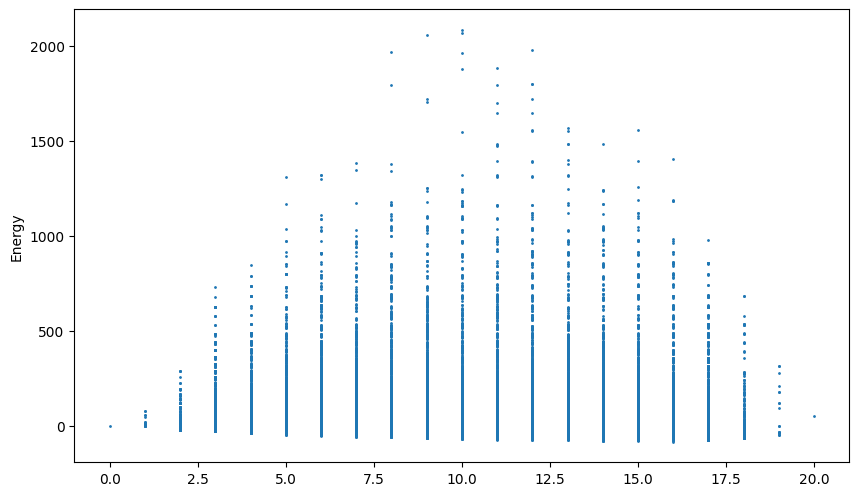

Best found: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 13, 15, 16, 17, 18, 19]
count: 16
Energy: -82.0
Solutions Sampled: 15422
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 13, 15, 16, 17, 18, 19] -82.0
0 2 2
1 4 3
2 6 2
3 8 3
4 10 3
5 12 5
6 14 6
7 16 5
8 18 8
9 20 9
Items added to Knapsack [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Total value: 110
Total weight: 46
Condition 1 - Only one weight should be selected.
FAIL: One weight condition not met [4, 6, 7, 8, 9, 10]


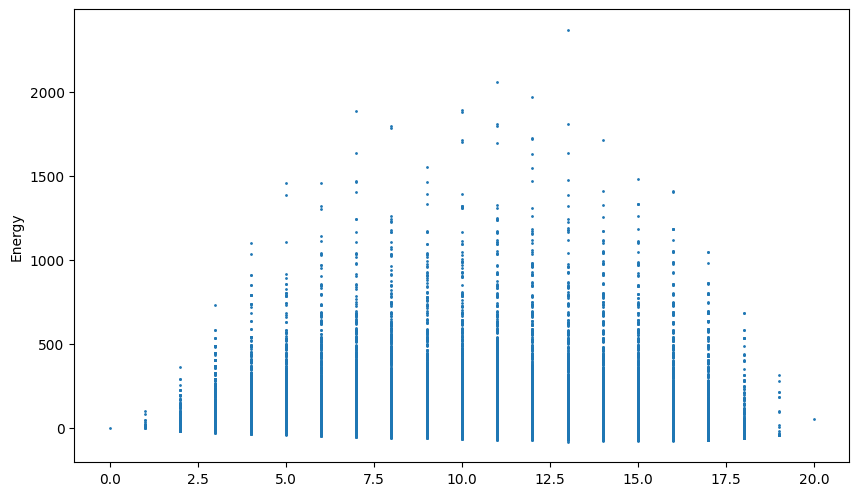

Best found: [1, 2, 4, 5, 6, 7, 8, 9, 15, 16, 17, 18, 19]
count: 13
Energy: -84.0
Solutions Sampled: 15422
[1, 2, 4, 5, 6, 7, 8, 9, 15, 16, 17, 18, 19] -84.0
1 4 3
2 6 2
4 10 3
5 12 5
6 14 6
7 16 5
8 18 8
9 20 9
Items added to Knapsack [1, 2, 4, 5, 6, 7, 8, 9]
Total value: 100
Total weight: 41
Condition 1 - Only one weight should be selected.
FAIL: One weight condition not met [6, 7, 8, 9, 10]


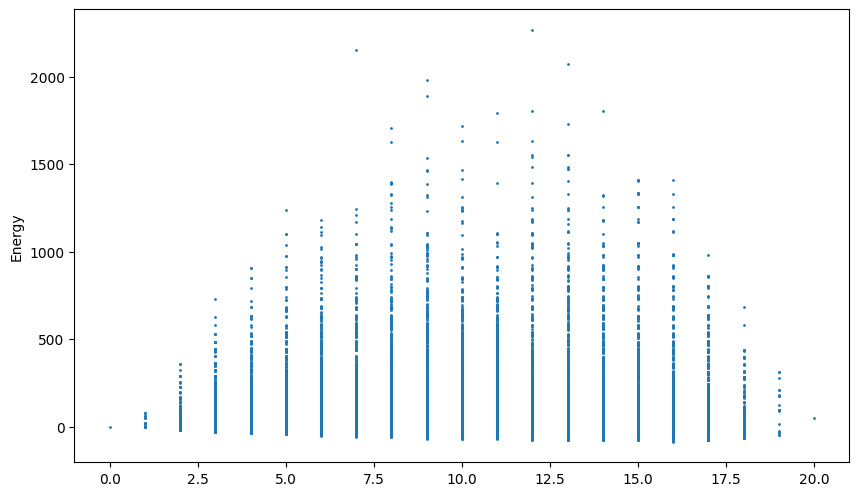

Best found: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 14, 15, 16, 17, 18, 19]
count: 16
Energy: -85.0
Solutions Sampled: 15422
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 14, 15, 16, 17, 18, 19] -85.0
0 2 2
1 4 3
2 6 2
3 8 3
4 10 3
5 12 5
6 14 6
7 16 5
8 18 8
9 20 9
Items added to Knapsack [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Total value: 110
Total weight: 46
Condition 1 - Only one weight should be selected.
FAIL: One weight condition not met [5, 6, 7, 8, 9, 10]


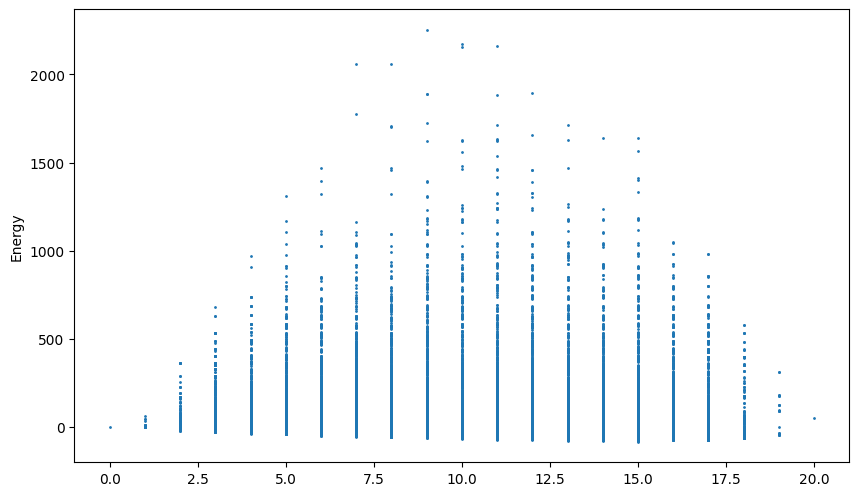

Best found: [1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 15, 16, 17, 18, 19]
count: 15
Energy: -83.0
Solutions Sampled: 15422
[1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 15, 16, 17, 18, 19] -83.0
1 4 3
2 6 2
3 8 3
4 10 3
5 12 5
6 14 6
7 16 5
8 18 8
9 20 9
Items added to Knapsack [1, 2, 3, 4, 5, 6, 7, 8, 9]
Total value: 108
Total weight: 44
Condition 1 - Only one weight should be selected.
FAIL: One weight condition not met [3, 6, 7, 8, 9, 10]


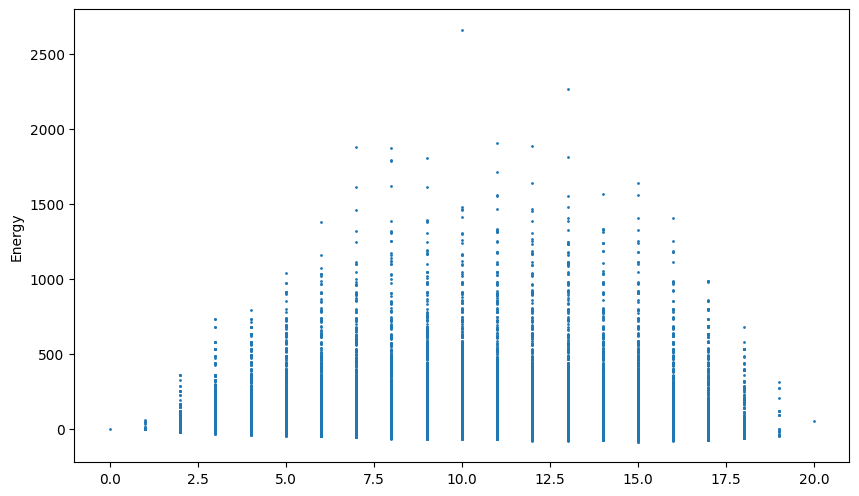

Best found: [1, 2, 3, 4, 5, 6, 7, 8, 9, 13, 15, 16, 17, 18, 19]
count: 15
Energy: -84.0
Solutions Sampled: 15422
[1, 2, 3, 4, 5, 6, 7, 8, 9, 13, 15, 16, 17, 18, 19] -84.0
1 4 3
2 6 2
3 8 3
4 10 3
5 12 5
6 14 6
7 16 5
8 18 8
9 20 9
Items added to Knapsack [1, 2, 3, 4, 5, 6, 7, 8, 9]
Total value: 108
Total weight: 44
Condition 1 - Only one weight should be selected.
FAIL: One weight condition not met [4, 6, 7, 8, 9, 10]


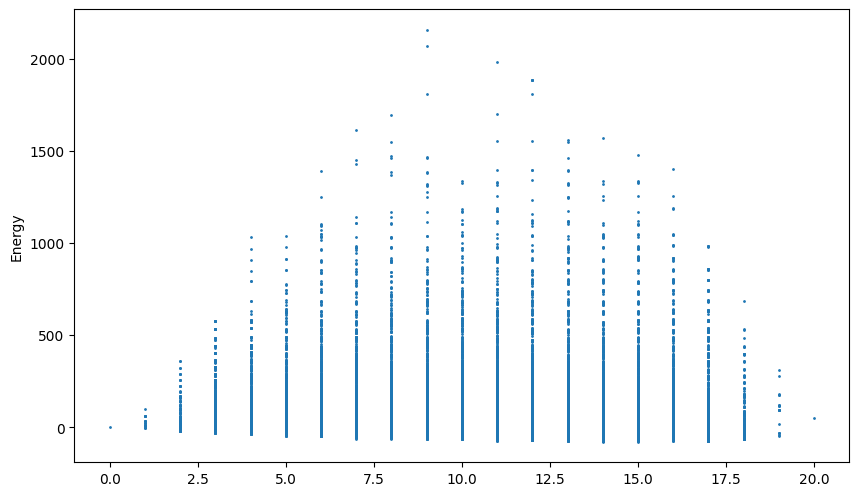

Best found: [0, 1, 2, 4, 5, 6, 7, 8, 9, 13, 14, 15, 17, 18, 19]
count: 15
Energy: -77.0
Solutions Sampled: 15422
[0, 1, 2, 4, 5, 6, 7, 8, 9, 13, 14, 15, 17, 18, 19] -77.0
0 2 2
1 4 3
2 6 2
4 10 3
5 12 5
6 14 6
7 16 5
8 18 8
9 20 9
Items added to Knapsack [0, 1, 2, 4, 5, 6, 7, 8, 9]
Total value: 102
Total weight: 43
Condition 1 - Only one weight should be selected.
FAIL: One weight condition not met [4, 5, 6, 8, 9, 10]


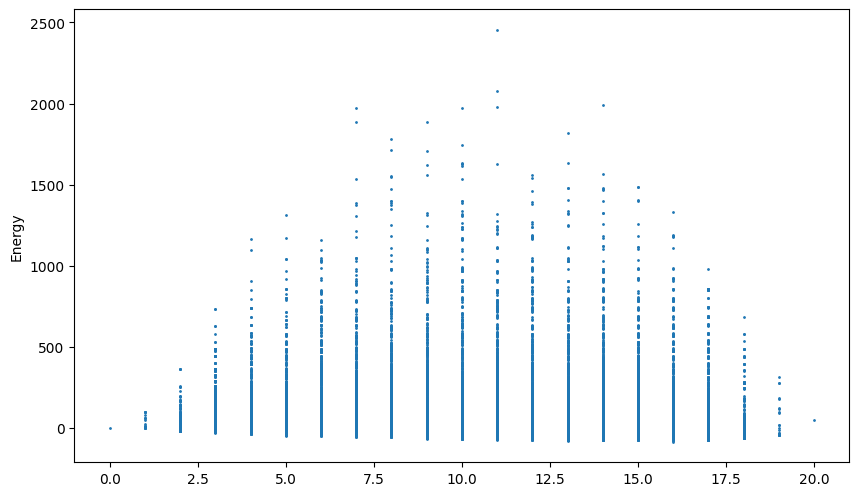

Best found: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 14, 15, 16, 17, 18, 19]
count: 16
Energy: -85.0
Solutions Sampled: 15422
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 14, 15, 16, 17, 18, 19] -85.0
0 2 2
1 4 3
2 6 2
3 8 3
4 10 3
5 12 5
6 14 6
7 16 5
8 18 8
9 20 9
Items added to Knapsack [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Total value: 110
Total weight: 46
Condition 1 - Only one weight should be selected.
FAIL: One weight condition not met [5, 6, 7, 8, 9, 10]


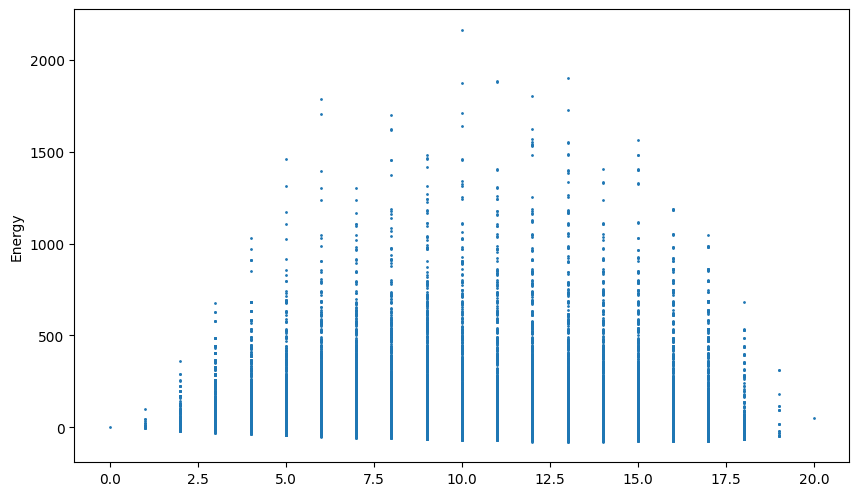

Best found: [0, 2, 3, 4, 6, 7, 8, 9, 14, 16, 17, 18, 19]
count: 13
Energy: -78.0
Solutions Sampled: 15422
[0, 2, 3, 4, 6, 7, 8, 9, 14, 16, 17, 18, 19] -78.0
0 2 2
2 6 2
3 8 3
4 10 3
6 14 6
7 16 5
8 18 8
9 20 9
Items added to Knapsack [0, 2, 3, 4, 6, 7, 8, 9]
Total value: 94
Total weight: 38
Condition 1 - Only one weight should be selected.
FAIL: One weight condition not met [5, 7, 8, 9, 10]


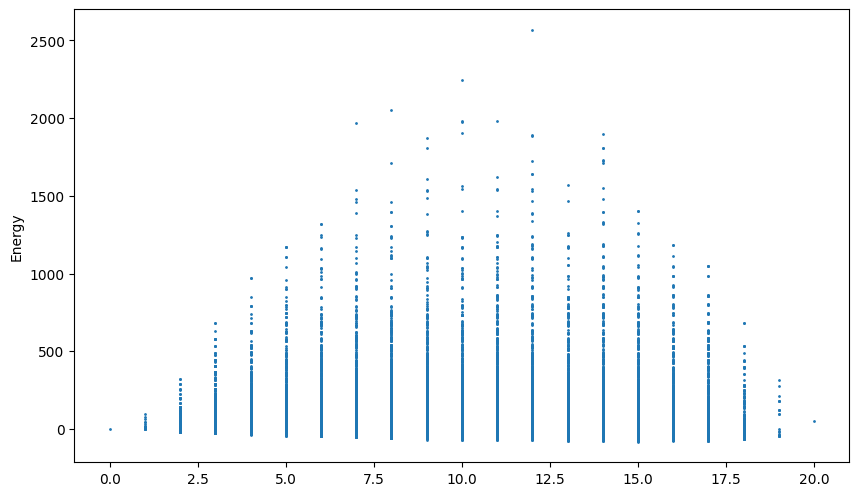

Best found: [0, 2, 3, 4, 5, 6, 7, 8, 9, 13, 14, 16, 17, 18, 19]
count: 15
Energy: -82.0
Solutions Sampled: 15422
[0, 2, 3, 4, 5, 6, 7, 8, 9, 13, 14, 16, 17, 18, 19] -82.0
0 2 2
2 6 2
3 8 3
4 10 3
5 12 5
6 14 6
7 16 5
8 18 8
9 20 9
Items added to Knapsack [0, 2, 3, 4, 5, 6, 7, 8, 9]
Total value: 106
Total weight: 43
Condition 1 - Only one weight should be selected.
FAIL: One weight condition not met [4, 5, 7, 8, 9, 10]


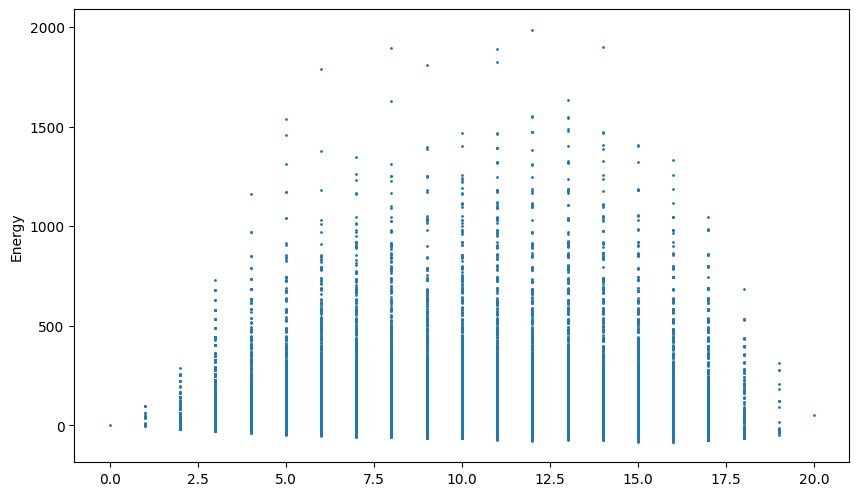

Best found: [0, 2, 3, 4, 5, 6, 7, 8, 9, 13, 14, 16, 17, 18, 19]
count: 15
Energy: -82.0
Solutions Sampled: 15422
[0, 2, 3, 4, 5, 6, 7, 8, 9, 13, 14, 16, 17, 18, 19] -82.0
0 2 2
2 6 2
3 8 3
4 10 3
5 12 5
6 14 6
7 16 5
8 18 8
9 20 9
Items added to Knapsack [0, 2, 3, 4, 5, 6, 7, 8, 9]
Total value: 106
Total weight: 43
Condition 1 - Only one weight should be selected.
FAIL: One weight condition not met [4, 5, 7, 8, 9, 10]


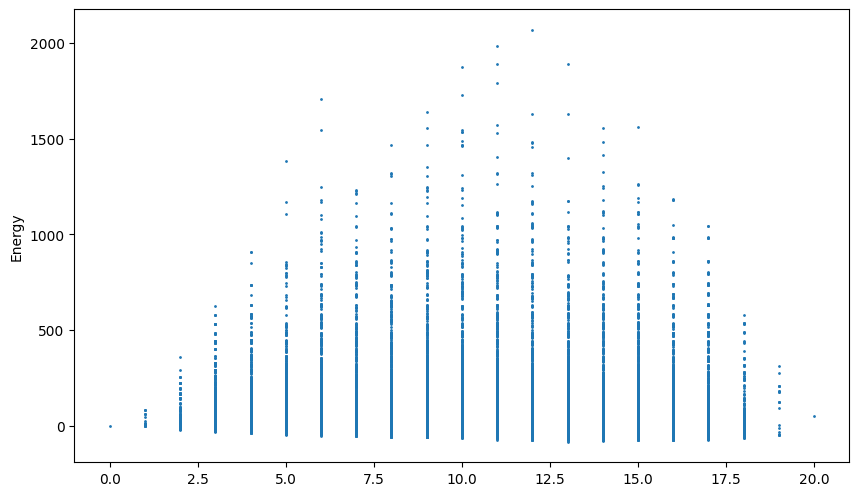

Best found: [0, 2, 4, 5, 6, 7, 8, 9, 15, 16, 17, 18, 19]
count: 13
Energy: -83.0
Solutions Sampled: 15422
[0, 2, 4, 5, 6, 7, 8, 9, 15, 16, 17, 18, 19] -83.0
0 2 2
2 6 2
4 10 3
5 12 5
6 14 6
7 16 5
8 18 8
9 20 9
Items added to Knapsack [0, 2, 4, 5, 6, 7, 8, 9]
Total value: 98
Total weight: 40
Condition 1 - Only one weight should be selected.
FAIL: One weight condition not met [6, 7, 8, 9, 10]


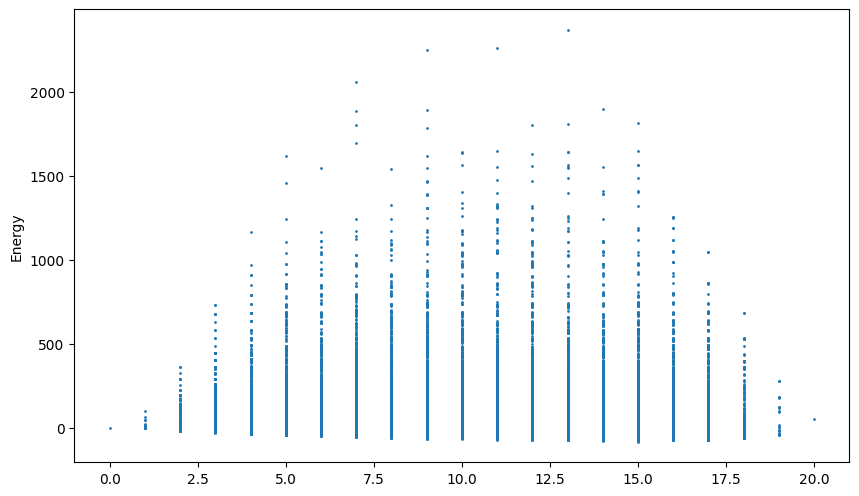

Best found: [1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 15, 16, 17, 18, 19]
count: 15
Energy: -83.0
Solutions Sampled: 15422
[1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 15, 16, 17, 18, 19] -83.0
1 4 3
2 6 2
3 8 3
4 10 3
5 12 5
6 14 6
7 16 5
8 18 8
9 20 9
Items added to Knapsack [1, 2, 3, 4, 5, 6, 7, 8, 9]
Total value: 108
Total weight: 44
Condition 1 - Only one weight should be selected.
FAIL: One weight condition not met [3, 6, 7, 8, 9, 10]


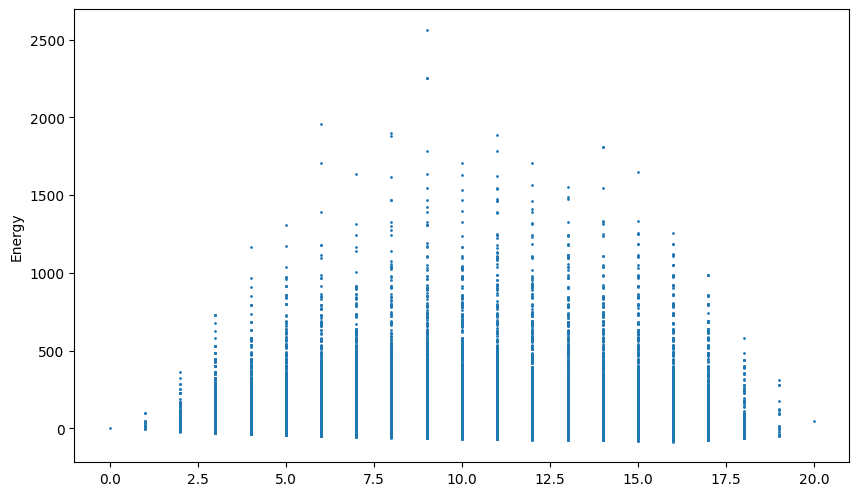

Best found: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 14, 15, 16, 17, 18, 19]
count: 16
Energy: -85.0
Solutions Sampled: 15422
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 14, 15, 16, 17, 18, 19] -85.0
0 2 2
1 4 3
2 6 2
3 8 3
4 10 3
5 12 5
6 14 6
7 16 5
8 18 8
9 20 9
Items added to Knapsack [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Total value: 110
Total weight: 46
Condition 1 - Only one weight should be selected.
FAIL: One weight condition not met [5, 6, 7, 8, 9, 10]


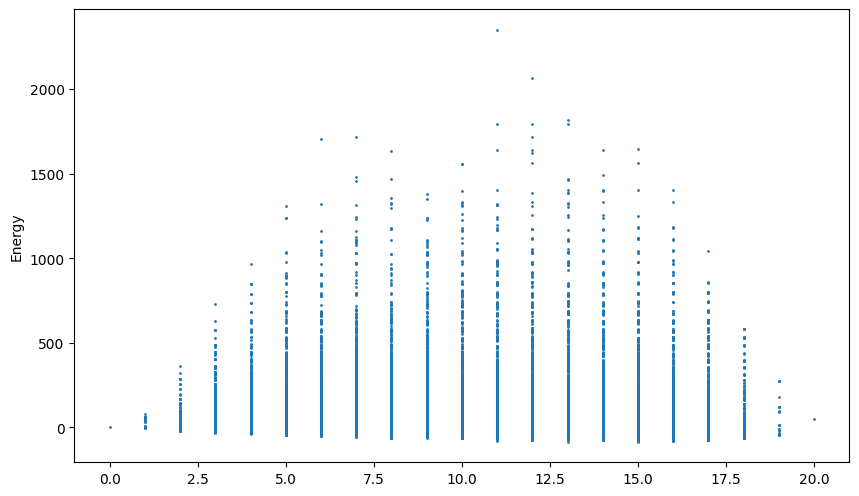

Best found: [1, 2, 3, 4, 5, 6, 7, 8, 9, 13, 15, 16, 17, 18, 19]
count: 15
Energy: -84.0
Solutions Sampled: 15422
[1, 2, 3, 4, 5, 6, 7, 8, 9, 13, 15, 16, 17, 18, 19] -84.0
1 4 3
2 6 2
3 8 3
4 10 3
5 12 5
6 14 6
7 16 5
8 18 8
9 20 9
Items added to Knapsack [1, 2, 3, 4, 5, 6, 7, 8, 9]
Total value: 108
Total weight: 44
Condition 1 - Only one weight should be selected.
FAIL: One weight condition not met [4, 6, 7, 8, 9, 10]


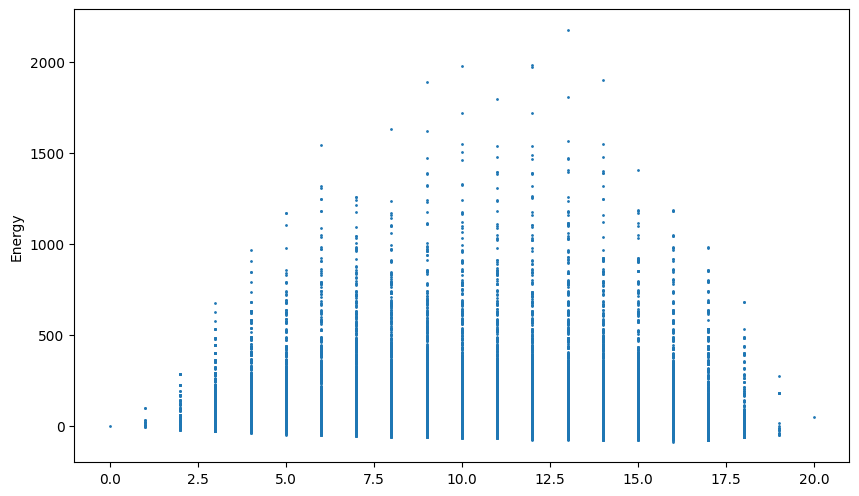

Best found: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 14, 15, 16, 17, 18, 19]
count: 16
Energy: -85.0
Solutions Sampled: 15422
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 14, 15, 16, 17, 18, 19] -85.0
0 2 2
1 4 3
2 6 2
3 8 3
4 10 3
5 12 5
6 14 6
7 16 5
8 18 8
9 20 9
Items added to Knapsack [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Total value: 110
Total weight: 46
Condition 1 - Only one weight should be selected.
FAIL: One weight condition not met [5, 6, 7, 8, 9, 10]


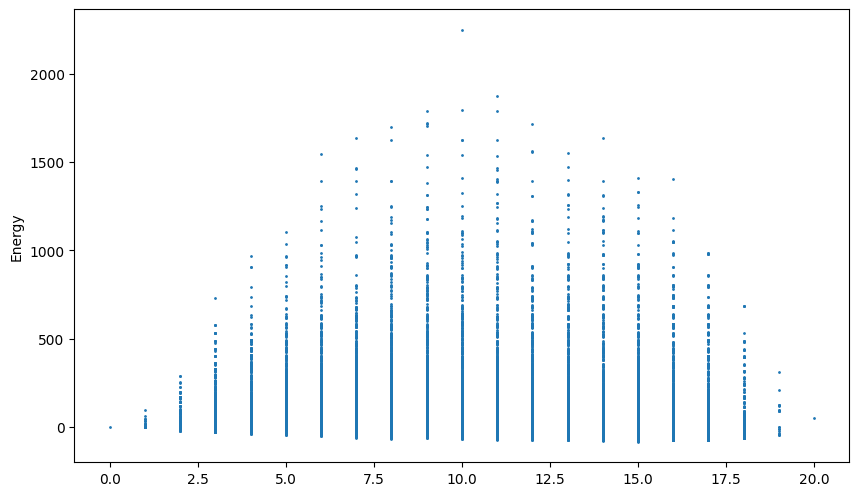

Best found: [1, 2, 3, 4, 5, 6, 7, 8, 9, 13, 14, 16, 17, 18, 19]
count: 15
Energy: -83.0
Solutions Sampled: 15422
[1, 2, 3, 4, 5, 6, 7, 8, 9, 13, 14, 16, 17, 18, 19] -83.0
1 4 3
2 6 2
3 8 3
4 10 3
5 12 5
6 14 6
7 16 5
8 18 8
9 20 9
Items added to Knapsack [1, 2, 3, 4, 5, 6, 7, 8, 9]
Total value: 108
Total weight: 44
Condition 1 - Only one weight should be selected.
FAIL: One weight condition not met [4, 5, 7, 8, 9, 10]


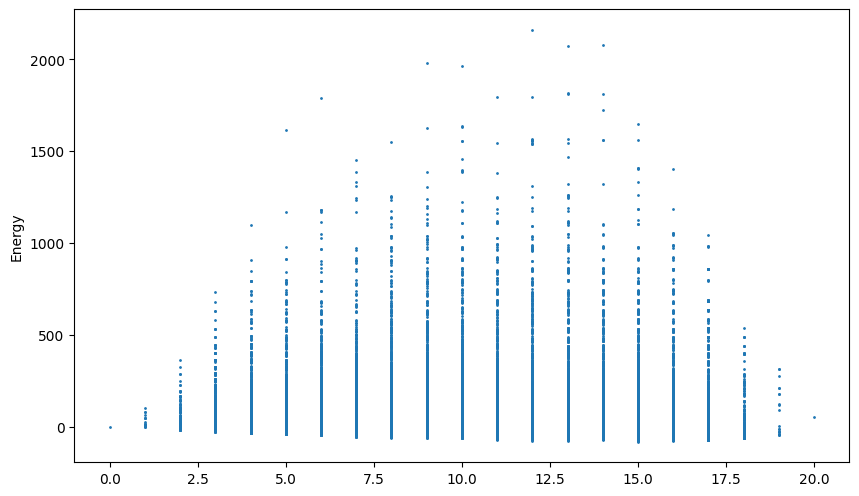

Best found: [0, 2, 3, 4, 5, 6, 7, 8, 9, 13, 14, 16, 17, 18, 19]
count: 15
Energy: -82.0
Solutions Sampled: 15422
[0, 2, 3, 4, 5, 6, 7, 8, 9, 13, 14, 16, 17, 18, 19] -82.0
0 2 2
2 6 2
3 8 3
4 10 3
5 12 5
6 14 6
7 16 5
8 18 8
9 20 9
Items added to Knapsack [0, 2, 3, 4, 5, 6, 7, 8, 9]
Total value: 106
Total weight: 43
Condition 1 - Only one weight should be selected.
FAIL: One weight condition not met [4, 5, 7, 8, 9, 10]


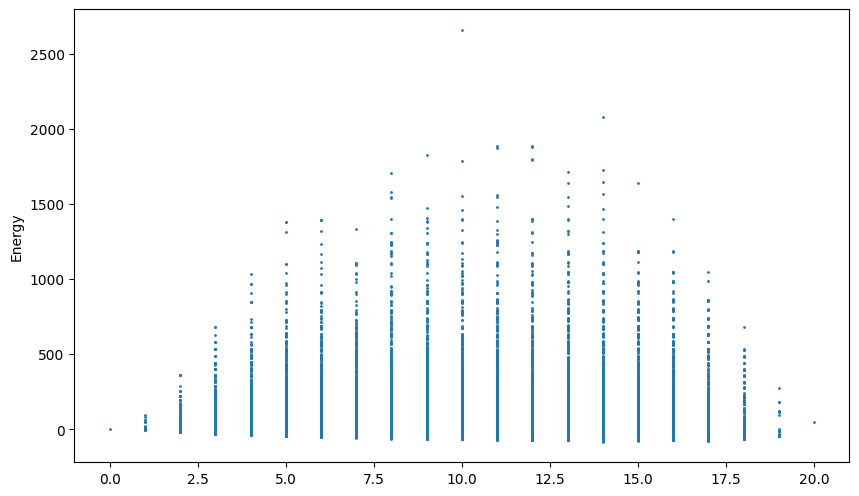

Best found: [0, 2, 3, 4, 5, 6, 7, 8, 9, 15, 16, 17, 18, 19]
count: 14
Energy: -82.0
Solutions Sampled: 15422
[0, 2, 3, 4, 5, 6, 7, 8, 9, 15, 16, 17, 18, 19] -82.0
0 2 2
2 6 2
3 8 3
4 10 3
5 12 5
6 14 6
7 16 5
8 18 8
9 20 9
Items added to Knapsack [0, 2, 3, 4, 5, 6, 7, 8, 9]
Total value: 106
Total weight: 43
Condition 1 - Only one weight should be selected.
FAIL: One weight condition not met [6, 7, 8, 9, 10]


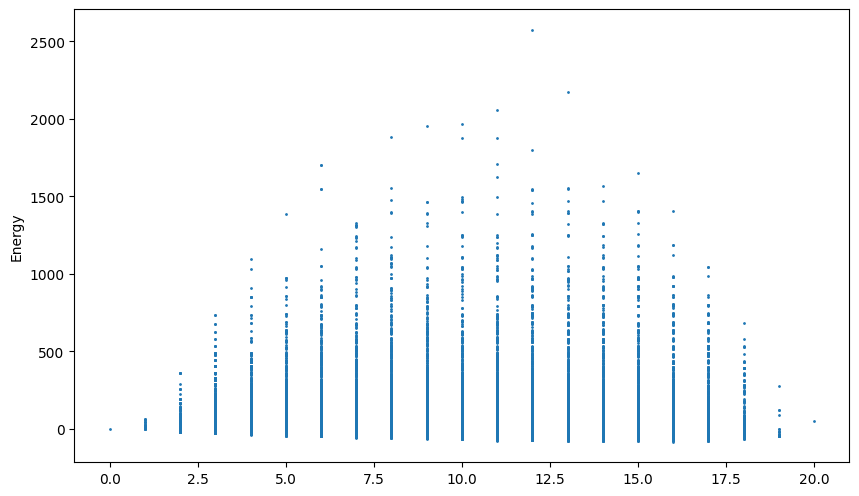

Best found: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 13, 15, 16, 17, 18, 19]
count: 16
Energy: -82.0
Solutions Sampled: 15422
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 13, 15, 16, 17, 18, 19] -82.0
0 2 2
1 4 3
2 6 2
3 8 3
4 10 3
5 12 5
6 14 6
7 16 5
8 18 8
9 20 9
Items added to Knapsack [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Total value: 110
Total weight: 46
Condition 1 - Only one weight should be selected.
FAIL: One weight condition not met [4, 6, 7, 8, 9, 10]


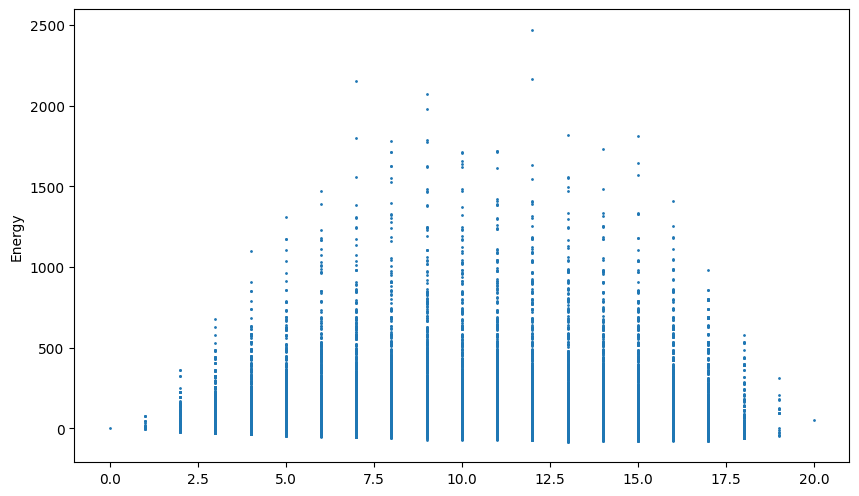

Best found: [1, 2, 3, 5, 6, 7, 8, 9, 15, 16, 17, 18, 19]
count: 13
Energy: -82.0
Solutions Sampled: 15422
[1, 2, 3, 5, 6, 7, 8, 9, 15, 16, 17, 18, 19] -82.0
1 4 3
2 6 2
3 8 3
5 12 5
6 14 6
7 16 5
8 18 8
9 20 9
Items added to Knapsack [1, 2, 3, 5, 6, 7, 8, 9]
Total value: 98
Total weight: 41
Condition 1 - Only one weight should be selected.
FAIL: One weight condition not met [6, 7, 8, 9, 10]


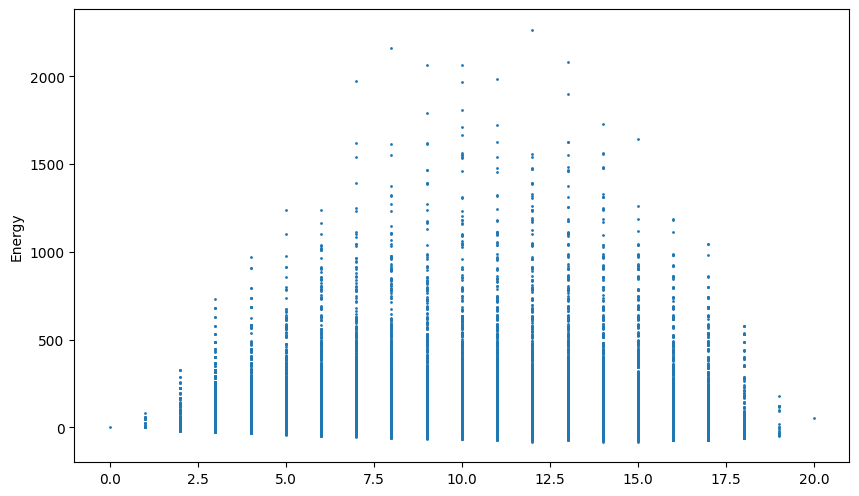

Best found: [0, 2, 3, 4, 5, 6, 7, 8, 9, 15, 16, 17, 18, 19]
count: 14
Energy: -82.0
Solutions Sampled: 15422
[0, 2, 3, 4, 5, 6, 7, 8, 9, 15, 16, 17, 18, 19] -82.0
0 2 2
2 6 2
3 8 3
4 10 3
5 12 5
6 14 6
7 16 5
8 18 8
9 20 9
Items added to Knapsack [0, 2, 3, 4, 5, 6, 7, 8, 9]
Total value: 106
Total weight: 43
Condition 1 - Only one weight should be selected.
FAIL: One weight condition not met [6, 7, 8, 9, 10]


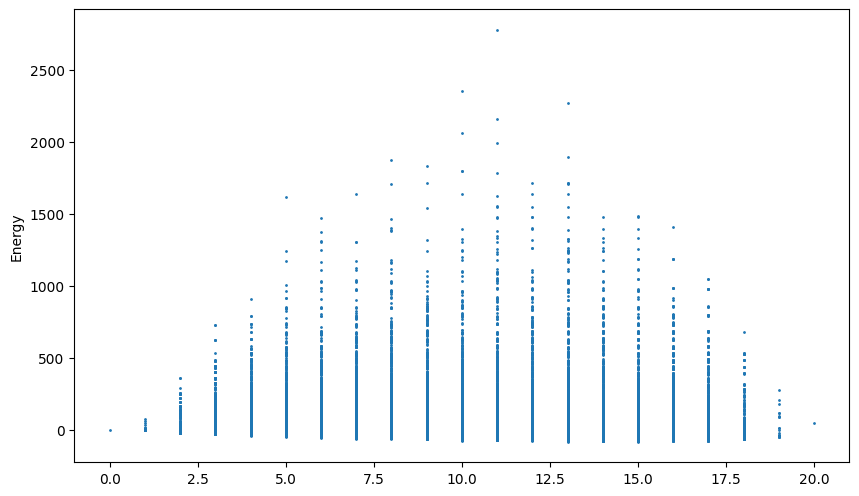

Best found: [1, 2, 3, 4, 6, 7, 8, 9, 15, 16, 17, 18, 19]
count: 13
Energy: -80.0
Solutions Sampled: 15422
[1, 2, 3, 4, 6, 7, 8, 9, 15, 16, 17, 18, 19] -80.0
1 4 3
2 6 2
3 8 3
4 10 3
6 14 6
7 16 5
8 18 8
9 20 9
Items added to Knapsack [1, 2, 3, 4, 6, 7, 8, 9]
Total value: 96
Total weight: 39
Condition 1 - Only one weight should be selected.
FAIL: One weight condition not met [6, 7, 8, 9, 10]


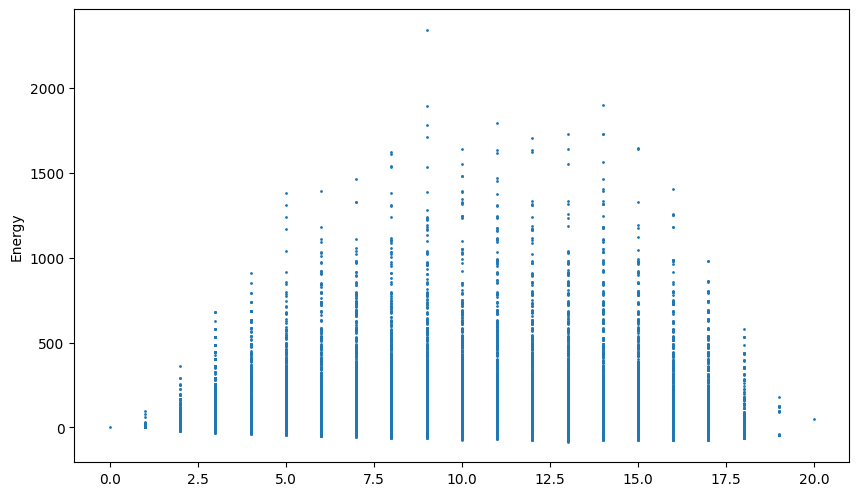

Best found: [1, 2, 4, 5, 6, 7, 8, 9, 15, 16, 17, 18, 19]
count: 13
Energy: -84.0
Solutions Sampled: 15422
[1, 2, 4, 5, 6, 7, 8, 9, 15, 16, 17, 18, 19] -84.0
1 4 3
2 6 2
4 10 3
5 12 5
6 14 6
7 16 5
8 18 8
9 20 9
Items added to Knapsack [1, 2, 4, 5, 6, 7, 8, 9]
Total value: 100
Total weight: 41
Condition 1 - Only one weight should be selected.
FAIL: One weight condition not met [6, 7, 8, 9, 10]


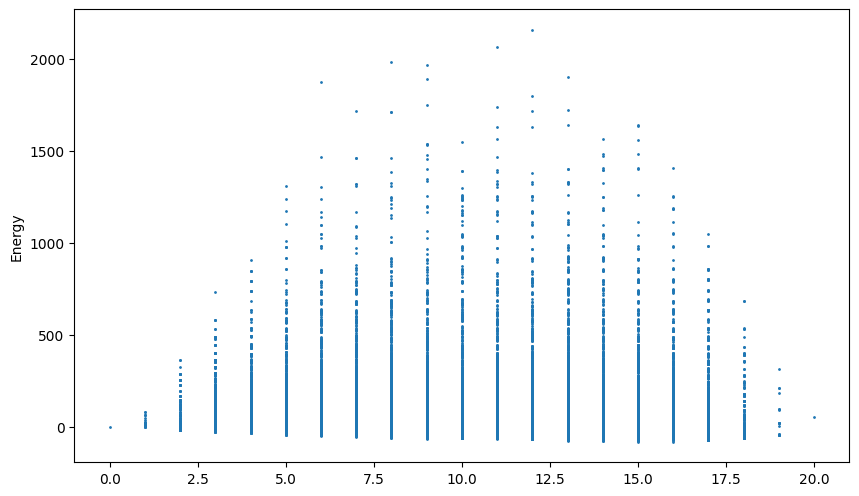

Best found: [0, 2, 3, 4, 5, 6, 7, 8, 9, 13, 14, 16, 17, 18, 19]
count: 15
Energy: -82.0
Solutions Sampled: 15422
[0, 2, 3, 4, 5, 6, 7, 8, 9, 13, 14, 16, 17, 18, 19] -82.0
0 2 2
2 6 2
3 8 3
4 10 3
5 12 5
6 14 6
7 16 5
8 18 8
9 20 9
Items added to Knapsack [0, 2, 3, 4, 5, 6, 7, 8, 9]
Total value: 106
Total weight: 43
Condition 1 - Only one weight should be selected.
FAIL: One weight condition not met [4, 5, 7, 8, 9, 10]


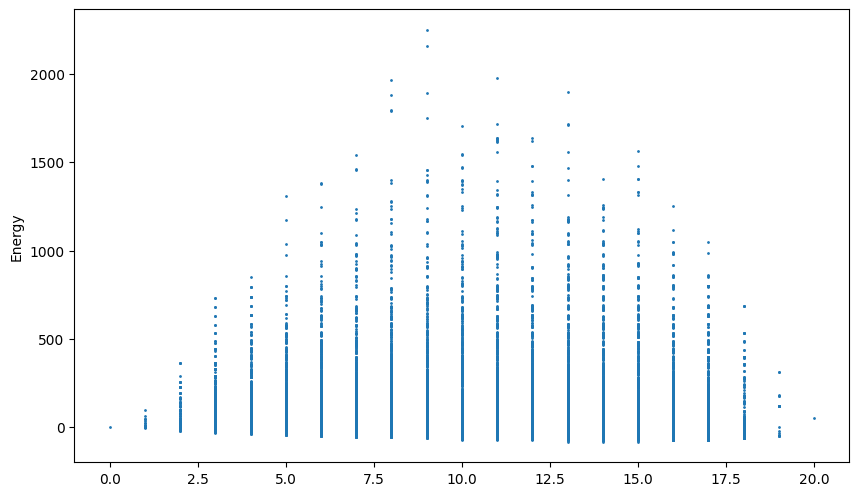

Best found: [0, 2, 4, 5, 6, 7, 8, 9, 14, 16, 17, 18, 19]
count: 13
Energy: -82.0
Solutions Sampled: 15422
[0, 2, 4, 5, 6, 7, 8, 9, 14, 16, 17, 18, 19] -82.0
0 2 2
2 6 2
4 10 3
5 12 5
6 14 6
7 16 5
8 18 8
9 20 9
Items added to Knapsack [0, 2, 4, 5, 6, 7, 8, 9]
Total value: 98
Total weight: 40
Condition 1 - Only one weight should be selected.
FAIL: One weight condition not met [5, 7, 8, 9, 10]


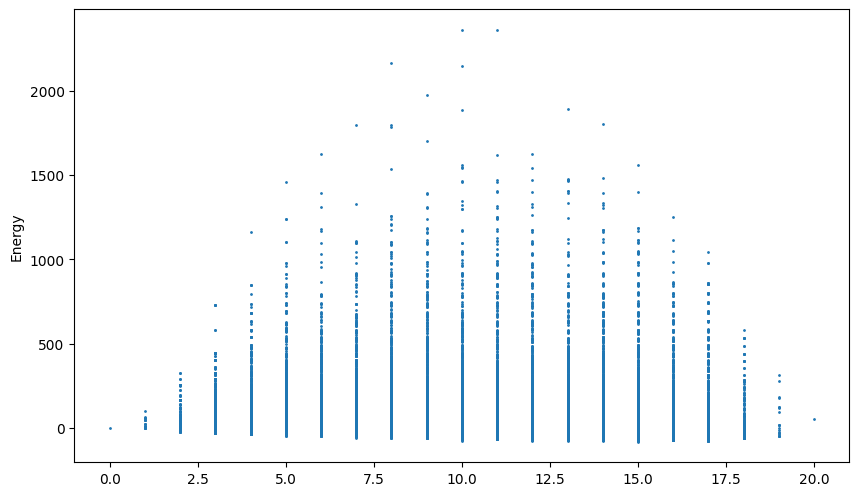

Best found: [0, 2, 3, 4, 5, 6, 7, 8, 9, 11, 15, 16, 17, 18, 19]
count: 15
Energy: -81.0
Solutions Sampled: 15422
[0, 2, 3, 4, 5, 6, 7, 8, 9, 11, 15, 16, 17, 18, 19] -81.0
0 2 2
2 6 2
3 8 3
4 10 3
5 12 5
6 14 6
7 16 5
8 18 8
9 20 9
Items added to Knapsack [0, 2, 3, 4, 5, 6, 7, 8, 9]
Total value: 106
Total weight: 43
Condition 1 - Only one weight should be selected.
FAIL: One weight condition not met [2, 6, 7, 8, 9, 10]


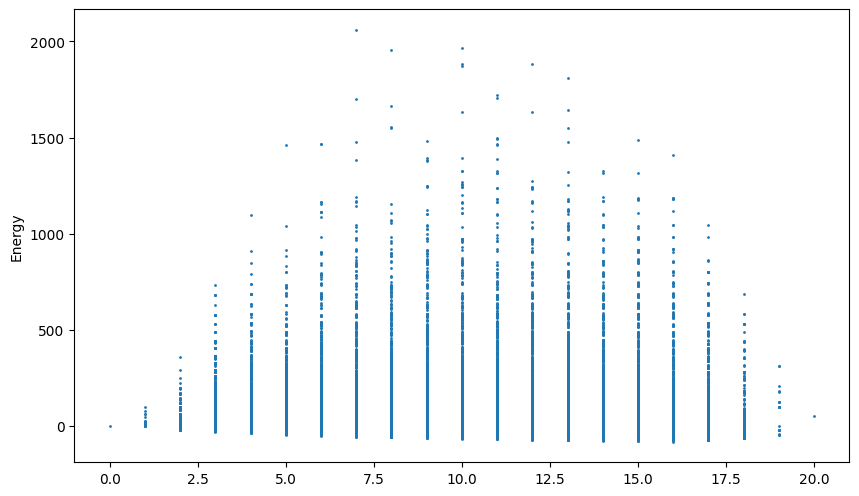

Best found: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 13, 15, 16, 17, 18, 19]
count: 16
Energy: -82.0
Solutions Sampled: 15422
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 13, 15, 16, 17, 18, 19] -82.0
0 2 2
1 4 3
2 6 2
3 8 3
4 10 3
5 12 5
6 14 6
7 16 5
8 18 8
9 20 9
Items added to Knapsack [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Total value: 110
Total weight: 46
Condition 1 - Only one weight should be selected.
FAIL: One weight condition not met [4, 6, 7, 8, 9, 10]
-------FAIL!------------
No good values found
Condition 1: One weight condition failed 100.0 %
Condition 2: Weight match condition failed 0.0 %


In [56]:
cond1_fail=0
cond2_fail=0
good_solution=[]
good_value=[]
good_weight=[]
good_energy=[]
count=50
for trial in range (count):

    solution=ProbabilisticSampler(Mf,1000)
    print(solution[0],solution[1])

    # check if constraints were met
    item_list=[]
    Vt=0
    Wt=0
    for i in solution[0]:
        if i <N:
            Vt+=value[i]
            Wt+=weight[i]
            print(i, value[i], weight[i])
            item_list.append(i)
    print('Items added to Knapsack',item_list)
    print('Total value:',Vt)
    print('Total weight:',Wt)

    check_y=0
    weight_list=[]
    for i in solution[0]:
        if i>=N:
            check_y+=1
            weight_list.append(i-N+1)
    print('Condition 1 - Only one weight should be selected.')
    if check_y>1:
        print('FAIL: One weight condition not met', weight_list)
        cond1_fail+=1

    elif check_y==1:
        print('OK: condition met', weight_list)
        print('Condition 2 - Total weight should be equal to weight selected')
        if Wt==weight_list[0]:
            print('OK: Condition met', Wt)
            good_solution.append(item_list)
            good_value.append(Vt)
            good_weight.append(Wt)
            good_energy.append(solution[1])
            
        else:
            print('FAIL: Weight match condition not met', Wt, weight_list[0])
            cond2_fail+=1
    else:
        print('FAIL: No weight was found')


good_count=len(good_value)
if good_count==0:
    print('-------FAIL!------------')
    print('No good values found')
    print('Condition 1: One weight condition failed',(cond1_fail/count)*100, '%')
    print('Condition 2: Weight match condition failed',(cond2_fail/count)*100, '%')
else:
    print('-------Success!------------')
    for i in range(good_count):
        
        print(i, good_solution[i], 'Value', good_value[i],'Wt', good_weight[i], 'energy', good_energy[i])



Create Mf with A=400, B=2.0 and C=1.0

In [52]:
A=400 #ensure only one weight is selected
B=2 # ensure weight matches total weight
C=1   # ensure correct items are selected

Mxf=C*np.array(Mv)+B*np.array(Mx)
print('Mxf',np.shape(Mxf))
Myf=A*np.array(Myc)+B*np.array(My)
print('Myf',np.shape(Myf))
MxyMyf=np.append(B*Mxy, Myf , axis=0) 
print('MxyMyf',np.shape(MxyMyf))
Mxzeros=np.zeros([wc,N],dtype=float)
print('Mxzeros',np.shape(Mxzeros))
Mxflarge=np.append(Mxf, Mxzeros, axis=0)
print('Mxflarge',np.shape(Mxflarge))
Mf=np.append(Mxflarge,MxyMyf, axis=1)
print('Mf',np.shape(Mf))
print(Mf)
np.savetxt('Mf.csv', Mf, delimiter=',')

Mxf (10, 10)
Myf (10, 10)
MxyMyf (20, 10)
Mxzeros (10, 10)
Mxflarge (20, 10)
Mf (20, 20)
[[   6.   24.   16.   24.   24.   40.   48.   40.   64.   72.   -8.  -16.
   -24.  -32.  -40.  -48.  -56.  -64.  -72.  -80.]
 [   0.   14.   24.   36.   36.   60.   72.   60.   96.  108.  -12.  -24.
   -36.  -48.  -60.  -72.  -84.  -96. -108. -120.]
 [   0.    0.    2.   24.   24.   40.   48.   40.   64.   72.   -8.  -16.
   -24.  -32.  -40.  -48.  -56.  -64.  -72.  -80.]
 [   0.    0.    0.   10.   36.   60.   72.   60.   96.  108.  -12.  -24.
   -36.  -48.  -60.  -72.  -84.  -96. -108. -120.]
 [   0.    0.    0.    0.    8.   60.   72.   60.   96.  108.  -12.  -24.
   -36.  -48.  -60.  -72.  -84.  -96. -108. -120.]
 [   0.    0.    0.    0.    0.   38.  120.  100.  160.  180.  -20.  -40.
   -60.  -80. -100. -120. -140. -160. -180. -200.]
 [   0.    0.    0.    0.    0.    0.   58.  120.  192.  216.  -24.  -48.
   -72.  -96. -120. -144. -168. -192. -216. -240.]
 [   0.    0.    0.    0.    0.    0

Run on probabilitic solver with optimized multipliers, A=400

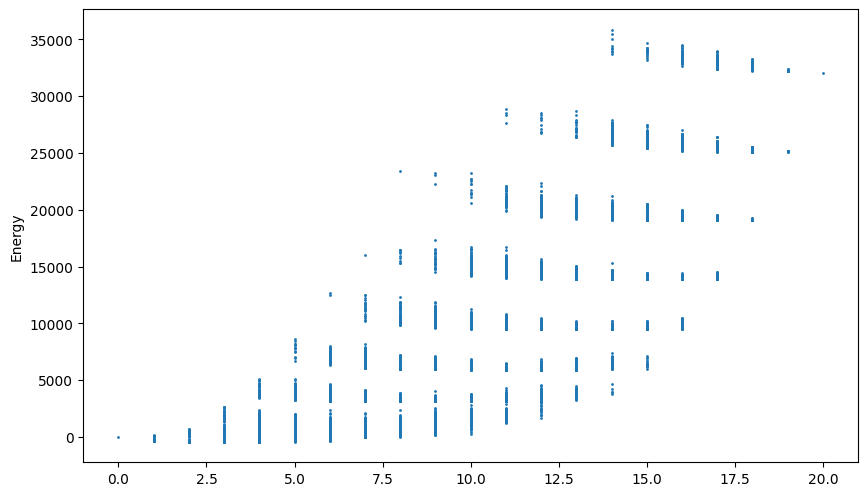

Best found: [4, 7, 17]
count: 3
Energy: -426.0
Solutions Sampled: 15422
[4, 7, 17] -426.0
4 10 3
7 16 5
Items added to Knapsack [4, 7]
Total value: 26
Total weight: 8
Condition 1 - Only one weight should be selected.
OK: condition met [8]
Condition 2 - Total weight should be equal to weight selected
OK: Condition met 8


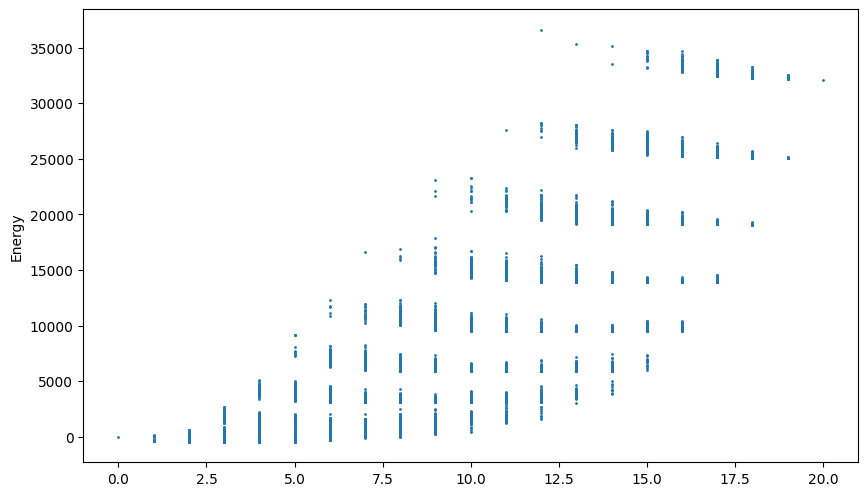

Best found: [3, 4, 7, 19]
count: 4
Energy: -432.0
Solutions Sampled: 15422
[3, 4, 7, 19] -432.0
3 8 3
4 10 3
7 16 5
Items added to Knapsack [3, 4, 7]
Total value: 34
Total weight: 11
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
FAIL: Weight match condition not met 11 10


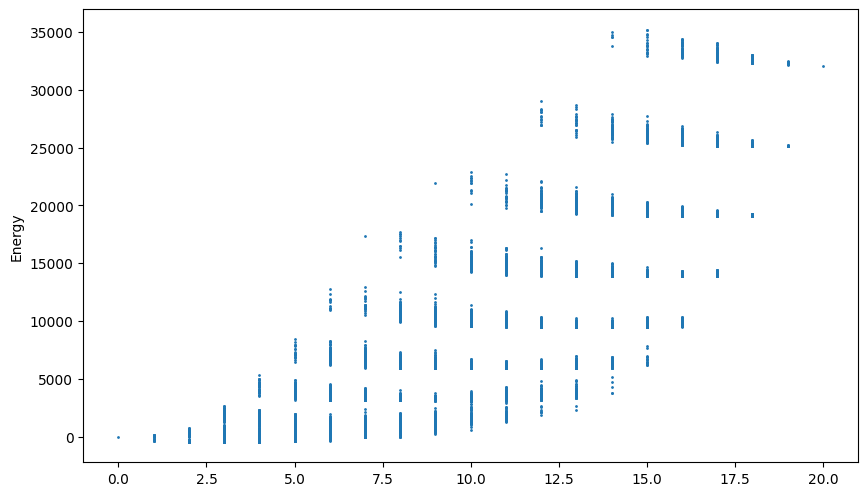

Best found: [0, 4, 7, 19]
count: 4
Energy: -428.0
Solutions Sampled: 15422
[0, 4, 7, 19] -428.0
0 2 2
4 10 3
7 16 5
Items added to Knapsack [0, 4, 7]
Total value: 28
Total weight: 10
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
OK: Condition met 10


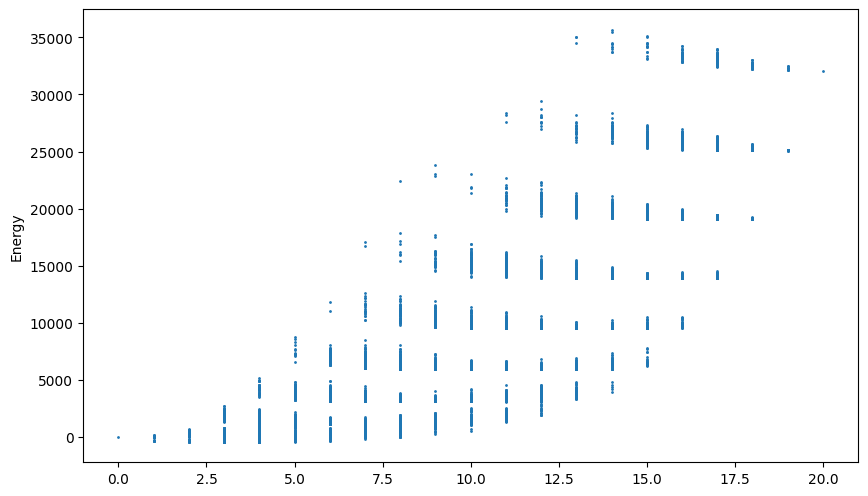

Best found: [3, 4, 7, 19]
count: 4
Energy: -432.0
Solutions Sampled: 15422
[3, 4, 7, 19] -432.0
3 8 3
4 10 3
7 16 5
Items added to Knapsack [3, 4, 7]
Total value: 34
Total weight: 11
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
FAIL: Weight match condition not met 11 10


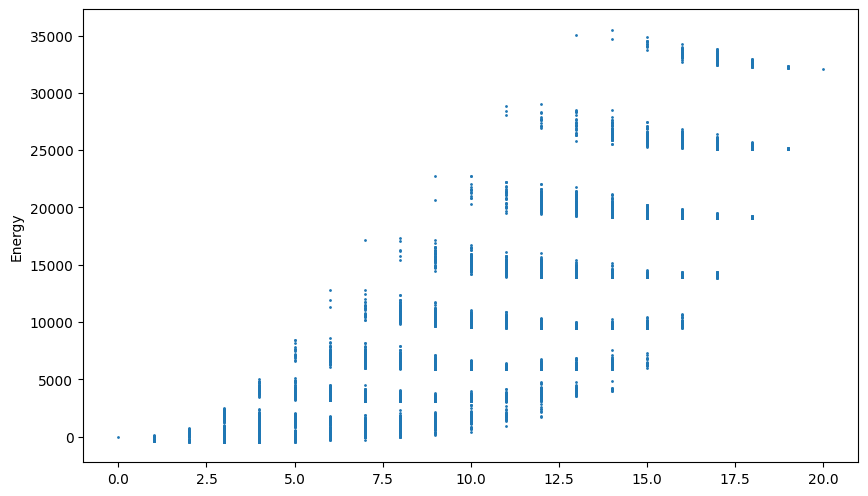

Best found: [2, 4, 7, 18]
count: 4
Energy: -430.0
Solutions Sampled: 15422
[2, 4, 7, 18] -430.0
2 6 2
4 10 3
7 16 5
Items added to Knapsack [2, 4, 7]
Total value: 32
Total weight: 10
Condition 1 - Only one weight should be selected.
OK: condition met [9]
Condition 2 - Total weight should be equal to weight selected
FAIL: Weight match condition not met 10 9


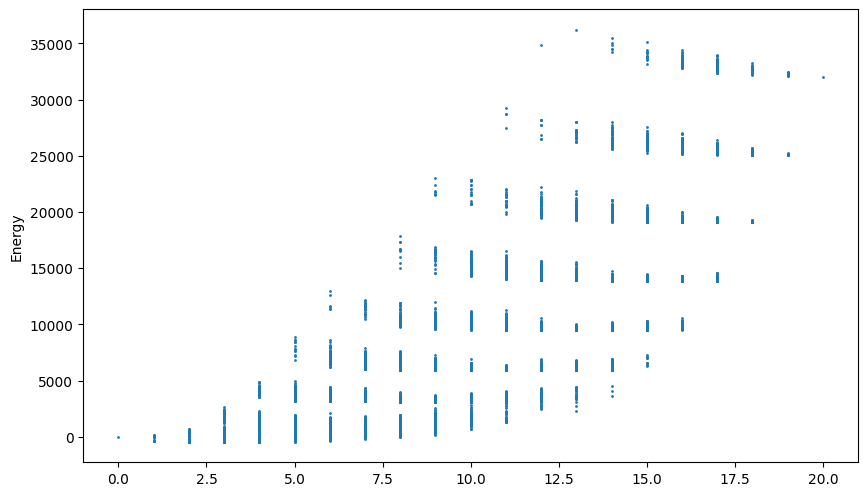

Best found: [6, 7, 19]
count: 3
Energy: -428.0
Solutions Sampled: 15422
[6, 7, 19] -428.0
6 14 6
7 16 5
Items added to Knapsack [6, 7]
Total value: 30
Total weight: 11
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
FAIL: Weight match condition not met 11 10


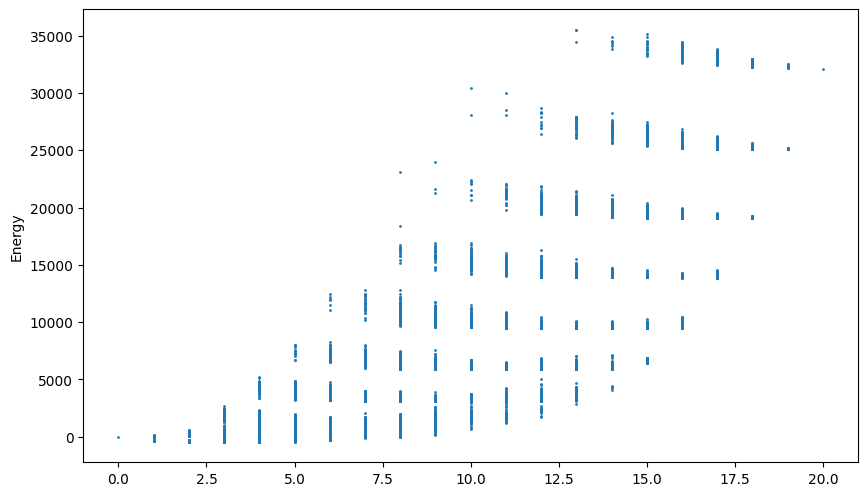

Best found: [5, 7, 19]
count: 3
Energy: -428.0
Solutions Sampled: 15422
[5, 7, 19] -428.0
5 12 5
7 16 5
Items added to Knapsack [5, 7]
Total value: 28
Total weight: 10
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
OK: Condition met 10


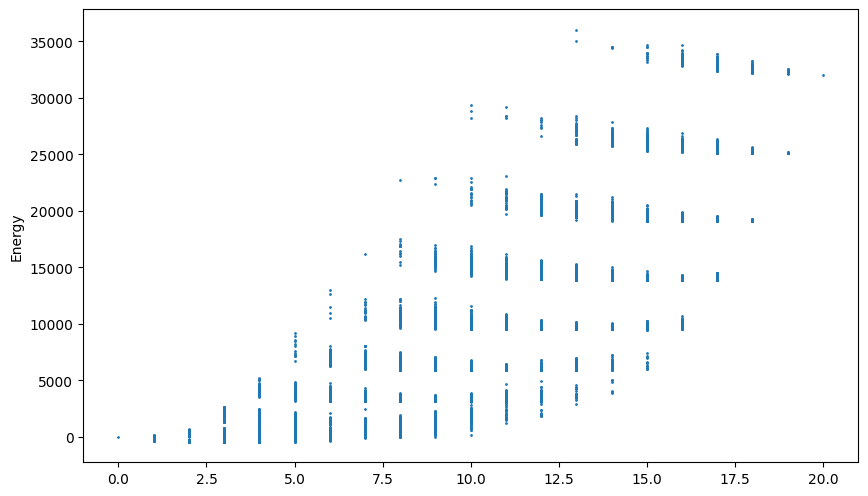

Best found: [2, 3, 7, 19]
count: 4
Energy: -430.0
Solutions Sampled: 15422
[2, 3, 7, 19] -430.0
2 6 2
3 8 3
7 16 5
Items added to Knapsack [2, 3, 7]
Total value: 30
Total weight: 10
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
OK: Condition met 10


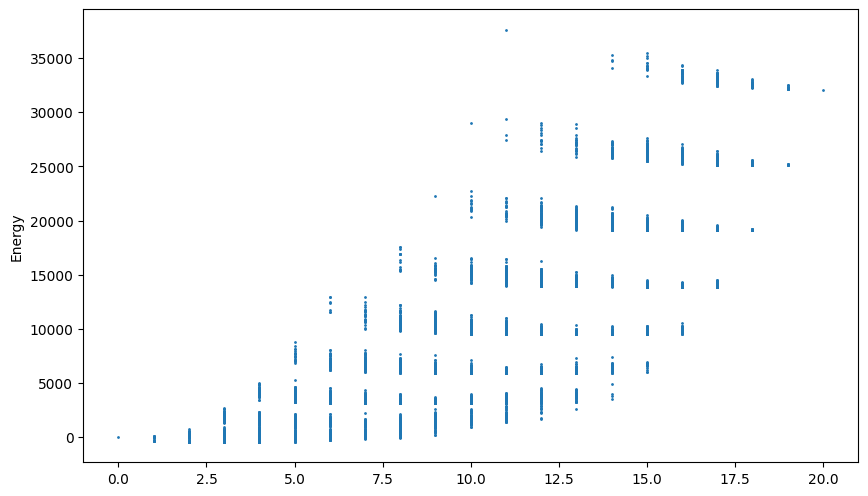

Best found: [2, 4, 7, 18]
count: 4
Energy: -430.0
Solutions Sampled: 15422
[2, 4, 7, 18] -430.0
2 6 2
4 10 3
7 16 5
Items added to Knapsack [2, 4, 7]
Total value: 32
Total weight: 10
Condition 1 - Only one weight should be selected.
OK: condition met [9]
Condition 2 - Total weight should be equal to weight selected
FAIL: Weight match condition not met 10 9


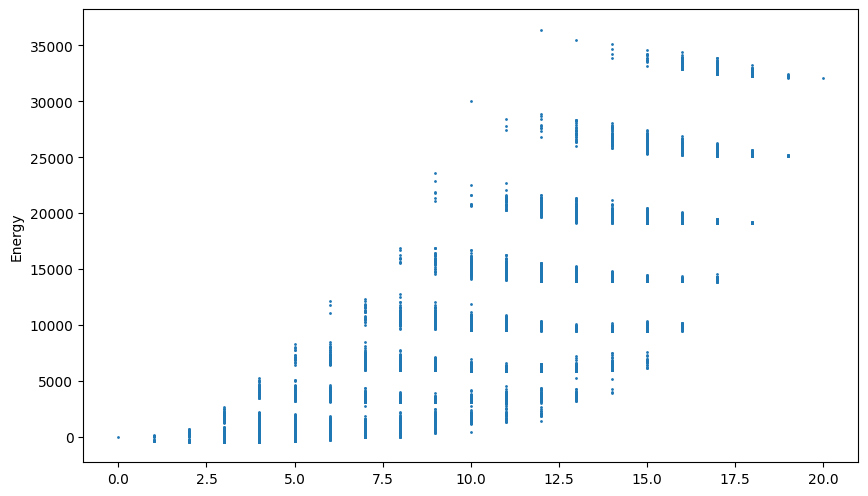

Best found: [2, 4, 7, 18]
count: 4
Energy: -430.0
Solutions Sampled: 15422
[2, 4, 7, 18] -430.0
2 6 2
4 10 3
7 16 5
Items added to Knapsack [2, 4, 7]
Total value: 32
Total weight: 10
Condition 1 - Only one weight should be selected.
OK: condition met [9]
Condition 2 - Total weight should be equal to weight selected
FAIL: Weight match condition not met 10 9


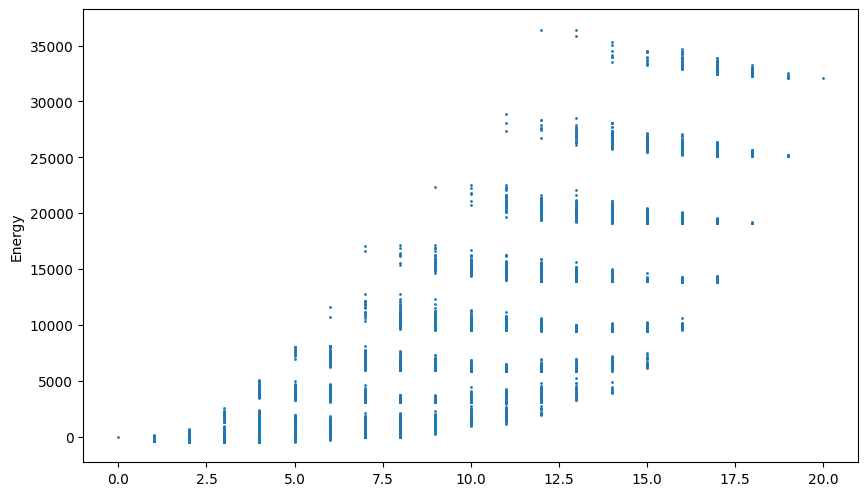

Best found: [5, 7, 19]
count: 3
Energy: -428.0
Solutions Sampled: 15422
[5, 7, 19] -428.0
5 12 5
7 16 5
Items added to Knapsack [5, 7]
Total value: 28
Total weight: 10
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
OK: Condition met 10


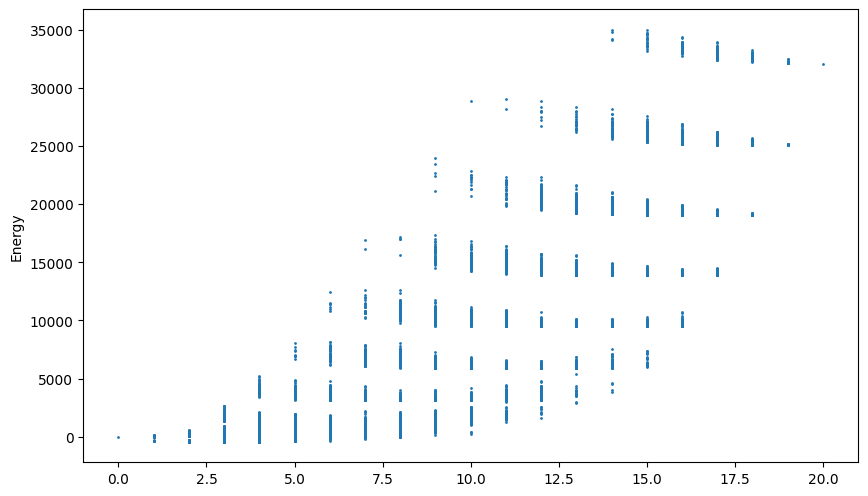

Best found: [2, 3, 7, 19]
count: 4
Energy: -430.0
Solutions Sampled: 15422
[2, 3, 7, 19] -430.0
2 6 2
3 8 3
7 16 5
Items added to Knapsack [2, 3, 7]
Total value: 30
Total weight: 10
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
OK: Condition met 10


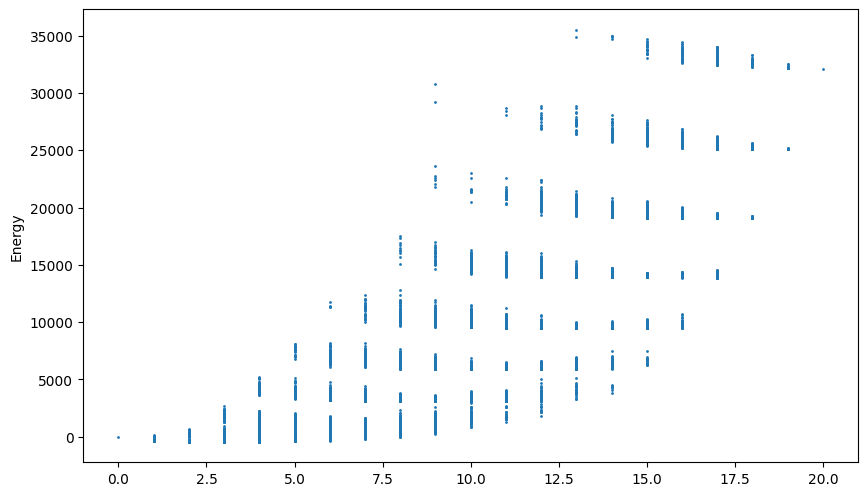

Best found: [2, 4, 7, 19]
count: 4
Energy: -432.0
Solutions Sampled: 15422
[2, 4, 7, 19] -432.0
2 6 2
4 10 3
7 16 5
Items added to Knapsack [2, 4, 7]
Total value: 32
Total weight: 10
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
OK: Condition met 10


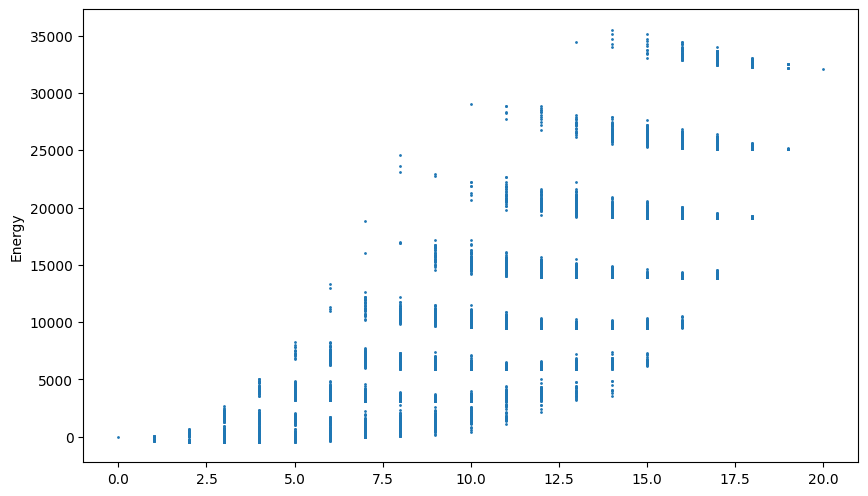

Best found: [5, 7, 19]
count: 3
Energy: -428.0
Solutions Sampled: 15422
[5, 7, 19] -428.0
5 12 5
7 16 5
Items added to Knapsack [5, 7]
Total value: 28
Total weight: 10
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
OK: Condition met 10


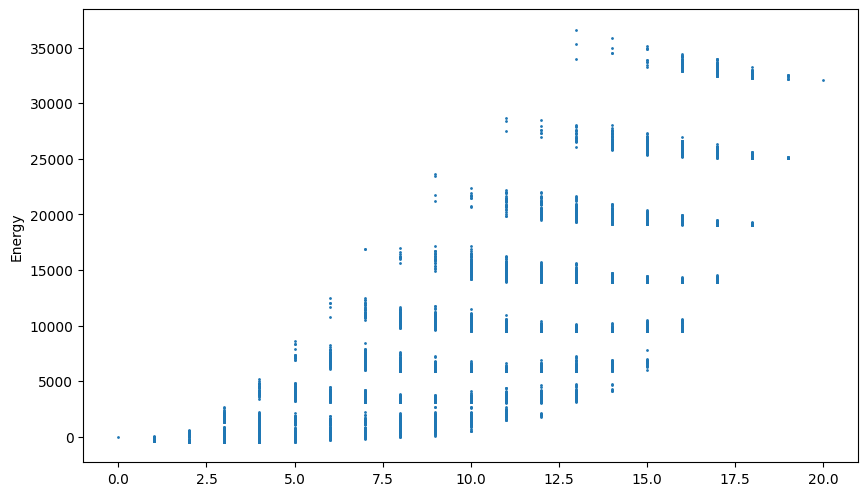

Best found: [3, 4, 7, 19]
count: 4
Energy: -432.0
Solutions Sampled: 15422
[3, 4, 7, 19] -432.0
3 8 3
4 10 3
7 16 5
Items added to Knapsack [3, 4, 7]
Total value: 34
Total weight: 11
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
FAIL: Weight match condition not met 11 10


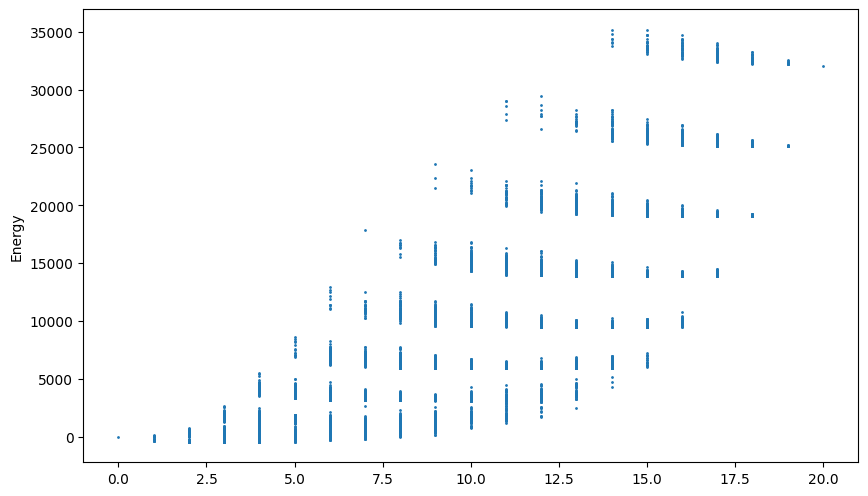

Best found: [2, 3, 7, 19]
count: 4
Energy: -430.0
Solutions Sampled: 15422
[2, 3, 7, 19] -430.0
2 6 2
3 8 3
7 16 5
Items added to Knapsack [2, 3, 7]
Total value: 30
Total weight: 10
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
OK: Condition met 10


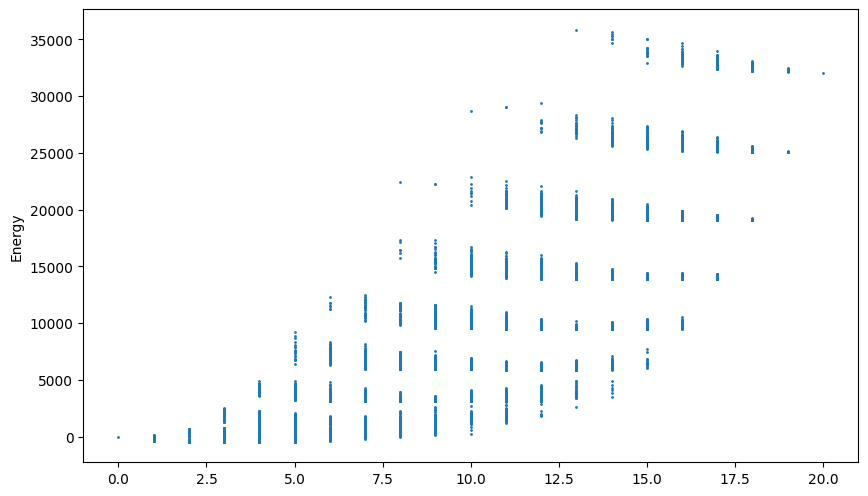

Best found: [2, 4, 7, 19]
count: 4
Energy: -432.0
Solutions Sampled: 15422
[2, 4, 7, 19] -432.0
2 6 2
4 10 3
7 16 5
Items added to Knapsack [2, 4, 7]
Total value: 32
Total weight: 10
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
OK: Condition met 10


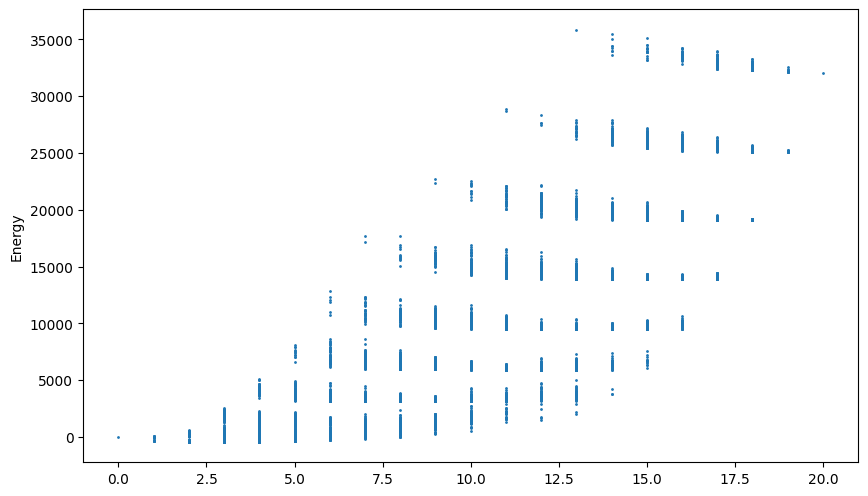

Best found: [5, 7, 19]
count: 3
Energy: -428.0
Solutions Sampled: 15422
[5, 7, 19] -428.0
5 12 5
7 16 5
Items added to Knapsack [5, 7]
Total value: 28
Total weight: 10
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
OK: Condition met 10


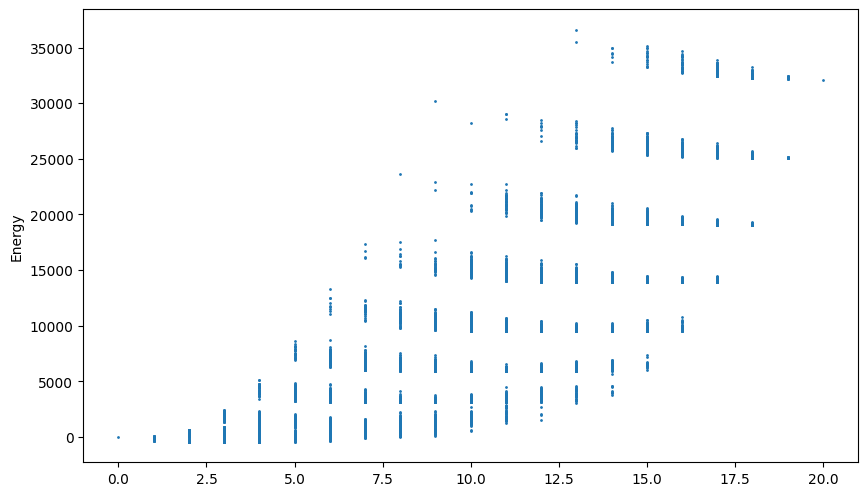

Best found: [2, 4, 7, 18]
count: 4
Energy: -430.0
Solutions Sampled: 15422
[2, 4, 7, 18] -430.0
2 6 2
4 10 3
7 16 5
Items added to Knapsack [2, 4, 7]
Total value: 32
Total weight: 10
Condition 1 - Only one weight should be selected.
OK: condition met [9]
Condition 2 - Total weight should be equal to weight selected
FAIL: Weight match condition not met 10 9


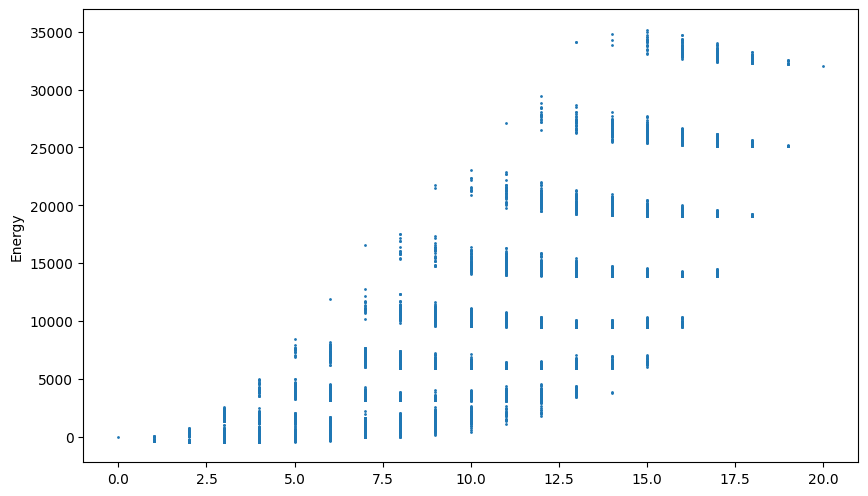

Best found: [2, 3, 7, 19]
count: 4
Energy: -430.0
Solutions Sampled: 15422
[2, 3, 7, 19] -430.0
2 6 2
3 8 3
7 16 5
Items added to Knapsack [2, 3, 7]
Total value: 30
Total weight: 10
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
OK: Condition met 10


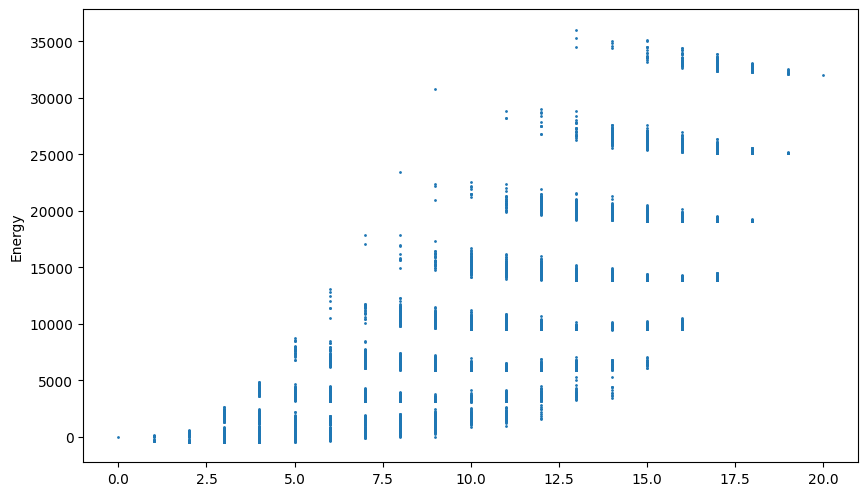

Best found: [2, 4, 7, 18]
count: 4
Energy: -430.0
Solutions Sampled: 15422
[2, 4, 7, 18] -430.0
2 6 2
4 10 3
7 16 5
Items added to Knapsack [2, 4, 7]
Total value: 32
Total weight: 10
Condition 1 - Only one weight should be selected.
OK: condition met [9]
Condition 2 - Total weight should be equal to weight selected
FAIL: Weight match condition not met 10 9


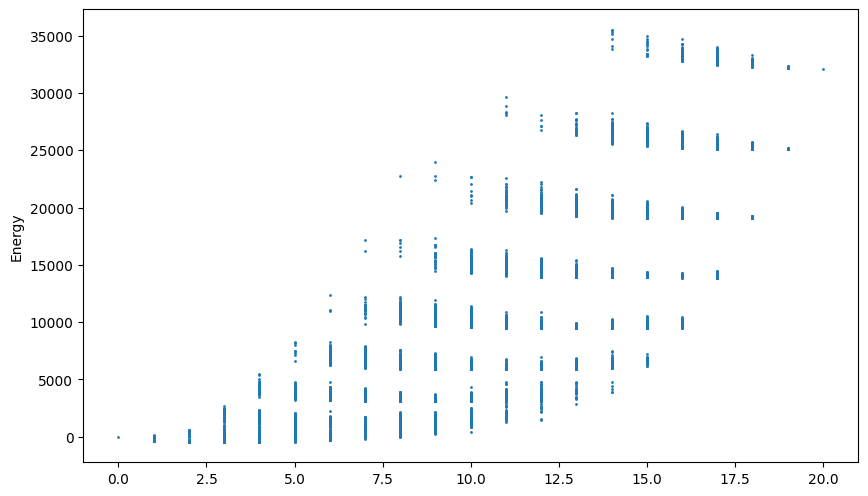

Best found: [6, 7, 19]
count: 3
Energy: -428.0
Solutions Sampled: 15422
[6, 7, 19] -428.0
6 14 6
7 16 5
Items added to Knapsack [6, 7]
Total value: 30
Total weight: 11
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
FAIL: Weight match condition not met 11 10


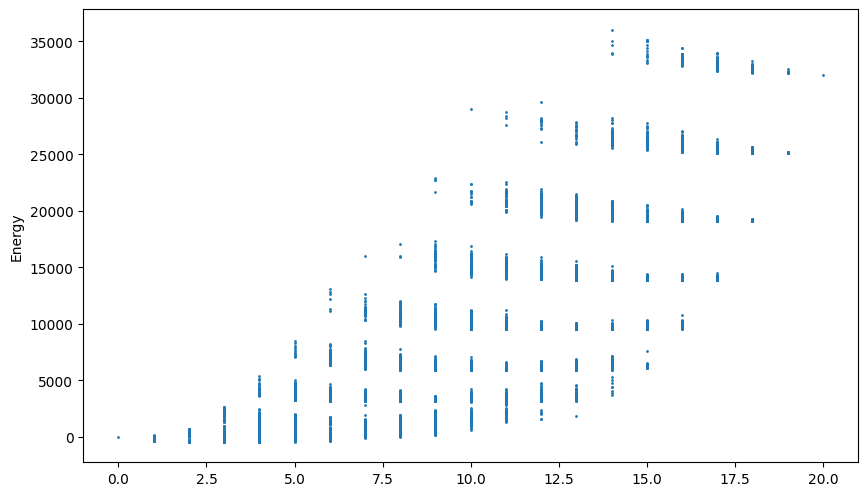

Best found: [2, 4, 7, 19]
count: 4
Energy: -432.0
Solutions Sampled: 15422
[2, 4, 7, 19] -432.0
2 6 2
4 10 3
7 16 5
Items added to Knapsack [2, 4, 7]
Total value: 32
Total weight: 10
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
OK: Condition met 10


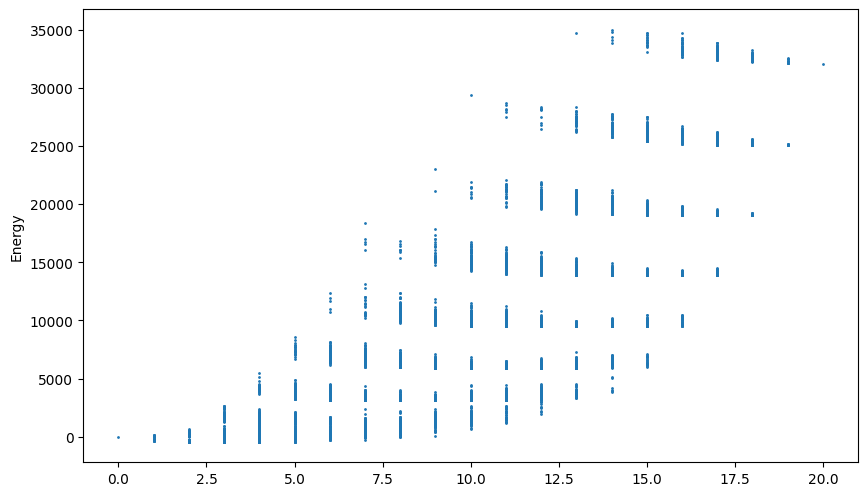

Best found: [3, 4, 5, 19]
count: 4
Energy: -428.0
Solutions Sampled: 15422
[3, 4, 5, 19] -428.0
3 8 3
4 10 3
5 12 5
Items added to Knapsack [3, 4, 5]
Total value: 30
Total weight: 11
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
FAIL: Weight match condition not met 11 10


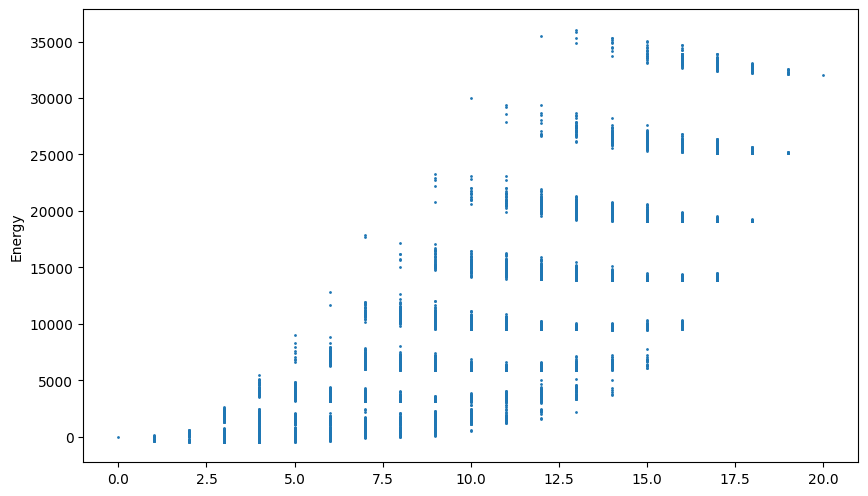

Best found: [2, 3, 7, 19]
count: 4
Energy: -430.0
Solutions Sampled: 15422
[2, 3, 7, 19] -430.0
2 6 2
3 8 3
7 16 5
Items added to Knapsack [2, 3, 7]
Total value: 30
Total weight: 10
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
OK: Condition met 10


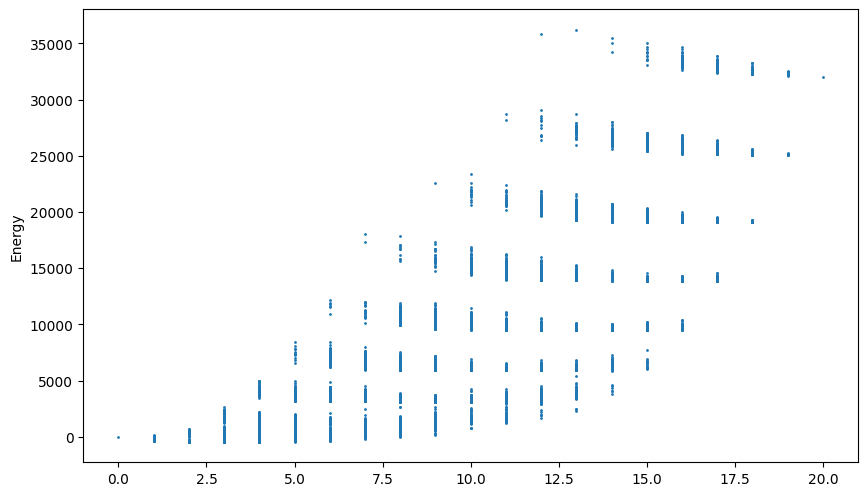

Best found: [6, 7, 19]
count: 3
Energy: -428.0
Solutions Sampled: 15422
[6, 7, 19] -428.0
6 14 6
7 16 5
Items added to Knapsack [6, 7]
Total value: 30
Total weight: 11
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
FAIL: Weight match condition not met 11 10


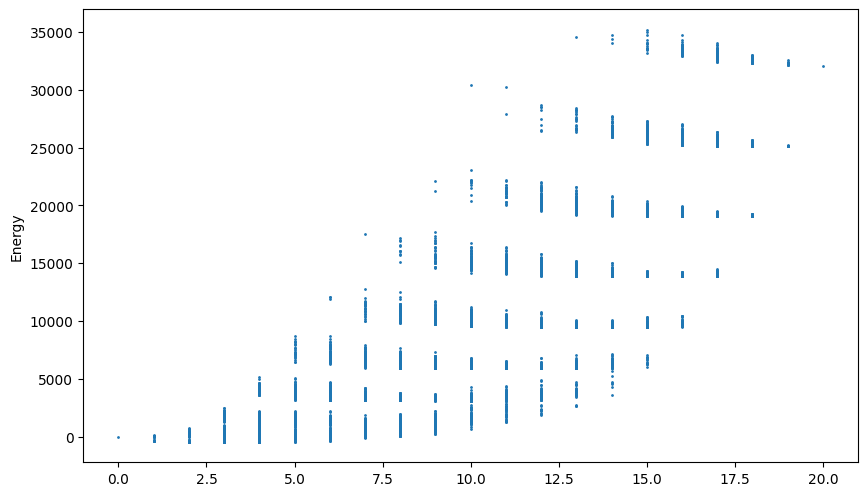

Best found: [6, 7, 19]
count: 3
Energy: -428.0
Solutions Sampled: 15422
[6, 7, 19] -428.0
6 14 6
7 16 5
Items added to Knapsack [6, 7]
Total value: 30
Total weight: 11
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
FAIL: Weight match condition not met 11 10


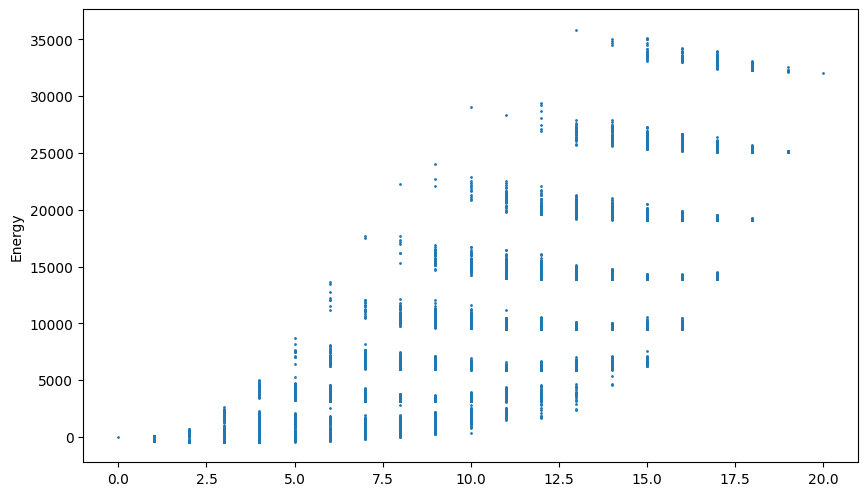

Best found: [2, 4, 5, 19]
count: 4
Energy: -428.0
Solutions Sampled: 15422
[2, 4, 5, 19] -428.0
2 6 2
4 10 3
5 12 5
Items added to Knapsack [2, 4, 5]
Total value: 28
Total weight: 10
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
OK: Condition met 10


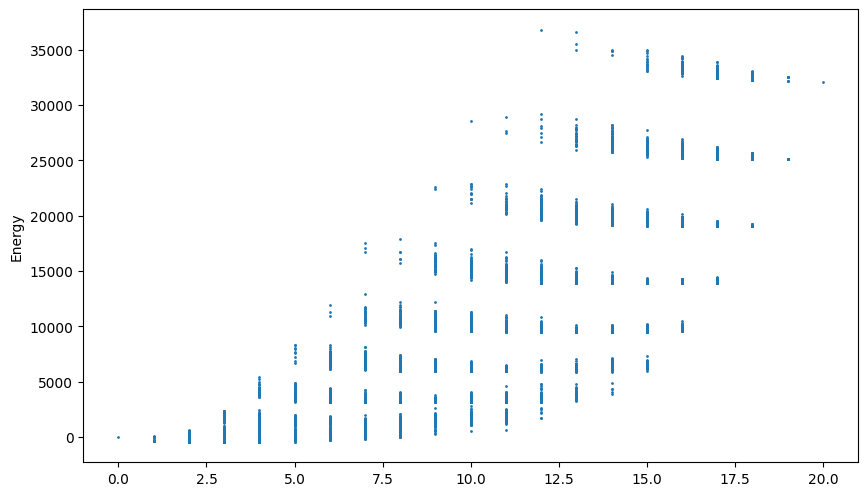

Best found: [6, 7, 19]
count: 3
Energy: -428.0
Solutions Sampled: 15422
[6, 7, 19] -428.0
6 14 6
7 16 5
Items added to Knapsack [6, 7]
Total value: 30
Total weight: 11
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
FAIL: Weight match condition not met 11 10


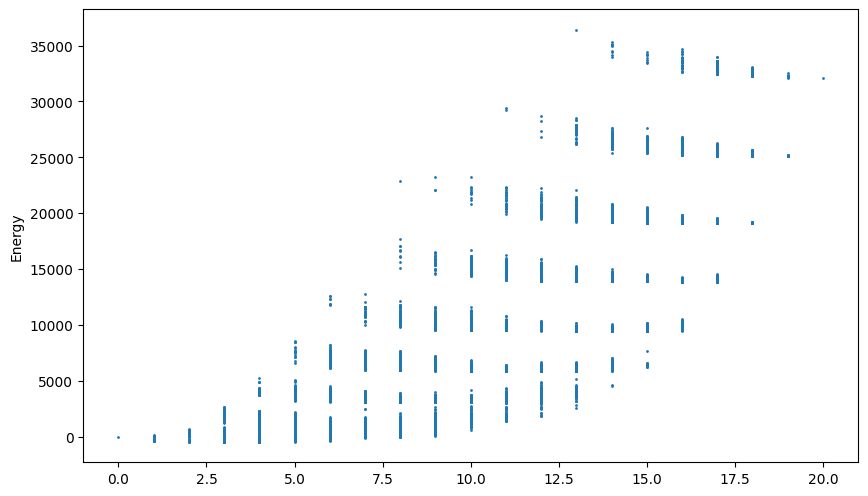

Best found: [3, 4, 7, 19]
count: 4
Energy: -432.0
Solutions Sampled: 15422
[3, 4, 7, 19] -432.0
3 8 3
4 10 3
7 16 5
Items added to Knapsack [3, 4, 7]
Total value: 34
Total weight: 11
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
FAIL: Weight match condition not met 11 10


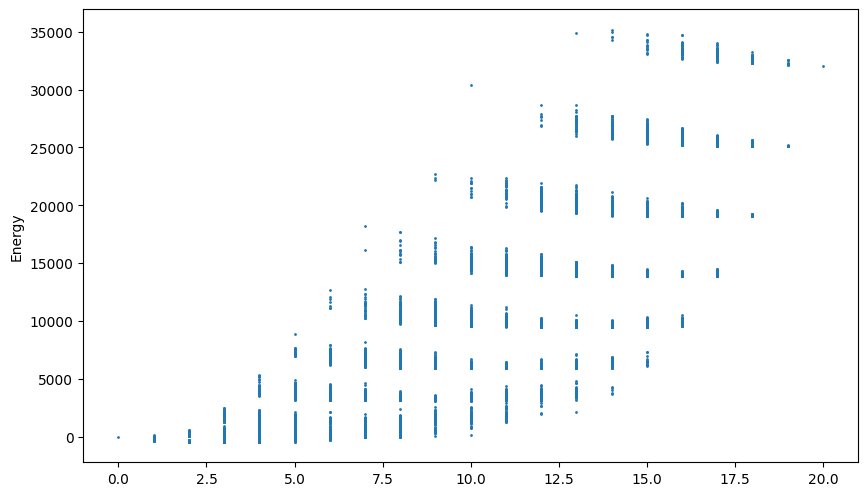

Best found: [5, 7, 19]
count: 3
Energy: -428.0
Solutions Sampled: 15422
[5, 7, 19] -428.0
5 12 5
7 16 5
Items added to Knapsack [5, 7]
Total value: 28
Total weight: 10
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
OK: Condition met 10


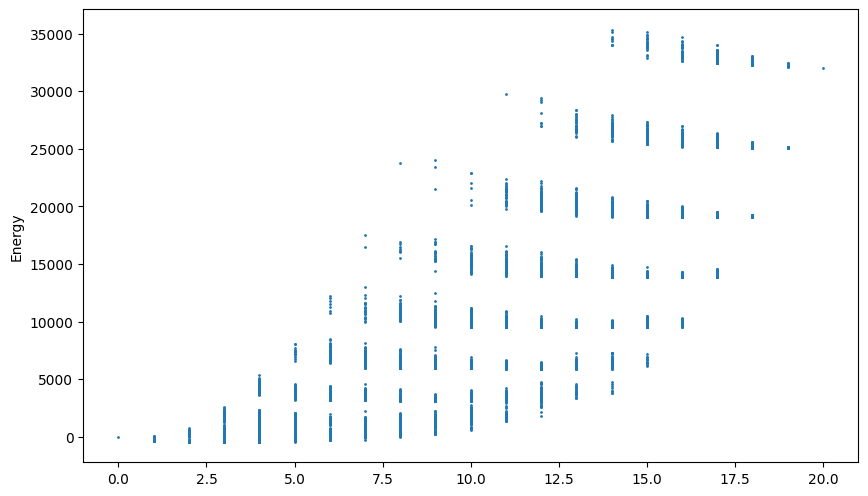

Best found: [2, 4, 7, 19]
count: 4
Energy: -432.0
Solutions Sampled: 15422
[2, 4, 7, 19] -432.0
2 6 2
4 10 3
7 16 5
Items added to Knapsack [2, 4, 7]
Total value: 32
Total weight: 10
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
OK: Condition met 10


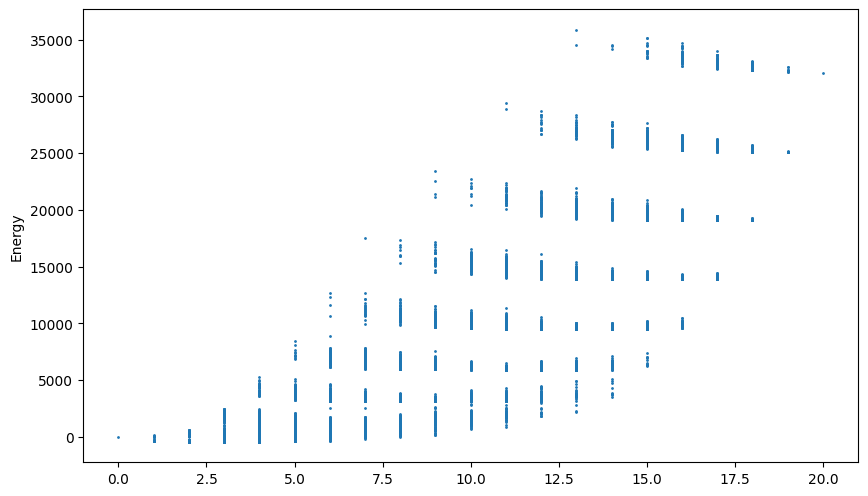

Best found: [6, 7, 19]
count: 3
Energy: -428.0
Solutions Sampled: 15422
[6, 7, 19] -428.0
6 14 6
7 16 5
Items added to Knapsack [6, 7]
Total value: 30
Total weight: 11
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
FAIL: Weight match condition not met 11 10


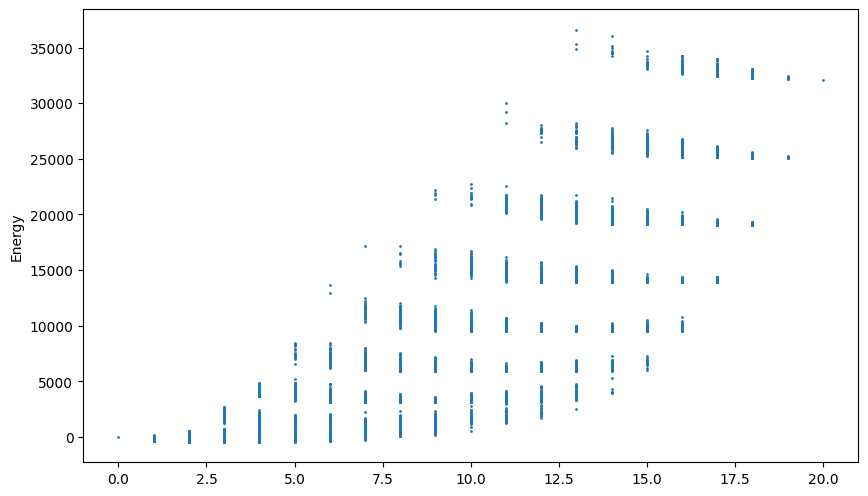

Best found: [4, 7, 17]
count: 3
Energy: -426.0
Solutions Sampled: 15422
[4, 7, 17] -426.0
4 10 3
7 16 5
Items added to Knapsack [4, 7]
Total value: 26
Total weight: 8
Condition 1 - Only one weight should be selected.
OK: condition met [8]
Condition 2 - Total weight should be equal to weight selected
OK: Condition met 8


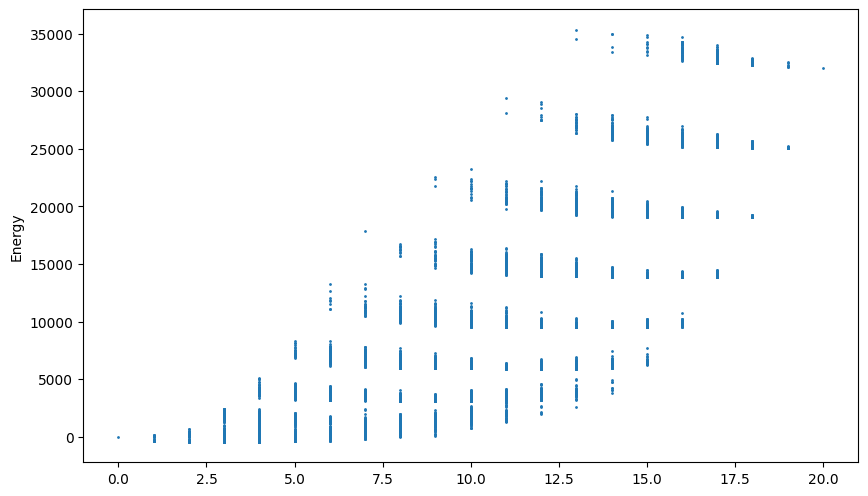

Best found: [2, 4, 7, 18]
count: 4
Energy: -430.0
Solutions Sampled: 15422
[2, 4, 7, 18] -430.0
2 6 2
4 10 3
7 16 5
Items added to Knapsack [2, 4, 7]
Total value: 32
Total weight: 10
Condition 1 - Only one weight should be selected.
OK: condition met [9]
Condition 2 - Total weight should be equal to weight selected
FAIL: Weight match condition not met 10 9


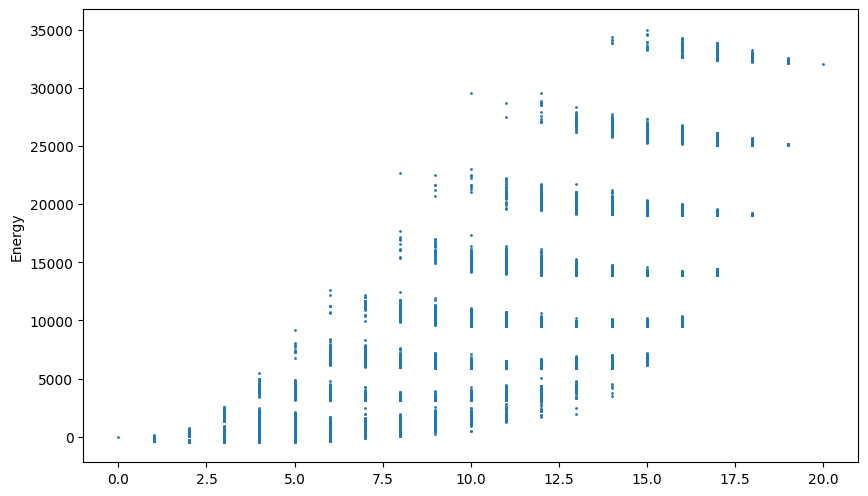

Best found: [2, 3, 7, 19]
count: 4
Energy: -430.0
Solutions Sampled: 15422
[2, 3, 7, 19] -430.0
2 6 2
3 8 3
7 16 5
Items added to Knapsack [2, 3, 7]
Total value: 30
Total weight: 10
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
OK: Condition met 10


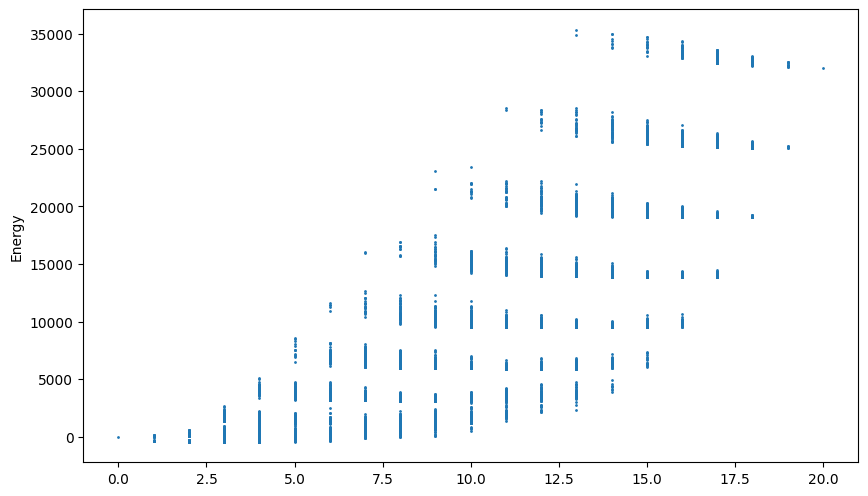

Best found: [2, 3, 7, 19]
count: 4
Energy: -430.0
Solutions Sampled: 15422
[2, 3, 7, 19] -430.0
2 6 2
3 8 3
7 16 5
Items added to Knapsack [2, 3, 7]
Total value: 30
Total weight: 10
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
OK: Condition met 10


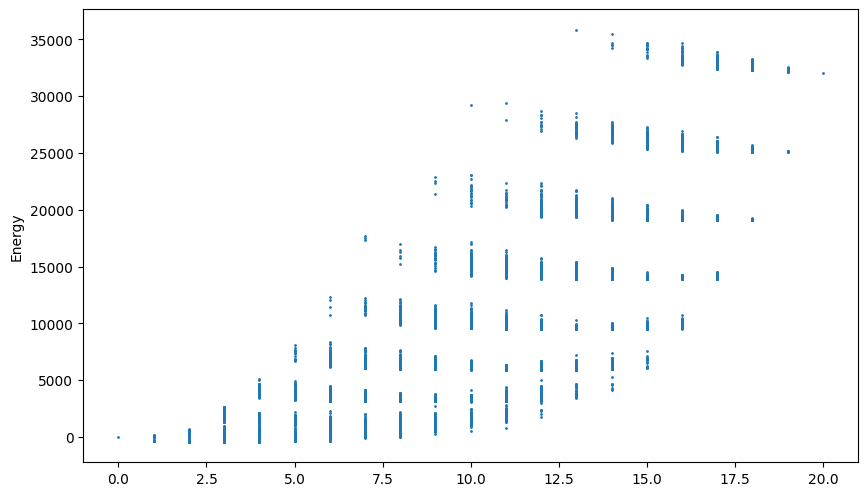

Best found: [5, 7, 19]
count: 3
Energy: -428.0
Solutions Sampled: 15422
[5, 7, 19] -428.0
5 12 5
7 16 5
Items added to Knapsack [5, 7]
Total value: 28
Total weight: 10
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
OK: Condition met 10


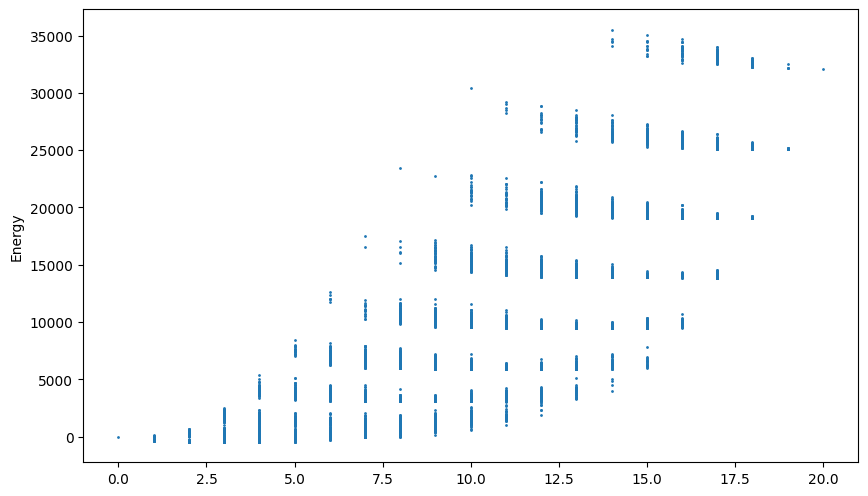

Best found: [5, 7, 19]
count: 3
Energy: -428.0
Solutions Sampled: 15422
[5, 7, 19] -428.0
5 12 5
7 16 5
Items added to Knapsack [5, 7]
Total value: 28
Total weight: 10
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
OK: Condition met 10


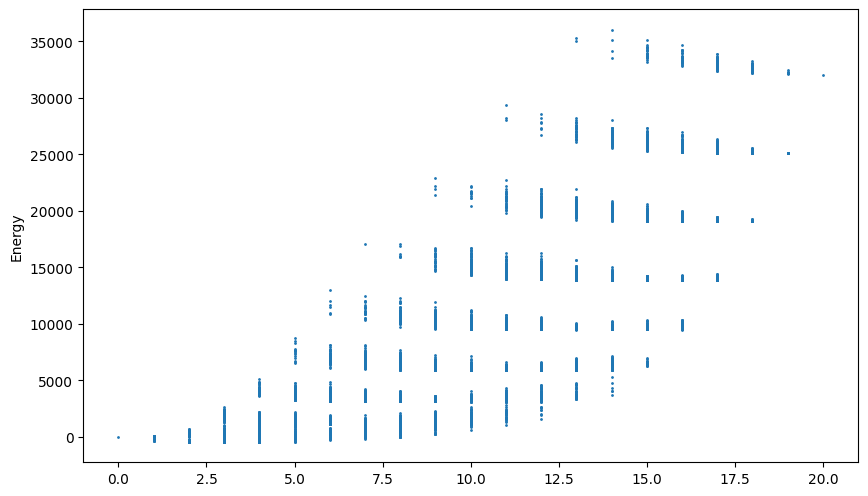

Best found: [2, 4, 5, 19]
count: 4
Energy: -428.0
Solutions Sampled: 15422
[2, 4, 5, 19] -428.0
2 6 2
4 10 3
5 12 5
Items added to Knapsack [2, 4, 5]
Total value: 28
Total weight: 10
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
OK: Condition met 10


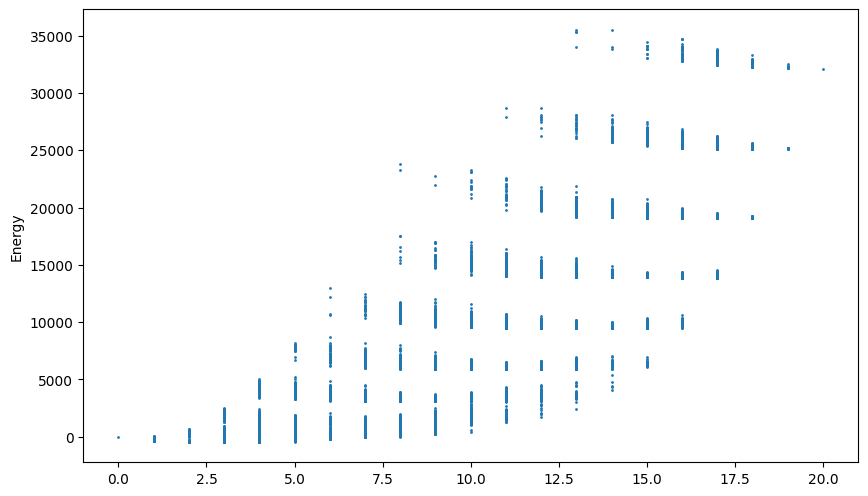

Best found: [5, 7, 19]
count: 3
Energy: -428.0
Solutions Sampled: 15422
[5, 7, 19] -428.0
5 12 5
7 16 5
Items added to Knapsack [5, 7]
Total value: 28
Total weight: 10
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
OK: Condition met 10


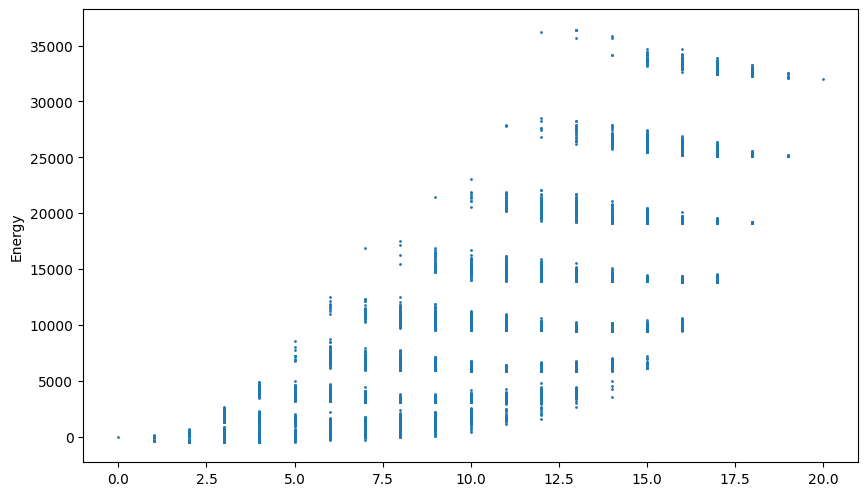

Best found: [3, 4, 7, 19]
count: 4
Energy: -432.0
Solutions Sampled: 15422
[3, 4, 7, 19] -432.0
3 8 3
4 10 3
7 16 5
Items added to Knapsack [3, 4, 7]
Total value: 34
Total weight: 11
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
FAIL: Weight match condition not met 11 10


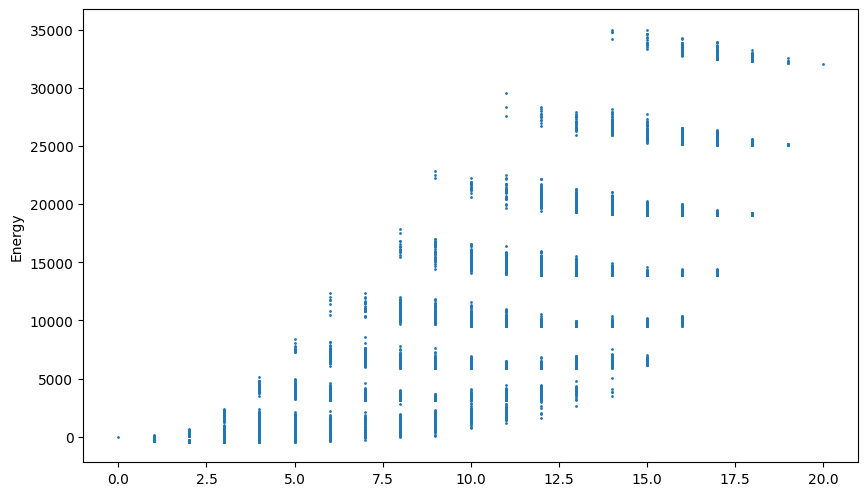

Best found: [6, 7, 19]
count: 3
Energy: -428.0
Solutions Sampled: 15422
[6, 7, 19] -428.0
6 14 6
7 16 5
Items added to Knapsack [6, 7]
Total value: 30
Total weight: 11
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
FAIL: Weight match condition not met 11 10


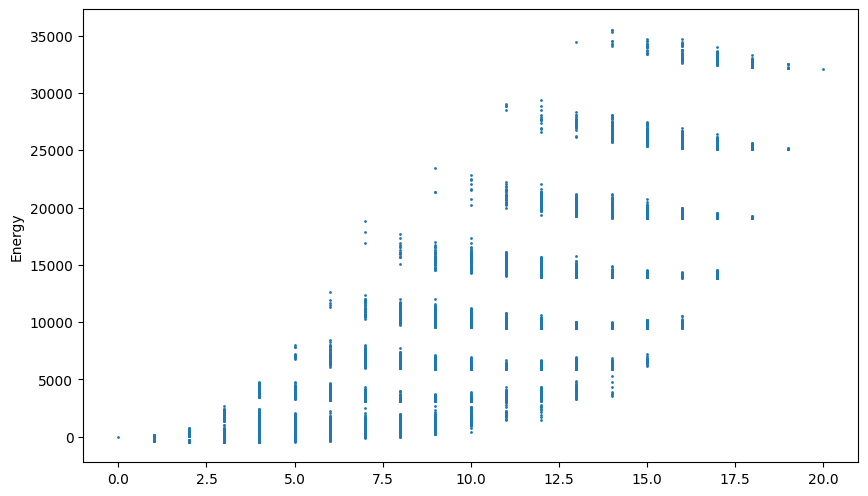

Best found: [2, 4, 7, 18]
count: 4
Energy: -430.0
Solutions Sampled: 15422
[2, 4, 7, 18] -430.0
2 6 2
4 10 3
7 16 5
Items added to Knapsack [2, 4, 7]
Total value: 32
Total weight: 10
Condition 1 - Only one weight should be selected.
OK: condition met [9]
Condition 2 - Total weight should be equal to weight selected
FAIL: Weight match condition not met 10 9


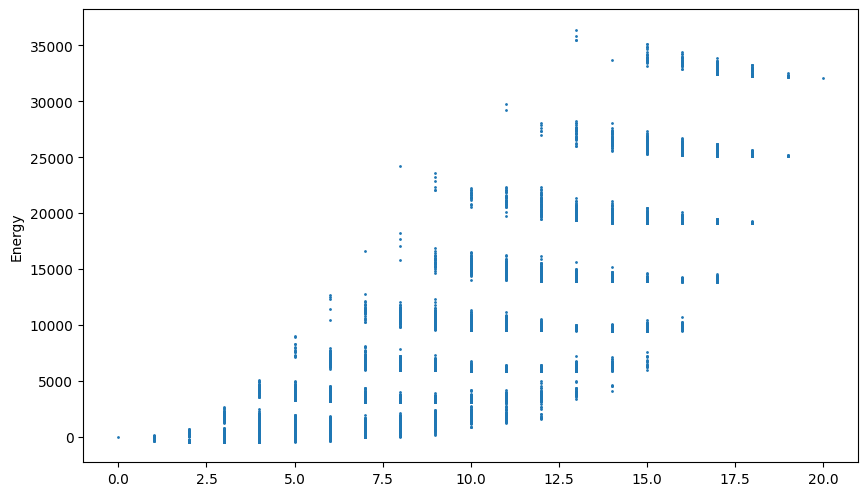

Best found: [3, 4, 7, 19]
count: 4
Energy: -432.0
Solutions Sampled: 15422
[3, 4, 7, 19] -432.0
3 8 3
4 10 3
7 16 5
Items added to Knapsack [3, 4, 7]
Total value: 34
Total weight: 11
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
FAIL: Weight match condition not met 11 10


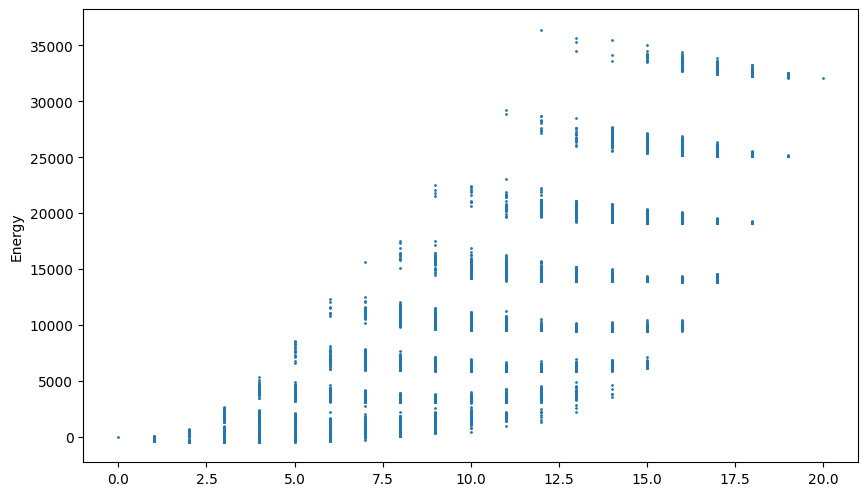

Best found: [5, 7, 19]
count: 3
Energy: -428.0
Solutions Sampled: 15422
[5, 7, 19] -428.0
5 12 5
7 16 5
Items added to Knapsack [5, 7]
Total value: 28
Total weight: 10
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
OK: Condition met 10


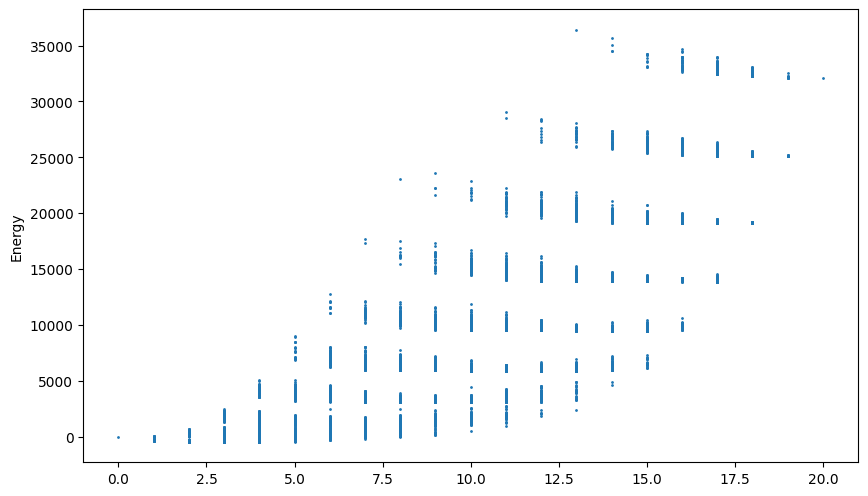

Best found: [3, 4, 7, 19]
count: 4
Energy: -432.0
Solutions Sampled: 15422
[3, 4, 7, 19] -432.0
3 8 3
4 10 3
7 16 5
Items added to Knapsack [3, 4, 7]
Total value: 34
Total weight: 11
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
FAIL: Weight match condition not met 11 10


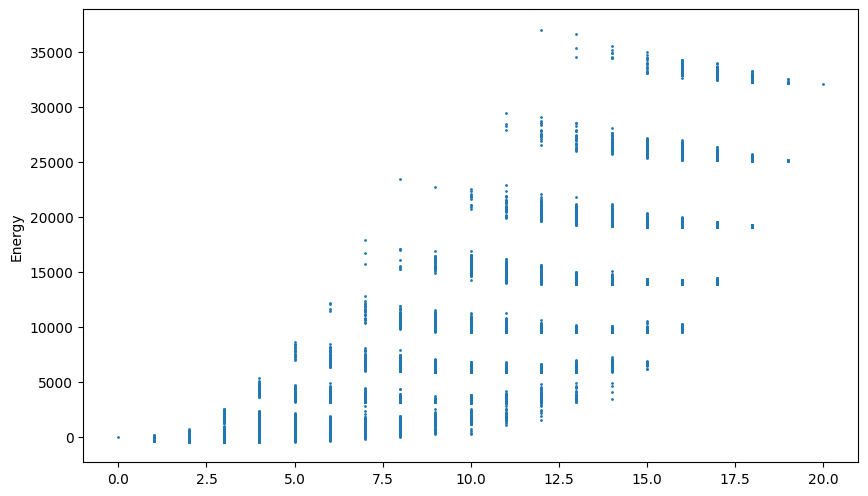

Best found: [3, 4, 7, 19]
count: 4
Energy: -432.0
Solutions Sampled: 15422
[3, 4, 7, 19] -432.0
3 8 3
4 10 3
7 16 5
Items added to Knapsack [3, 4, 7]
Total value: 34
Total weight: 11
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
FAIL: Weight match condition not met 11 10


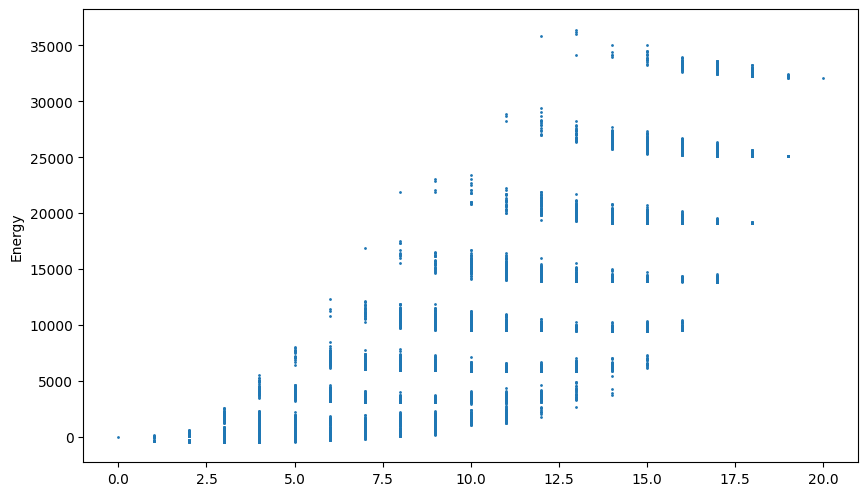

Best found: [2, 4, 7, 19]
count: 4
Energy: -432.0
Solutions Sampled: 15422
[2, 4, 7, 19] -432.0
2 6 2
4 10 3
7 16 5
Items added to Knapsack [2, 4, 7]
Total value: 32
Total weight: 10
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
OK: Condition met 10


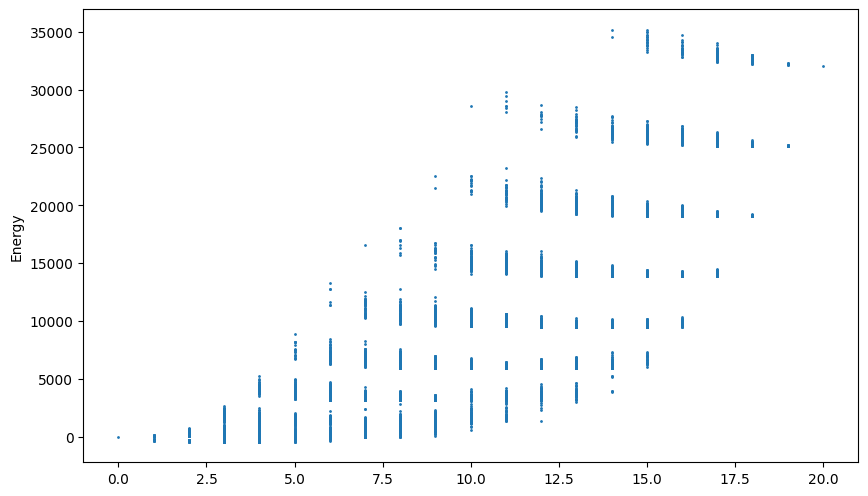

Best found: [3, 4, 7, 19]
count: 4
Energy: -432.0
Solutions Sampled: 15422
[3, 4, 7, 19] -432.0
3 8 3
4 10 3
7 16 5
Items added to Knapsack [3, 4, 7]
Total value: 34
Total weight: 11
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
FAIL: Weight match condition not met 11 10
-------Success!------------
0 [4, 7] Value 26 Wt 8 energy -426.0
1 [0, 4, 7] Value 28 Wt 10 energy -428.0
2 [5, 7] Value 28 Wt 10 energy -428.0
3 [2, 3, 7] Value 30 Wt 10 energy -430.0
4 [5, 7] Value 28 Wt 10 energy -428.0
5 [2, 3, 7] Value 30 Wt 10 energy -430.0
6 [2, 4, 7] Value 32 Wt 10 energy -432.0
7 [5, 7] Value 28 Wt 10 energy -428.0
8 [2, 3, 7] Value 30 Wt 10 energy -430.0
9 [2, 4, 7] Value 32 Wt 10 energy -432.0
10 [5, 7] Value 28 Wt 10 energy -428.0
11 [2, 3, 7] Value 30 Wt 10 energy -430.0
12 [2, 4, 7] Value 32 Wt 10 energy -432.0
13 [2, 3, 7] Value 30 Wt 10 energy -430.0
14 [2, 4, 5] Value 28 Wt 10 energy -428.0
15 [5, 

In [59]:
cond1_fail=0
cond2_fail=0
good_solution=[]
good_value=[]
good_weight=[]
good_energy=[]
count=50
for trial in range (count):

    solution=ProbabilisticSampler(Mf,1000)
    print(solution[0],solution[1])

    # check if constraints were met
    item_list=[]
    Vt=0
    Wt=0
    for i in solution[0]:
        if i <N:
            Vt+=value[i]
            Wt+=weight[i]
            print(i, value[i], weight[i])
            item_list.append(i)
    print('Items added to Knapsack',item_list)
    print('Total value:',Vt)
    print('Total weight:',Wt)

    check_y=0
    weight_list=[]
    for i in solution[0]:
        if i>=N:
            check_y+=1
            weight_list.append(i-N+1)
    print('Condition 1 - Only one weight should be selected.')
    if check_y>1:
        print('FAIL: One weight condition not met', weight_list)
        cond1_fail+=1

    else:
        print('OK: condition met', weight_list)
        print('Condition 2 - Total weight should be equal to weight selected')
        if Wt==weight_list[0]:
            print('OK: Condition met', Wt)
            good_solution.append(item_list)
            good_value.append(Vt)
            good_weight.append(Wt)
            good_energy.append(solution[1])
            
        else:
            print('FAIL: Weight match condition not met', Wt, weight_list[0])
            cond2_fail+=1

good_count=len(good_value)
if good_count==0:
    print('-------FAIL!------------')
    print('No good values found')
    print('Condition 1: One weight condition failed',(cond1_fail/count)*100, '%')
    print('Condition 2: Weight match condition failed',(cond2_fail/count)*100, '%')
else:
    print('-------Success!------------')
    for i in range(good_count):
        
        print(i, good_solution[i], 'Value', good_value[i],'Wt', good_weight[i], 'energy', good_energy[i])



## Run on D-Wave

In [65]:
# run on 2000Q
chain_strength =15
response=run_dwave(Mf,chain_strength)

26214400
chain strength: 15 shots: 3000
      0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 ... 19 energy num_oc. ...
1034  0  1  1  0  0  1  1  0  0  0  0  0  0  0  0  0 ...  0  -34.0       1 ...
1017  0  0  1  0  0  1  1  0  0  0  0  0  0  0  0  0 ...  0  -24.0       1 ...
999   1  1  1  0  0  1  1  0  0  0  0  0  0  0  0  0 ...  0  -20.0       1 ...
1135  1  1  1  0  0  1  1  0  0  0  0  0  0  0  0  0 ...  0  -20.0       1 ...
1074  0  1  0  0  0  1  1  1  0  0  0  0  0  0  0  0 ...  0  -14.0       1 ...
1174  0  1  1  0  1  1  1  0  0  0  0  0  0  0  0  0 ...  0  -14.0       1 ...
1187  0  0  1  1  0  0  1  0  1  0  0  0  0  0  0  0 ...  0  -14.0       1 ...
1014  0  0  0  0  0  1  1  0  1  0  0  0  0  0  0  0 ...  0  -12.0       1 ...
1051  0  1  1  1  0  1  1  0  0  0  0  0  0  0  0  0 ...  0  -12.0       1 ...
1144  0  1  1  1  0  1  1  0  0  0  0  0  0  0  0  0 ...  0  -12.0       1 ...
1112  0  1  1  0  0  0  1  0  1  0  0  0  0  0  0  0 ...  0  -10.0       1 ...
1136  0  0  

In [66]:
count=3000
cond1_fail=0
cond2_fail=0
good_solution=[]
good_value=[]
good_weight=[]
good_energy=[]

temp_sol=[]
temp_energy=[]
for i in (response.data()):   
    temp=[]

    #print(solution[i], energy[i], quantity[i])
    for j in range(N+wc):
        if i[0][j]==1:
            temp.append(int(j))
    temp_sol.append(temp)
    temp_energy.append(i[1])

for trial in range(len(temp_sol)):    
    
    item_list=[]
    Vt=0
    Wt=0
    for i in temp_sol[trial]:
        if i <N:
            Vt+=value[i]
            Wt+=weight[i]
            #print(i, value[i], weight[i])
            item_list.append(i)
    #print('Items added to Knapsack',item_list)
    #print('Total value:',Vt)
    #print('Total weight:',Wt)

    check_y=0
    weight_list=[]
    for i in temp_sol[trial]:
        if i>=N:
            check_y+=1
            weight_list.append(i-N+1)
    #print('Condition 1 - Only one weight should be selected.')
    if check_y>1:
        #print('FAIL: One weight condition not met', weight_list)
        cond1_fail+=1

    elif check_y==1:
        #print('OK: condition met', weight_list)
        #print('Condition 2 - Total weight should be equal to weight selected')
        if Wt==weight_list[0]:
            #print('OK: Condition met', Wt)
            good_solution.append(item_list)
            good_value.append(Vt)
            good_weight.append(Wt)
            good_energy.append(temp_energy[trial])
            
        else:
            #print('FAIL: Weight match condition not met', Wt, weight_list[0])
            cond2_fail+=1
    #else:
        #print('No weight was found')

good_count=len(good_value)
if good_count==0:
    print('-------FAIL!------------')
    print('No good values found')
    print('Condition 1: One weight condition failed',(cond1_fail/count)*100, '%')
    print('Condition 2: Weight match condition failed',(cond2_fail/count)*100, '%')
else:
    print('-------Success!------------')
    for i in range(good_count):
        
        #print(i, good_solution[i], 'Value', good_value[i],'Wt', good_weight[i])
        print(i, good_solution[i], 'Value', good_value[i],'Wt', good_weight[i], 'energy', good_energy[i])

-------FAIL!------------
No good values found
Condition 1: One weight condition failed 39.6 %
Condition 2: Weight match condition failed 0.0 %


Run on D-Wave Simulated Annealer

In [62]:
success=0
expected='00101001000000000001'
total=1000
for i in range(total):
    result=run_neal(Mf)
    if result==expected:
        success+=1
print('percent success:',100*success/total)
    

Sample(sample={0: 0, 1: 1, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0}, energy=-410.0, num_occurrences=1)
{0: 0, 1: 1, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0}
01100000000000100000
Sample(sample={0: 0, 1: 0, 2: 1, 3: 1, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0}, energy=-414.0, num_occurrences=1)
{0: 0, 1: 0, 2: 1, 3: 1, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0}
00110000000000100000
Sample(sample={0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 1, 19: 0}, energy=-424.0, num_occurrences=1)
{0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 1, 19: 0}
00001010000000000010
Samp

Sample(sample={0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 1, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 1}, energy=-426.0, num_occurrences=1)
{0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 1, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 1}
00001000100000000001
Sample(sample={0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 1, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0}, energy=-414.0, num_occurrences=1)
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 1, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0}
00000001000001000000
Sample(sample={0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 1, 17: 0, 18: 0, 19: 0}, energy=-424.0, num_occurrences=1)
{0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 1, 17: 0, 18: 0, 19: 0}
00001001000000001000
Samp

Sample(sample={0: 0, 1: 0, 2: 1, 3: 1, 4: 0, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 1, 19: 0}, energy=-424.0, num_occurrences=1)
{0: 0, 1: 0, 2: 1, 3: 1, 4: 0, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 1, 19: 0}
00110100000000000010
Sample(sample={0: 0, 1: 0, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 1, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0}, energy=-404.0, num_occurrences=1)
{0: 0, 1: 0, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 1, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0}
00100000001000000000
Sample(sample={0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 1, 17: 0, 18: 0, 19: 0}, energy=-424.0, num_occurrences=1)
{0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 1, 17: 0, 18: 0, 19: 0}
00001001000000001000
Samp

Sample(sample={0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 1, 17: 0, 18: 0, 19: 0}, energy=-424.0, num_occurrences=1)
{0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 1, 17: 0, 18: 0, 19: 0}
00001001000000001000
Sample(sample={0: 0, 1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0}, energy=-416.0, num_occurrences=1)
{0: 0, 1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0}
00101000000000100000
Sample(sample={0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 1}, energy=-428.0, num_occurrences=1)
{0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 1}
00011100000000000001
Samp

Sample(sample={0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 1, 18: 0, 19: 0}, energy=-420.0, num_occurrences=1)
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 1, 18: 0, 19: 0}
00000101000000000100
Sample(sample={0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 1, 19: 0}, energy=-420.0, num_occurrences=1)
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 1, 19: 0}
00000000010000000010
Sample(sample={0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 1, 19: 0}, energy=-426.0, num_occurrences=1)
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 1, 19: 0}
00000101000000000010
Samp

Sample(sample={0: 0, 1: 0, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 1, 16: 0, 17: 0, 18: 0, 19: 0}, energy=-420.0, num_occurrences=1)
{0: 0, 1: 0, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 1, 16: 0, 17: 0, 18: 0, 19: 0}
00100001000000010000
Sample(sample={0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 1, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0}, energy=-410.0, num_occurrences=1)
{0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 1, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0}
00001000000010000000
Sample(sample={0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 1}, energy=-428.0, num_occurrences=1)
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 1}
00000011000000000001
Samp

Sample(sample={0: 0, 1: 0, 2: 0, 3: 1, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 1, 17: 0, 18: 0, 19: 0}, energy=-422.0, num_occurrences=1)
{0: 0, 1: 0, 2: 0, 3: 1, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 1, 17: 0, 18: 0, 19: 0}
00010001000000001000
Sample(sample={0: 0, 1: 0, 2: 0, 3: 1, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 1, 17: 0, 18: 0, 19: 0}, energy=-422.0, num_occurrences=1)
{0: 0, 1: 0, 2: 0, 3: 1, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 1, 17: 0, 18: 0, 19: 0}
00010001000000001000
Sample(sample={0: 0, 1: 0, 2: 1, 3: 1, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 1, 19: 0}, energy=-428.0, num_occurrences=1)
{0: 0, 1: 0, 2: 1, 3: 1, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 1, 19: 0}
00110001000000000010
Samp

Sample(sample={0: 0, 1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 1, 19: 0}, energy=-430.0, num_occurrences=1)
{0: 0, 1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 1, 19: 0}
00101001000000000010
Sample(sample={0: 0, 1: 0, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 1, 16: 0, 17: 0, 18: 0, 19: 0}, energy=-420.0, num_occurrences=1)
{0: 0, 1: 0, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 1, 16: 0, 17: 0, 18: 0, 19: 0}
00100001000000010000
Sample(sample={0: 0, 1: 0, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 1, 17: 0, 18: 0, 19: 0}, energy=-422.0, num_occurrences=1)
{0: 0, 1: 0, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 1, 17: 0, 18: 0, 19: 0}
00100001000000001000
Samp

Sample(sample={0: 1, 1: 0, 2: 1, 3: 1, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 1}, energy=-426.0, num_occurrences=1)
{0: 1, 1: 0, 2: 1, 3: 1, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 1}
10111000000000000001
Sample(sample={0: 0, 1: 0, 2: 1, 3: 0, 4: 1, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 1}, energy=-428.0, num_occurrences=1)
{0: 0, 1: 0, 2: 1, 3: 0, 4: 1, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 1}
00101100000000000001
Sample(sample={0: 0, 1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 1, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0}, energy=-414.0, num_occurrences=1)
{0: 0, 1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 1, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0}
00101000000001000000
Samp

Sample(sample={0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 1, 17: 0, 18: 0, 19: 0}, energy=-424.0, num_occurrences=1)
{0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 1, 17: 0, 18: 0, 19: 0}
00001001000000001000
Sample(sample={0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 1}, energy=-428.0, num_occurrences=1)
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 1}
00000011000000000001
Sample(sample={0: 0, 1: 0, 2: 1, 3: 0, 4: 0, 5: 0, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 1, 17: 0, 18: 0, 19: 0}, energy=-418.0, num_occurrences=1)
{0: 0, 1: 0, 2: 1, 3: 0, 4: 0, 5: 0, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 1, 17: 0, 18: 0, 19: 0}
00100010000000001000
Samp

Sample(sample={0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0}, energy=-412.0, num_occurrences=1)
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0}
00000010000000100000
Sample(sample={0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 1, 17: 0, 18: 0, 19: 0}, energy=-422.0, num_occurrences=1)
{0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 1, 17: 0, 18: 0, 19: 0}
00111000000000001000
Sample(sample={0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 1, 18: 0, 19: 0}, energy=-426.0, num_occurrences=1)
{0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 1, 18: 0, 19: 0}
00001001000000000100
Samp

Sample(sample={0: 0, 1: 0, 2: 1, 3: 0, 4: 0, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 1, 17: 0, 18: 0, 19: 0}, energy=-418.0, num_occurrences=1)
{0: 0, 1: 0, 2: 1, 3: 0, 4: 0, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 1, 17: 0, 18: 0, 19: 0}
00100100000000001000
Sample(sample={0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 1}, energy=-428.0, num_occurrences=1)
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 1}
00000011000000000001
Sample(sample={0: 0, 1: 0, 2: 1, 3: 1, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 1, 19: 0}, energy=-428.0, num_occurrences=1)
{0: 0, 1: 0, 2: 1, 3: 1, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 1, 19: 0}
00110001000000000010
Samp

Sample(sample={0: 0, 1: 0, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 1, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 1}, energy=-424.0, num_occurrences=1)
{0: 0, 1: 0, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 1, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 1}
00100000100000000001
Sample(sample={0: 1, 1: 0, 2: 1, 3: 1, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 1, 19: 0}, energy=-424.0, num_occurrences=1)
{0: 1, 1: 0, 2: 1, 3: 1, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 1, 19: 0}
10111000000000000010
Sample(sample={0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 1, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 1, 18: 0, 19: 0}, energy=-418.0, num_occurrences=1)
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 1, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 1, 18: 0, 19: 0}
00000000100000000100
Samp

Sample(sample={0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 1, 18: 0, 19: 0}, energy=-426.0, num_occurrences=1)
{0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 1, 18: 0, 19: 0}
00001001000000000100
Sample(sample={0: 0, 1: 1, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0}, energy=-410.0, num_occurrences=1)
{0: 0, 1: 1, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0}
01100000000000100000
Sample(sample={0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 1, 18: 0, 19: 0}, energy=-426.0, num_occurrences=1)
{0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 1, 18: 0, 19: 0}
00001001000000000100
Samp

Sample(sample={0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 1, 19: 0}, energy=-424.0, num_occurrences=1)
{0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 1, 19: 0}
00001010000000000010
Sample(sample={0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0}, energy=-416.0, num_occurrences=1)
{0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0}
00011000000000100000
Sample(sample={0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 1, 18: 0, 19: 0}, energy=-422.0, num_occurrences=1)
{0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 1, 18: 0, 19: 0}
00001100000000000100
Samp

Sample(sample={0: 0, 1: 0, 2: 1, 3: 0, 4: 1, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 1, 19: 0}, energy=-426.0, num_occurrences=1)
{0: 0, 1: 0, 2: 1, 3: 0, 4: 1, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 1, 19: 0}
00101100000000000010
Sample(sample={0: 0, 1: 0, 2: 1, 3: 0, 4: 0, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 1, 16: 0, 17: 0, 18: 0, 19: 0}, energy=-416.0, num_occurrences=1)
{0: 0, 1: 0, 2: 1, 3: 0, 4: 0, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 1, 16: 0, 17: 0, 18: 0, 19: 0}
00100100000000010000
Sample(sample={0: 0, 1: 0, 2: 0, 3: 1, 4: 0, 5: 0, 6: 0, 7: 0, 8: 1, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 1}, energy=-424.0, num_occurrences=1)
{0: 0, 1: 0, 2: 0, 3: 1, 4: 0, 5: 0, 6: 0, 7: 0, 8: 1, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 1}
00010000100000000001
Samp

Sample(sample={0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 1, 17: 0, 18: 0, 19: 0}, energy=-416.0, num_occurrences=1)
{0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 1, 17: 0, 18: 0, 19: 0}
00001010000000001000
Sample(sample={0: 0, 1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 1}, energy=-428.0, num_occurrences=1)
{0: 0, 1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 1}
00101010000000000001
Sample(sample={0: 0, 1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 1, 19: 0}, energy=-430.0, num_occurrences=1)
{0: 0, 1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 1, 19: 0}
00101001000000000010
Samp

Sample(sample={0: 0, 1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 1, 19: 0}, energy=-430.0, num_occurrences=1)
{0: 0, 1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 1, 19: 0}
00101001000000000010
Sample(sample={0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0}, energy=-416.0, num_occurrences=1)
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0}
00000001000000100000
Sample(sample={0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 1, 18: 0, 19: 0}, energy=-424.0, num_occurrences=1)
{0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 1, 18: 0, 19: 0}
00111000000000000100
Samp

Sample(sample={0: 0, 1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 1}, energy=-432.0, num_occurrences=1)
{0: 0, 1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 1}
00101001000000000001
Sample(sample={0: 0, 1: 0, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 1, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 1, 19: 0}, energy=-422.0, num_occurrences=1)
{0: 0, 1: 0, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 1, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 1, 19: 0}
00100000100000000010
Sample(sample={0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 1, 17: 0, 18: 0, 19: 0}, energy=-424.0, num_occurrences=1)
{0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 1, 17: 0, 18: 0, 19: 0}
00001001000000001000
Samp

Sample(sample={0: 0, 1: 0, 2: 1, 3: 0, 4: 0, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 1, 17: 0, 18: 0, 19: 0}, energy=-418.0, num_occurrences=1)
{0: 0, 1: 0, 2: 1, 3: 0, 4: 0, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 1, 17: 0, 18: 0, 19: 0}
00100100000000001000
Sample(sample={0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0}, energy=-416.0, num_occurrences=1)
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0}
00000001000000100000
Sample(sample={0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 1, 16: 0, 17: 0, 18: 0, 19: 0}, energy=-414.0, num_occurrences=1)
{0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 1, 16: 0, 17: 0, 18: 0, 19: 0}
00001100000000010000
Samp

Sample(sample={0: 0, 1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 1, 19: 0}, energy=-430.0, num_occurrences=1)
{0: 0, 1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 1, 19: 0}
00101001000000000010
Sample(sample={0: 0, 1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 1}, energy=-432.0, num_occurrences=1)
{0: 0, 1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 1}
00101001000000000001
Sample(sample={0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 1, 19: 0}, energy=-424.0, num_occurrences=1)
{0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 1, 19: 0}
00001010000000000010
Samp

Sample(sample={0: 0, 1: 0, 2: 0, 3: 1, 4: 0, 5: 0, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 1, 18: 0, 19: 0}, energy=-420.0, num_occurrences=1)
{0: 0, 1: 0, 2: 0, 3: 1, 4: 0, 5: 0, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 1, 18: 0, 19: 0}
00010010000000000100
Sample(sample={0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 1, 18: 0, 19: 0}, energy=-422.0, num_occurrences=1)
{0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 1, 18: 0, 19: 0}
00001100000000000100
Sample(sample={0: 0, 1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 1, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0}, energy=-414.0, num_occurrences=1)
{0: 0, 1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 1, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0}
00101000000001000000
Samp

Sample(sample={0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 1, 17: 0, 18: 0, 19: 0}, energy=-424.0, num_occurrences=1)
{0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 1, 17: 0, 18: 0, 19: 0}
00001001000000001000
Sample(sample={0: 0, 1: 0, 2: 1, 3: 1, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 1}, energy=-430.0, num_occurrences=1)
{0: 0, 1: 0, 2: 1, 3: 1, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 1}
00110001000000000001
Sample(sample={0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 1, 16: 0, 17: 0, 18: 0, 19: 0}, energy=-418.0, num_occurrences=1)
{0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 1, 16: 0, 17: 0, 18: 0, 19: 0}
00011000000000010000
Samp

Sample(sample={0: 0, 1: 0, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 1, 16: 0, 17: 0, 18: 0, 19: 0}, energy=-420.0, num_occurrences=1)
{0: 0, 1: 0, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 1, 16: 0, 17: 0, 18: 0, 19: 0}
00100001000000010000
Sample(sample={0: 0, 1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 1, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0}, energy=-414.0, num_occurrences=1)
{0: 0, 1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 1, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0}
00101000000001000000
Sample(sample={0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0}, energy=-416.0, num_occurrences=1)
{0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0}
00011000000000100000
Samp

Sample(sample={0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 1, 17: 0, 18: 0, 19: 0}, energy=-424.0, num_occurrences=1)
{0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 1, 17: 0, 18: 0, 19: 0}
00001001000000001000
Sample(sample={0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 1}, energy=-432.0, num_occurrences=1)
{0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 1}
00011001000000000001
Sample(sample={0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 1}, energy=-432.0, num_occurrences=1)
{0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 1}
00011001000000000001
Samp

Sample(sample={0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 1, 18: 0, 19: 0}, energy=-426.0, num_occurrences=1)
{0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 1, 18: 0, 19: 0}
00001001000000000100
Sample(sample={0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 1, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0}, energy=-410.0, num_occurrences=1)
{0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 1, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0}
00001000000010000000
Sample(sample={0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 1, 19: 0}, energy=-426.0, num_occurrences=1)
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 1, 19: 0}
00000101000000000010
Samp

Sample(sample={0: 0, 1: 0, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 1, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 1, 19: 0}, energy=-422.0, num_occurrences=1)
{0: 0, 1: 0, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 1, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 1, 19: 0}
00100000100000000010
Sample(sample={0: 1, 1: 0, 2: 1, 3: 1, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 1, 19: 0}, energy=-424.0, num_occurrences=1)
{0: 1, 1: 0, 2: 1, 3: 1, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 1, 19: 0}
10111000000000000010
Sample(sample={0: 0, 1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 1}, energy=-432.0, num_occurrences=1)
{0: 0, 1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 1}
00101001000000000001
Samp

## Run on Amazon Braket Simulator SV1

In [55]:
device=set_device('SV1')
estimate_cost(device,num_shots=1000)

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
simulator cost per  minute : $ 0.075
total cost cannot be estimated


[0.1 0.2 0.3 0.4 0.5]
T   : |0|1|    2    |   3   |   4   |       5       |       6       |          7          |          8           |             9              |              10              |                  11                   |                    12                    |                       13                        |                        14                         |                            15                            |                            16                            |                                17                                |                                18                                 |                                      19                                      |                                       20                                        |                                             21                                             |                                       22                                        |                              

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
device Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
num reads 1000
simulator cost per  minute : $ 0.075
total execution time:  65 ms
total cost estimated: $ 8.125000000000001e-05
{173279: 1, 818965: 1, 505409: 1, 384615: 1, 579067: 1, 624639: 1, 361432: 1, 541729: 1, 1011830: 1, 234972: 1, 38059: 1, 512522: 1, 367250: 1, 88162: 1, 664456: 1, 407591: 1, 882950: 1, 257664: 1, 420993: 1, 84531: 1, 269823: 1, 209855: 1, 437660: 1, 468669: 1, 450068: 1, 745627: 1, 129916: 1, 31915: 1, 17278: 1, 480485: 1, 885591: 1, 706204: 1, 692099: 1, 922999: 1, 955915: 1, 142572: 1, 249973: 1, 445009: 1, 677599: 1, 514895: 1, 206284: 1, 971531: 1, 340153: 1, 700709: 1, 598876: 1, 46607: 1, 688734: 1, 515721: 1, 70182: 1, 689614: 1, 626048: 1, 11956: 1, 837332: 1, 660621: 1, 550197: 1, 429580: 1, 669754: 1, 970010: 1, 274187: 1, 8925: 1, 923692: 1, 102639: 1, 901370: 1, 71181: 1, 685115: 1

T   : |0|1|    2    |   3   |   4   |       5       |       6       |          7          |          8           |             9              |              10              |                  11                   |                    12                    |                       13                        |                        14                         |                            15                            |                            16                            |                                17                                |                                18                                 |                                      19                                      |                                       20                                        |                                             21                                             |                                       22                                        |                                       23           

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
device Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
num reads 1000
simulator cost per  minute : $ 0.075
total execution time:  67 ms
total cost estimated: $ 8.375e-05
{890771: 1, 911793: 1, 39468: 1, 650244: 2, 722104: 1, 785648: 1, 570975: 1, 1029780: 1, 396986: 1, 882849: 1, 233134: 1, 242753: 1, 468044: 1, 1006287: 1, 623541: 1, 1009683: 1, 911886: 1, 544278: 1, 105995: 1, 52826: 1, 675356: 1, 547988: 1, 898242: 1, 2512: 1, 339992: 1, 972857: 1, 930324: 1, 229493: 1, 764854: 1, 939559: 1, 818311: 1, 755289: 1, 975107: 1, 160426: 1, 965306: 1, 528132: 1, 1040369: 1, 1012564: 1, 778407: 1, 857189: 1, 98870: 1, 205108: 1, 253449: 1, 476453: 1, 74480: 1, 426515: 1, 767060: 1, 400091: 1, 1005117: 1, 152110: 1, 32286: 1, 914613: 1, 393624: 1, 557143: 1, 138912: 1, 28691: 1, 805661: 1, 915054: 1, 564881: 1, 841130: 1, 32659: 1, 101536: 1, 501531: 1, 484369: 1, 983788: 1, 910

T   : |0|1|    2    |   3   |   4   |       5       |       6       |          7          |          8           |             9              |              10              |                  11                   |                    12                    |                       13                        |                        14                         |                            15                            |                            16                            |                                17                                |                                18                                 |                                      19                                      |                                       20                                        |                                             21                                             |                                       22                                        |                                       23           

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
device Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
num reads 1000
simulator cost per  minute : $ 0.075
total execution time:  66 ms
total cost estimated: $ 8.250000000000001e-05
{712526: 1, 1038690: 1, 41809: 1, 364334: 1, 445062: 1, 353073: 1, 569159: 1, 2552: 1, 27861: 1, 931616: 1, 147562: 1, 675929: 1, 350753: 1, 782078: 1, 1024173: 1, 256201: 1, 53979: 1, 102746: 1, 279346: 1, 430496: 1, 657430: 1, 676768: 1, 765479: 1, 264845: 1, 158432: 1, 160805: 1, 100185: 1, 13790: 1, 126570: 1, 336515: 1, 1011253: 1, 865310: 1, 382059: 1, 772496: 1, 436969: 1, 115084: 1, 916531: 1, 188876: 1, 914863: 1, 364219: 1, 242528: 1, 492260: 1, 47181: 1, 873674: 1, 940036: 1, 796423: 1, 362274: 1, 232721: 1, 388647: 1, 899944: 1, 371740: 1, 603959: 1, 926019: 1, 34460: 1, 336286: 1, 923780: 1, 556065: 1, 917455: 1, 19460: 1, 997901: 1, 684859: 1, 139370: 1, 386634: 1, 809460: 1, 88068

T   : |0|1|    2    |   3   |   4   |       5       |       6       |          7          |          8           |             9              |              10              |                  11                   |                    12                    |                       13                        |                        14                         |                            15                            |                            16                            |                                17                                |                                18                                 |                                      19                                      |                                       20                                        |                                             21                                             |                                       22                                        |                                       23           

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
device Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
num reads 1000
simulator cost per  minute : $ 0.075
total execution time:  162 ms
total cost estimated: $ 0.00020250000000000002
{43397: 1, 8282: 1, 459600: 1, 1025749: 1, 1024230: 1, 930870: 1, 607016: 1, 558365: 1, 351143: 1, 264708: 1, 987523: 1, 220979: 1, 746551: 1, 454567: 1, 241339: 1, 385974: 1, 711978: 1, 11013: 1, 512561: 1, 215308: 1, 1047075: 1, 947828: 1, 812294: 1, 333110: 1, 545909: 1, 289285: 1, 184501: 1, 498748: 1, 350092: 1, 824298: 1, 279457: 1, 454439: 1, 37255: 1, 381492: 1, 136218: 1, 677995: 1, 231349: 1, 979351: 1, 960188: 1, 163085: 1, 1046320: 1, 780501: 1, 534661: 1, 940548: 1, 18226: 1, 118450: 1, 522123: 1, 947507: 1, 779149: 1, 1016025: 1, 147907: 1, 1014831: 1, 861569: 1, 226869: 1, 29955: 1, 75785: 1, 887760: 1, 524251: 1, 660889: 1, 946434: 1, 999342: 1, 520047: 1, 918020: 1, 4602: 1, 2

T   : |0|1|    2    |   3   |   4   |       5       |       6       |          7          |          8           |             9              |              10              |                  11                   |                    12                    |                       13                        |                        14                         |                            15                            |                            16                            |                                17                                |                                18                                 |                                      19                                      |                                       20                                        |                                             21                                             |                                       22                                        |                                       23           

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
device Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
num reads 1000
simulator cost per  minute : $ 0.075
total execution time:  207 ms
total cost estimated: $ 0.00025875000000000003
{970804: 1, 946743: 1, 553321: 1, 734779: 1, 132575: 1, 466588: 1, 5306: 1, 719803: 1, 252606: 1, 686623: 1, 12895: 1, 500983: 1, 455640: 1, 56732: 1, 969236: 1, 386022: 1, 325413: 1, 2591: 1, 676006: 1, 744686: 1, 316321: 1, 16635: 1, 605486: 1, 538885: 1, 922844: 1, 686261: 1, 330079: 1, 916264: 1, 177718: 1, 24090: 1, 816394: 1, 549734: 1, 205870: 1, 75050: 1, 665131: 1, 361382: 1, 981550: 1, 411259: 1, 759765: 1, 952340: 1, 281394: 1, 568629: 1, 1017361: 1, 947048: 1, 980023: 1, 169752: 1, 765635: 1, 382382: 1, 1027522: 1, 1003030: 1, 851935: 1, 141701: 1, 914551: 1, 248508: 1, 492216: 1, 252083: 1, 669505: 1, 976081: 1, 1030115: 1, 763527: 1, 117947: 1, 1012714: 1, 8349: 1, 34284: 1, 9481

T   : |0|1|    2    |   3   |   4   |       5       |       6        |           7           |           8           |               9               |              10               |                   11                   |                    12                    |                       13                        |                        14                         |                             15                             |                             16                             |                                 17                                  |                                  18                                   |                                       19                                       |                                        20                                         |                                             21                                              |                                       22                                        |                           

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
device Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
num reads 1000
simulator cost per  minute : $ 0.075
total execution time:  63 ms
total cost estimated: $ 7.875e-05
{520295: 1, 858692: 1, 670739: 1, 989431: 1, 814006: 1, 539137: 1, 994362: 1, 175776: 1, 291768: 1, 512437: 1, 1026547: 1, 652193: 1, 134975: 1, 375937: 1, 839375: 1, 239216: 1, 194214: 1, 438074: 1, 307170: 1, 983491: 1, 1028053: 1, 426714: 1, 662716: 1, 144685: 1, 444031: 1, 200114: 1, 217286: 1, 787715: 1, 268117: 1, 135473: 1, 240499: 1, 1016009: 1, 595271: 1, 801203: 1, 186515: 1, 936558: 1, 772642: 1, 447711: 1, 562623: 1, 487356: 1, 744101: 1, 610260: 1, 818187: 1, 540162: 1, 410472: 1, 1021045: 1, 928941: 1, 441626: 1, 128556: 1, 983193: 1, 243458: 1, 522533: 1, 389711: 1, 597659: 1, 27939: 1, 470930: 1, 34823: 1, 669677: 1, 62851: 1, 927829: 1, 825302: 1, 773943: 1, 148499: 1, 799483: 1, 589799: 1,

T   : |0|1|    2    |   3   |   4   |       5       |       6        |           7           |           8           |               9               |              10               |                   11                   |                    12                    |                       13                        |                        14                         |                             15                             |                             16                             |                                 17                                  |                                  18                                   |                                       19                                       |                                        20                                         |                                             21                                              |                                       22                                        |                           

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
device Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
num reads 1000
simulator cost per  minute : $ 0.075
total execution time:  73 ms
total cost estimated: $ 9.125000000000001e-05
{809817: 1, 532574: 1, 608848: 1, 443664: 1, 734949: 1, 741265: 1, 893891: 1, 382591: 1, 935341: 1, 635754: 1, 468815: 1, 744845: 1, 834592: 1, 692604: 1, 803760: 1, 613317: 1, 216957: 1, 359941: 1, 355905: 1, 43314: 1, 769958: 1, 106917: 1, 601782: 1, 511575: 1, 736815: 1, 820334: 1, 570245: 1, 865975: 1, 1041133: 1, 560845: 1, 440848: 1, 225394: 1, 521245: 1, 914114: 1, 454467: 1, 658773: 1, 499649: 1, 658763: 1, 549345: 1, 98280: 1, 2364: 1, 162147: 1, 453138: 1, 1006777: 1, 162922: 1, 12902: 1, 579829: 1, 241379: 1, 982768: 1, 849722: 1, 786940: 1, 948094: 1, 133601: 1, 7086: 1, 441576: 1, 693141: 1, 192897: 1, 1041358: 1, 969501: 1, 824040: 1, 546196: 1, 462602: 1, 230224: 1, 111812: 1, 697

T   : |0|1|    2    |   3   |   4   |       5       |       6        |           7           |           8           |               9               |              10               |                   11                   |                    12                    |                       13                        |                        14                         |                             15                             |                             16                             |                                 17                                  |                                  18                                   |                                       19                                       |                                        20                                         |                                             21                                              |                                       22                                        |                           

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
device Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
num reads 1000
simulator cost per  minute : $ 0.075
total execution time:  224 ms
total cost estimated: $ 0.00028000000000000003
{670776: 1, 525078: 1, 582491: 1, 89576: 1, 343328: 1, 190568: 1, 731605: 1, 974071: 1, 175653: 1, 504969: 1, 365663: 1, 485814: 1, 790233: 1, 407285: 1, 127463: 1, 47503: 1, 777075: 1, 519307: 1, 62463: 1, 151794: 1, 955268: 1, 299959: 1, 251428: 1, 274719: 1, 775584: 1, 594415: 1, 676210: 1, 771593: 1, 1044367: 1, 936434: 1, 124594: 1, 693609: 1, 262332: 1, 683289: 1, 523004: 1, 690386: 1, 1044441: 1, 808030: 1, 543132: 1, 636056: 1, 141674: 1, 940206: 1, 499171: 1, 583096: 1, 650566: 1, 336333: 1, 386620: 1, 902091: 1, 573279: 1, 677593: 1, 499346: 1, 303582: 1, 901876: 1, 61265: 1, 231604: 1, 810076: 1, 263170: 1, 936294: 1, 240180: 1, 756156: 1, 609755: 1, 518738: 1, 450674: 1, 700788: 1,

T   : |0|1|    2    |   3   |   4   |       5       |       6        |           7           |           8           |               9               |              10               |                   11                   |                    12                    |                       13                        |                        14                         |                             15                             |                             16                             |                                 17                                  |                                  18                                   |                                       19                                       |                                        20                                         |                                             21                                              |                                       22                                        |                           

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
device Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
num reads 1000
simulator cost per  minute : $ 0.075
total execution time:  63 ms
total cost estimated: $ 7.875e-05
{243088: 1, 252456: 1, 495384: 1, 629454: 1, 810069: 1, 813533: 1, 682215: 1, 116107: 1, 885155: 1, 745255: 1, 212118: 1, 900349: 1, 438236: 1, 40303: 1, 887286: 1, 831843: 1, 550193: 1, 124771: 1, 945662: 1, 569659: 1, 759390: 1, 249264: 1, 518274: 1, 288989: 1, 468610: 1, 989367: 1, 235865: 1, 357983: 1, 669109: 1, 1013279: 1, 851684: 1, 455724: 1, 603002: 1, 191436: 1, 573845: 1, 641886: 1, 1012563: 1, 224808: 1, 198132: 1, 654437: 1, 805735: 1, 506634: 1, 706514: 1, 1004744: 1, 183184: 1, 425497: 1, 539831: 1, 569455: 1, 804431: 1, 902723: 1, 903002: 1, 857645: 1, 177304: 1, 56730: 1, 664548: 1, 648826: 1, 1005192: 1, 337760: 1, 719969: 1, 900057: 1, 144233: 1, 1031399: 1, 461549: 1, 884041: 1, 405532: 

T   : |0|1|    2    |   3   |   4   |       5       |       6        |           7           |           8           |               9               |              10               |                   11                   |                    12                    |                       13                        |                        14                         |                             15                             |                             16                             |                                 17                                  |                                  18                                   |                                       19                                       |                                        20                                         |                                             21                                              |                                       22                                        |                           

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
device Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
num reads 1000
simulator cost per  minute : $ 0.075
total execution time:  65 ms
total cost estimated: $ 8.125000000000001e-05
{734663: 1, 760216: 1, 488970: 1, 758095: 1, 522983: 1, 124109: 1, 918375: 1, 789207: 1, 497589: 1, 309183: 1, 945537: 1, 527316: 1, 369382: 1, 366646: 1, 620993: 1, 770461: 1, 680776: 1, 757285: 1, 867586: 1, 697713: 2, 575902: 1, 705251: 1, 591664: 1, 570874: 1, 176768: 1, 488584: 1, 1047415: 1, 158050: 1, 777212: 1, 757624: 1, 335570: 1, 940200: 1, 80264: 1, 210060: 1, 704289: 1, 189598: 1, 640415: 1, 474881: 1, 416951: 1, 570161: 1, 1004874: 1, 28204: 1, 682168: 1, 425516: 1, 236793: 1, 787852: 1, 265841: 1, 647561: 1, 1004235: 1, 880589: 1, 1030912: 1, 231984: 1, 416013: 1, 914882: 1, 1017794: 1, 485640: 1, 490671: 1, 395479: 1, 535672: 1, 938433: 1, 527301: 1, 701547: 1, 224805: 1, 161057:

T   : |0|1|    2    |   3    |   4   |        5        |        6        |           7            |           8            |               9               |              10               |                   11                   |                    12                    |                       13                        |                         14                          |                             15                             |                              16                              |                                  17                                  |                                   18                                    |                                       19                                        |                                        20                                         |                                             21                                              |                                       22                                        |             

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
device Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
num reads 1000
simulator cost per  minute : $ 0.075
total execution time:  64 ms
total cost estimated: $ 8e-05
{561320: 1, 985803: 1, 85701: 1, 89563: 1, 388110: 1, 787063: 1, 403850: 1, 623453: 1, 434932: 1, 919488: 1, 96992: 1, 947173: 1, 182548: 1, 487067: 1, 1029449: 1, 502483: 1, 543319: 1, 214188: 1, 413542: 1, 336503: 1, 660091: 1, 706731: 1, 1025941: 1, 57283: 1, 958655: 1, 1025591: 1, 1005012: 1, 259862: 1, 247126: 1, 369250: 1, 615278: 1, 393258: 1, 951630: 1, 27377: 1, 60413: 1, 876631: 1, 153220: 1, 617607: 1, 2550: 1, 719611: 1, 74676: 1, 523393: 1, 85977: 1, 176957: 1, 766545: 1, 863585: 1, 173730: 1, 373462: 1, 812123: 1, 387302: 1, 680088: 1, 936103: 1, 971173: 1, 660765: 1, 566518: 1, 92433: 1, 468180: 1, 48467: 1, 807287: 1, 637594: 1, 522087: 1, 833186: 1, 135205: 1, 549812: 1, 176200: 1, 200403: 1, 7

T   : |0|1|    2    |   3    |   4   |        5        |        6        |           7            |           8            |               9               |              10               |                   11                   |                    12                    |                       13                        |                         14                          |                             15                             |                              16                              |                                  17                                  |                                   18                                    |                                       19                                        |                                        20                                         |                                             21                                              |                                       22                                        |             

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
device Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
num reads 1000
simulator cost per  minute : $ 0.075
total execution time:  62 ms
total cost estimated: $ 7.75e-05
{454181: 1, 824081: 1, 246223: 1, 902315: 1, 409974: 1, 449594: 1, 56351: 1, 772567: 1, 520895: 1, 638914: 1, 177537: 1, 526235: 1, 970816: 1, 967138: 1, 577534: 1, 447306: 1, 70324: 1, 324231: 1, 145598: 1, 633555: 1, 607560: 1, 77523: 1, 815675: 1, 272612: 1, 825803: 1, 987618: 1, 752991: 1, 225271: 1, 890921: 1, 736997: 1, 476793: 1, 244105: 1, 990332: 1, 512107: 1, 171031: 1, 402992: 1, 800923: 1, 263721: 1, 487277: 1, 978313: 1, 933803: 1, 191466: 1, 978946: 1, 947556: 1, 817129: 1, 720807: 1, 472409: 1, 330490: 1, 471898: 1, 402988: 1, 473892: 1, 432368: 1, 289653: 1, 387329: 1, 36749: 1, 261700: 1, 693406: 1, 22513: 1, 942284: 1, 951161: 1, 646861: 1, 210728: 1, 96683: 1, 570504: 1, 451543: 1, 723052:

T   : |0|1|    2    |   3    |   4   |        5        |        6        |           7            |           8            |               9               |              10               |                   11                   |                    12                    |                       13                        |                         14                          |                             15                             |                              16                              |                                  17                                  |                                   18                                    |                                       19                                        |                                        20                                         |                                             21                                              |                                       22                                        |             

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
device Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
num reads 1000
simulator cost per  minute : $ 0.075
total execution time:  66 ms
total cost estimated: $ 8.250000000000001e-05
{618016: 1, 719471: 1, 517165: 1, 178130: 1, 118616: 1, 901758: 1, 394066: 1, 1002386: 1, 205382: 1, 686054: 1, 411189: 1, 181560: 1, 421757: 1, 936604: 1, 316595: 1, 895871: 1, 543442: 1, 548821: 1, 245212: 1, 1009217: 1, 925633: 1, 319513: 1, 606356: 1, 255117: 1, 689687: 1, 517105: 1, 236815: 1, 330290: 1, 384206: 1, 428474: 1, 411315: 1, 1031138: 1, 652333: 1, 924535: 1, 68274: 1, 476985: 1, 202779: 1, 333662: 1, 239142: 1, 428907: 1, 835769: 1, 136856: 1, 1018096: 1, 141807: 1, 371193: 1, 835189: 1, 488437: 1, 999737: 1, 591692: 1, 147174: 1, 683519: 1, 103371: 1, 18525: 1, 764353: 1, 348473: 1, 597965: 1, 266787: 1, 262840: 1, 848472: 1, 216025: 1, 585223: 1, 426843: 1, 824777: 1, 595874: 

T   : |0|1|    2    |   3    |   4   |        5        |        6        |           7            |           8            |               9               |              10               |                   11                   |                    12                    |                       13                        |                         14                          |                             15                             |                              16                              |                                  17                                  |                                   18                                    |                                       19                                        |                                        20                                         |                                             21                                              |                                       22                                        |             

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
device Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
num reads 1000
simulator cost per  minute : $ 0.075
total execution time:  65 ms
total cost estimated: $ 8.125000000000001e-05
{66521: 1, 757940: 1, 342901: 1, 838280: 1, 641108: 1, 848292: 1, 484438: 1, 810476: 1, 512857: 1, 637093: 1, 174832: 1, 411539: 1, 367264: 1, 686012: 1, 472690: 1, 794847: 1, 776716: 1, 628324: 1, 786712: 1, 669624: 1, 623675: 1, 788362: 1, 181663: 1, 178355: 1, 832561: 1, 591860: 1, 274125: 1, 637639: 1, 102993: 1, 911861: 1, 336564: 1, 127901: 1, 124981: 1, 781429: 1, 673023: 1, 440104: 1, 423852: 1, 902240: 1, 342875: 1, 851375: 1, 258065: 1, 233809: 1, 585898: 1, 492374: 1, 116501: 1, 140078: 1, 372799: 1, 262977: 1, 342705: 1, 254314: 1, 280920: 1, 776803: 1, 761137: 1, 461791: 1, 112628: 1, 318228: 1, 43136: 1, 821461: 1, 439288: 1, 1007310: 1, 960961: 1, 896588: 1, 584312: 1, 641172: 1, 

T   : |0|1|    2    |   3    |   4   |        5        |        6        |           7            |           8            |               9               |              10               |                   11                   |                    12                    |                       13                        |                         14                          |                             15                             |                              16                              |                                  17                                  |                                   18                                    |                                       19                                        |                                        20                                         |                                             21                                              |                                       22                                        |             

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
device Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
num reads 1000
simulator cost per  minute : $ 0.075
total execution time:  64 ms
total cost estimated: $ 8e-05
{173821: 1, 799995: 1, 805038: 1, 844734: 1, 314040: 1, 78157: 1, 791801: 1, 866392: 1, 134035: 1, 1026333: 1, 629490: 1, 911920: 1, 867279: 1, 234681: 1, 374406: 1, 234487: 1, 910564: 1, 236500: 1, 190432: 1, 41404: 1, 808464: 1, 694580: 1, 235833: 1, 268206: 1, 243896: 1, 649124: 1, 729787: 1, 226537: 1, 583664: 1, 260153: 1, 746688: 1, 478613: 1, 787694: 1, 44840: 1, 626098: 1, 791033: 1, 572483: 1, 1038025: 1, 428691: 1, 921783: 1, 397148: 1, 420640: 1, 308616: 1, 478866: 1, 933566: 1, 410283: 1, 845964: 1, 887545: 1, 571029: 1, 708017: 1, 911793: 1, 802720: 1, 706731: 1, 492952: 1, 779442: 1, 853145: 1, 440865: 1, 333332: 1, 654174: 1, 892512: 1, 550954: 1, 614996: 1, 904991: 1, 243209: 1, 536347: 1, 15012

T   : |0|1|    2    |   3    |   4    |        5        |        6        |           7            |           8            |               9               |              10               |                   11                   |                    12                    |                        13                        |                         14                          |                              15                              |                              16                              |                                  17                                   |                                   18                                    |                                       19                                        |                                        20                                         |                                             21                                              |                                       22                                        |        

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
device Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
num reads 1000
simulator cost per  minute : $ 0.075
total execution time:  162 ms
total cost estimated: $ 0.00020250000000000002
{666262: 1, 37912: 1, 19078: 1, 454435: 1, 757298: 1, 374278: 1, 277209: 1, 225225: 1, 87602: 1, 134862: 1, 115103: 1, 793016: 1, 302064: 1, 18101: 1, 754299: 1, 312580: 1, 709835: 1, 129535: 1, 780072: 1, 513447: 1, 304090: 1, 947050: 1, 276525: 1, 1015397: 1, 1043537: 1, 196619: 1, 867085: 1, 766955: 1, 687257: 1, 386021: 1, 1025221: 1, 910775: 1, 385127: 1, 18092: 1, 637261: 1, 182685: 1, 680500: 1, 935533: 1, 204075: 1, 806234: 1, 439006: 1, 561316: 1, 287112: 1, 283891: 1, 227698: 1, 718136: 1, 76629: 1, 921761: 1, 197660: 1, 721482: 1, 496224: 1, 376811: 1, 531185: 1, 459051: 1, 19949: 1, 270542: 1, 722743: 1, 202347: 1, 255569: 1, 497154: 1, 145364: 1, 41912: 1, 743358: 1, 425632: 1, 31

T   : |0|1|    2    |   3    |   4    |        5        |        6        |           7            |           8            |               9               |              10               |                   11                   |                    12                    |                        13                        |                         14                          |                              15                              |                              16                              |                                  17                                   |                                   18                                    |                                       19                                        |                                        20                                         |                                             21                                              |                                       22                                        |        

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
device Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
num reads 1000
simulator cost per  minute : $ 0.075
total execution time:  61 ms
total cost estimated: $ 7.625000000000001e-05
{311598: 1, 652278: 1, 769973: 1, 1031855: 1, 49093: 1, 757061: 1, 509704: 1, 11850: 1, 602239: 1, 767366: 1, 861117: 1, 190418: 1, 202514: 1, 823712: 1, 65357: 1, 14268: 1, 973362: 1, 948211: 1, 961346: 1, 191615: 1, 940060: 1, 421924: 1, 327222: 1, 208855: 1, 101840: 1, 379711: 1, 716400: 1, 756750: 1, 574698: 1, 35383: 1, 585051: 1, 167373: 1, 927365: 1, 847613: 1, 872660: 1, 816072: 1, 153069: 1, 27746: 1, 800920: 1, 532034: 1, 458141: 1, 396804: 1, 387068: 1, 289386: 1, 243267: 1, 464955: 1, 197254: 1, 114647: 1, 982678: 1, 844567: 1, 1036054: 1, 345915: 1, 113530: 1, 949803: 1, 403788: 1, 651565: 1, 504242: 1, 496964: 1, 496573: 1, 408569: 1, 850040: 1, 637079: 1, 1031979: 1, 833652: 1, 10

T   : |0|1|    2    |   3    |   4    |        5        |        6        |           7            |           8            |               9               |              10               |                   11                   |                    12                    |                        13                        |                         14                          |                              15                              |                              16                              |                                  17                                   |                                   18                                    |                                       19                                        |                                        20                                         |                                             21                                              |                                       22                                        |        

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
device Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
num reads 1000
simulator cost per  minute : $ 0.075
total execution time:  69 ms
total cost estimated: $ 8.625000000000001e-05
{866646: 1, 144807: 1, 759923: 1, 924620: 1, 79498: 1, 219740: 1, 805958: 1, 931952: 1, 793523: 1, 225155: 1, 592255: 1, 621799: 1, 480665: 1, 755381: 1, 335369: 1, 442006: 1, 838417: 1, 496192: 1, 917693: 1, 816505: 1, 962623: 1, 518373: 1, 701205: 1, 72726: 1, 222458: 1, 892219: 1, 412432: 1, 569795: 1, 15386: 1, 182382: 1, 904958: 1, 246120: 1, 241912: 1, 462914: 1, 806221: 1, 362060: 1, 84736: 1, 761722: 1, 546985: 1, 150934: 1, 803473: 1, 945764: 1, 775469: 1, 435665: 1, 249630: 1, 788454: 1, 746592: 1, 959838: 1, 431632: 1, 858879: 1, 157630: 1, 46919: 1, 850284: 1, 158304: 1, 214496: 1, 253696: 1, 54083: 1, 581840: 1, 386351: 1, 388253: 1, 828113: 1, 801012: 1, 81971: 1, 691738: 1, 340179

T   : |0|1|    2    |   3    |   4    |        5        |        6        |           7            |           8            |               9               |              10               |                   11                   |                    12                    |                        13                        |                         14                          |                              15                              |                              16                              |                                  17                                   |                                   18                                    |                                       19                                        |                                        20                                         |                                             21                                              |                                       22                                        |        

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
device Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
num reads 1000
simulator cost per  minute : $ 0.075
total execution time:  230 ms
total cost estimated: $ 0.00028750000000000005
{191813: 1, 246842: 1, 302848: 1, 822326: 1, 797184: 1, 192763: 1, 790481: 1, 603279: 1, 872768: 1, 999075: 1, 811114: 1, 955800: 1, 984885: 1, 904375: 1, 850460: 1, 729203: 1, 417279: 1, 678533: 1, 696308: 1, 820149: 1, 290212: 1, 407871: 1, 602755: 1, 433553: 2, 653124: 1, 556301: 1, 805436: 1, 213507: 1, 830894: 1, 510221: 1, 341993: 1, 974446: 1, 313634: 1, 472728: 1, 655264: 1, 957748: 1, 309174: 1, 143631: 1, 737075: 1, 236773: 1, 219012: 1, 805540: 1, 627319: 1, 326336: 1, 471006: 1, 975779: 1, 69980: 1, 647242: 1, 951642: 1, 1020085: 1, 813237: 1, 152278: 1, 74673: 1, 246051: 1, 900541: 1, 1010930: 1, 463063: 1, 768845: 1, 316752: 1, 610189: 1, 824179: 1, 570284: 1, 615514: 1, 972940: 

T   : |0|1|    2    |   3    |   4    |        5        |        6        |           7            |           8            |               9               |              10               |                   11                   |                    12                    |                        13                        |                         14                          |                              15                              |                              16                              |                                  17                                   |                                   18                                    |                                       19                                        |                                        20                                         |                                             21                                              |                                       22                                        |        

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
device Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
num reads 1000
simulator cost per  minute : $ 0.075
total execution time:  65 ms
total cost estimated: $ 8.125000000000001e-05
{724187: 1, 487181: 1, 840198: 1, 519461: 1, 278715: 1, 162876: 1, 802827: 1, 708298: 1, 631563: 1, 307000: 1, 181342: 1, 751238: 1, 242272: 1, 423722: 1, 555543: 1, 220299: 1, 46711: 1, 872817: 1, 737942: 1, 176776: 1, 586939: 1, 551042: 1, 381034: 1, 839343: 1, 527884: 1, 738842: 1, 249942: 1, 384536: 1, 717774: 1, 713259: 1, 130036: 1, 244013: 1, 288392: 1, 449378: 1, 930129: 1, 114428: 1, 766756: 1, 335215: 1, 725864: 1, 880514: 1, 690380: 1, 243254: 1, 610683: 1, 636750: 1, 566544: 1, 152627: 1, 412057: 1, 447590: 1, 283674: 1, 872648: 1, 823028: 1, 397599: 1, 781945: 1, 170927: 1, 110686: 1, 275194: 1, 421254: 1, 811298: 1, 957024: 1, 638167: 1, 603816: 1, 681444: 1, 78202: 1, 955639: 1, 8

T   : |0|1|   2    |  3   |  4   |      5      |      6      |         7          |         8          |             9             |            10             |                11                |                12                 |                     13                     |                     14                      |                          15                           |                          16                           |                              17                               |                              18                               |                                  19                                   |                                  20                                   |                                       21                                        |                                    22                                    |                                     23                                      |                                  24                       

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
device Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
num reads 1000
simulator cost per  minute : $ 0.075
total execution time:  67 ms
total cost estimated: $ 8.375e-05
{223553: 1, 423125: 1, 555959: 1, 1042571: 1, 840404: 1, 64322: 1, 580971: 1, 349693: 1, 201106: 1, 220934: 1, 350948: 1, 1034527: 1, 854304: 1, 475498: 1, 1006930: 1, 215560: 1, 624293: 1, 33406: 1, 80800: 1, 563396: 1, 283443: 1, 802059: 1, 503045: 1, 191909: 1, 14540: 1, 963515: 1, 844094: 1, 968172: 1, 776470: 1, 684769: 1, 815514: 1, 608591: 1, 690641: 1, 339127: 1, 502157: 1, 167148: 1, 796549: 1, 111660: 1, 413988: 1, 690113: 1, 871270: 1, 802053: 1, 592207: 1, 2554: 1, 690236: 1, 155452: 1, 471558: 1, 895333: 1, 392252: 1, 556218: 1, 835678: 1, 566110: 1, 208122: 1, 933216: 1, 989852: 1, 285925: 2, 184189: 1, 744863: 1, 523430: 1, 45342: 1, 535030: 1, 43071: 1, 239453: 1, 693178: 1, 589427: 1, 71226

T   : |0|1|   2    |  3   |  4   |      5      |      6      |         7          |         8          |             9             |            10             |                11                |                12                 |                     13                     |                     14                      |                          15                           |                          16                           |                              17                               |                              18                               |                                  19                                   |                                  20                                   |                                       21                                        |                                    22                                    |                                     23                                      |                                  24                       

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
device Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
num reads 1000
simulator cost per  minute : $ 0.075
total execution time:  77 ms
total cost estimated: $ 9.625000000000001e-05
{383064: 1, 598815: 1, 545479: 1, 587439: 1, 579401: 1, 756440: 1, 553346: 1, 1021025: 1, 339304: 1, 317832: 1, 748719: 1, 189750: 1, 548710: 1, 820831: 1, 483461: 1, 966055: 1, 216122: 1, 298826: 1, 92591: 1, 378991: 1, 374252: 1, 254719: 1, 606696: 1, 622123: 1, 128587: 1, 546231: 1, 514154: 1, 85855: 1, 738894: 1, 242663: 1, 127336: 1, 229563: 1, 728213: 1, 275947: 1, 497305: 1, 875823: 1, 84180: 1, 317461: 1, 675: 1, 861960: 1, 932078: 1, 107855: 1, 126524: 1, 19623: 1, 856639: 1, 1018589: 1, 409932: 1, 367761: 1, 810469: 1, 721201: 1, 706120: 1, 20135: 1, 350537: 1, 58573: 1, 139114: 1, 818506: 1, 921581: 1, 255766: 1, 740066: 1, 1013983: 1, 782055: 1, 982095: 1, 17742: 1, 434577: 1, 849422

T   : |0|1|   2    |  3   |  4   |      5      |      6      |         7          |         8          |             9             |            10             |                11                |                12                 |                     13                     |                     14                      |                          15                           |                          16                           |                              17                               |                              18                               |                                  19                                   |                                  20                                   |                                       21                                        |                                    22                                    |                                     23                                      |                                  24                       

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
device Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
num reads 1000
simulator cost per  minute : $ 0.075
total execution time:  64 ms
total cost estimated: $ 8e-05
{652047: 1, 172548: 1, 139690: 1, 522617: 1, 171959: 1, 318193: 1, 810428: 1, 918031: 1, 556204: 1, 931882: 1, 336513: 1, 738384: 1, 196831: 1, 748321: 1, 492590: 1, 846963: 1, 648951: 1, 898960: 1, 568195: 1, 658914: 1, 740509: 1, 781888: 1, 292466: 1, 242458: 1, 466482: 1, 442343: 1, 908179: 1, 606761: 1, 876743: 1, 961924: 1, 660758: 1, 443944: 1, 260598: 1, 801843: 1, 628269: 1, 404421: 1, 287327: 1, 506586: 1, 860154: 1, 832542: 1, 881893: 1, 303063: 1, 893698: 1, 781634: 1, 924034: 1, 831965: 1, 31799: 1, 80928: 1, 652271: 1, 717758: 1, 314476: 1, 493416: 1, 682069: 1, 767228: 1, 791800: 1, 954246: 1, 32892: 1, 259540: 1, 433261: 1, 889183: 1, 217186: 1, 326904: 1, 516015: 1, 700882: 1, 566993: 1, 947891:

T   : |0|1|   2    |  3   |  4   |      5      |      6      |         7          |         8          |             9             |            10             |                11                |                12                 |                     13                     |                     14                      |                          15                           |                          16                           |                              17                               |                              18                               |                                  19                                   |                                  20                                   |                                       21                                        |                                    22                                    |                                     23                                      |                                  24                       

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
device Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
num reads 1000
simulator cost per  minute : $ 0.075
total execution time:  67 ms
total cost estimated: $ 8.375e-05
{814569: 1, 344961: 1, 644235: 1, 652058: 1, 15210: 1, 561014: 1, 700663: 1, 897048: 1, 749065: 1, 68958: 1, 66714: 1, 506150: 1, 221787: 1, 890220: 1, 340763: 1, 898986: 1, 736944: 1, 853573: 1, 589532: 1, 254328: 1, 969434: 1, 189010: 1, 74731: 1, 389634: 1, 846682: 1, 201634: 1, 812981: 1, 305149: 1, 63444: 1, 1040568: 1, 942593: 1, 844964: 1, 902734: 1, 605709: 1, 519206: 1, 376887: 1, 226725: 1, 1024254: 1, 576668: 1, 754217: 1, 918672: 1, 860066: 1, 950474: 1, 728391: 1, 238272: 1, 723464: 1, 853990: 1, 847377: 1, 227490: 1, 303834: 1, 480363: 1, 549528: 1, 818052: 1, 1031964: 1, 108974: 1, 331083: 1, 294976: 1, 169851: 1, 704928: 1, 528158: 1, 818877: 1, 544183: 1, 654122: 1, 573432: 1, 889748: 1, 42

T   : |0|1|   2    |  3   |  4   |      5      |      6      |         7          |         8          |             9             |            10             |                11                |                12                 |                     13                     |                     14                      |                          15                           |                          16                           |                              17                               |                              18                               |                                  19                                   |                                  20                                   |                                       21                                        |                                    22                                    |                                     23                                      |                                  24                       

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
device Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
num reads 1000
simulator cost per  minute : $ 0.075
total execution time:  69 ms
total cost estimated: $ 8.625000000000001e-05
{145785: 1, 598008: 1, 189193: 1, 301671: 1, 541783: 1, 826689: 1, 535811: 1, 893151: 1, 138128: 1, 211632: 1, 64604: 1, 821906: 1, 784310: 1, 701884: 1, 820681: 1, 739455: 1, 312828: 1, 285838: 1, 226827: 1, 543892: 1, 564507: 1, 172652: 1, 143647: 1, 207744: 1, 634810: 1, 70134: 1, 231975: 1, 254322: 1, 573414: 1, 822340: 1, 963945: 1, 1020851: 1, 79268: 1, 136605: 1, 308916: 1, 338340: 1, 825765: 1, 788519: 1, 843666: 1, 260031: 1, 570166: 1, 510229: 1, 217038: 1, 51741: 1, 289806: 1, 689972: 1, 783780: 1, 773661: 1, 213547: 1, 170736: 1, 213074: 1, 549251: 1, 770391: 1, 822621: 1, 955594: 1, 967315: 1, 256652: 1, 817156: 1, 886269: 1, 834813: 1, 95456: 1, 122804: 1, 660432: 1, 160142: 1, 230

0.30000000000000004 0.2 -430.0


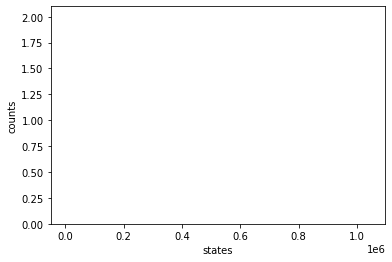

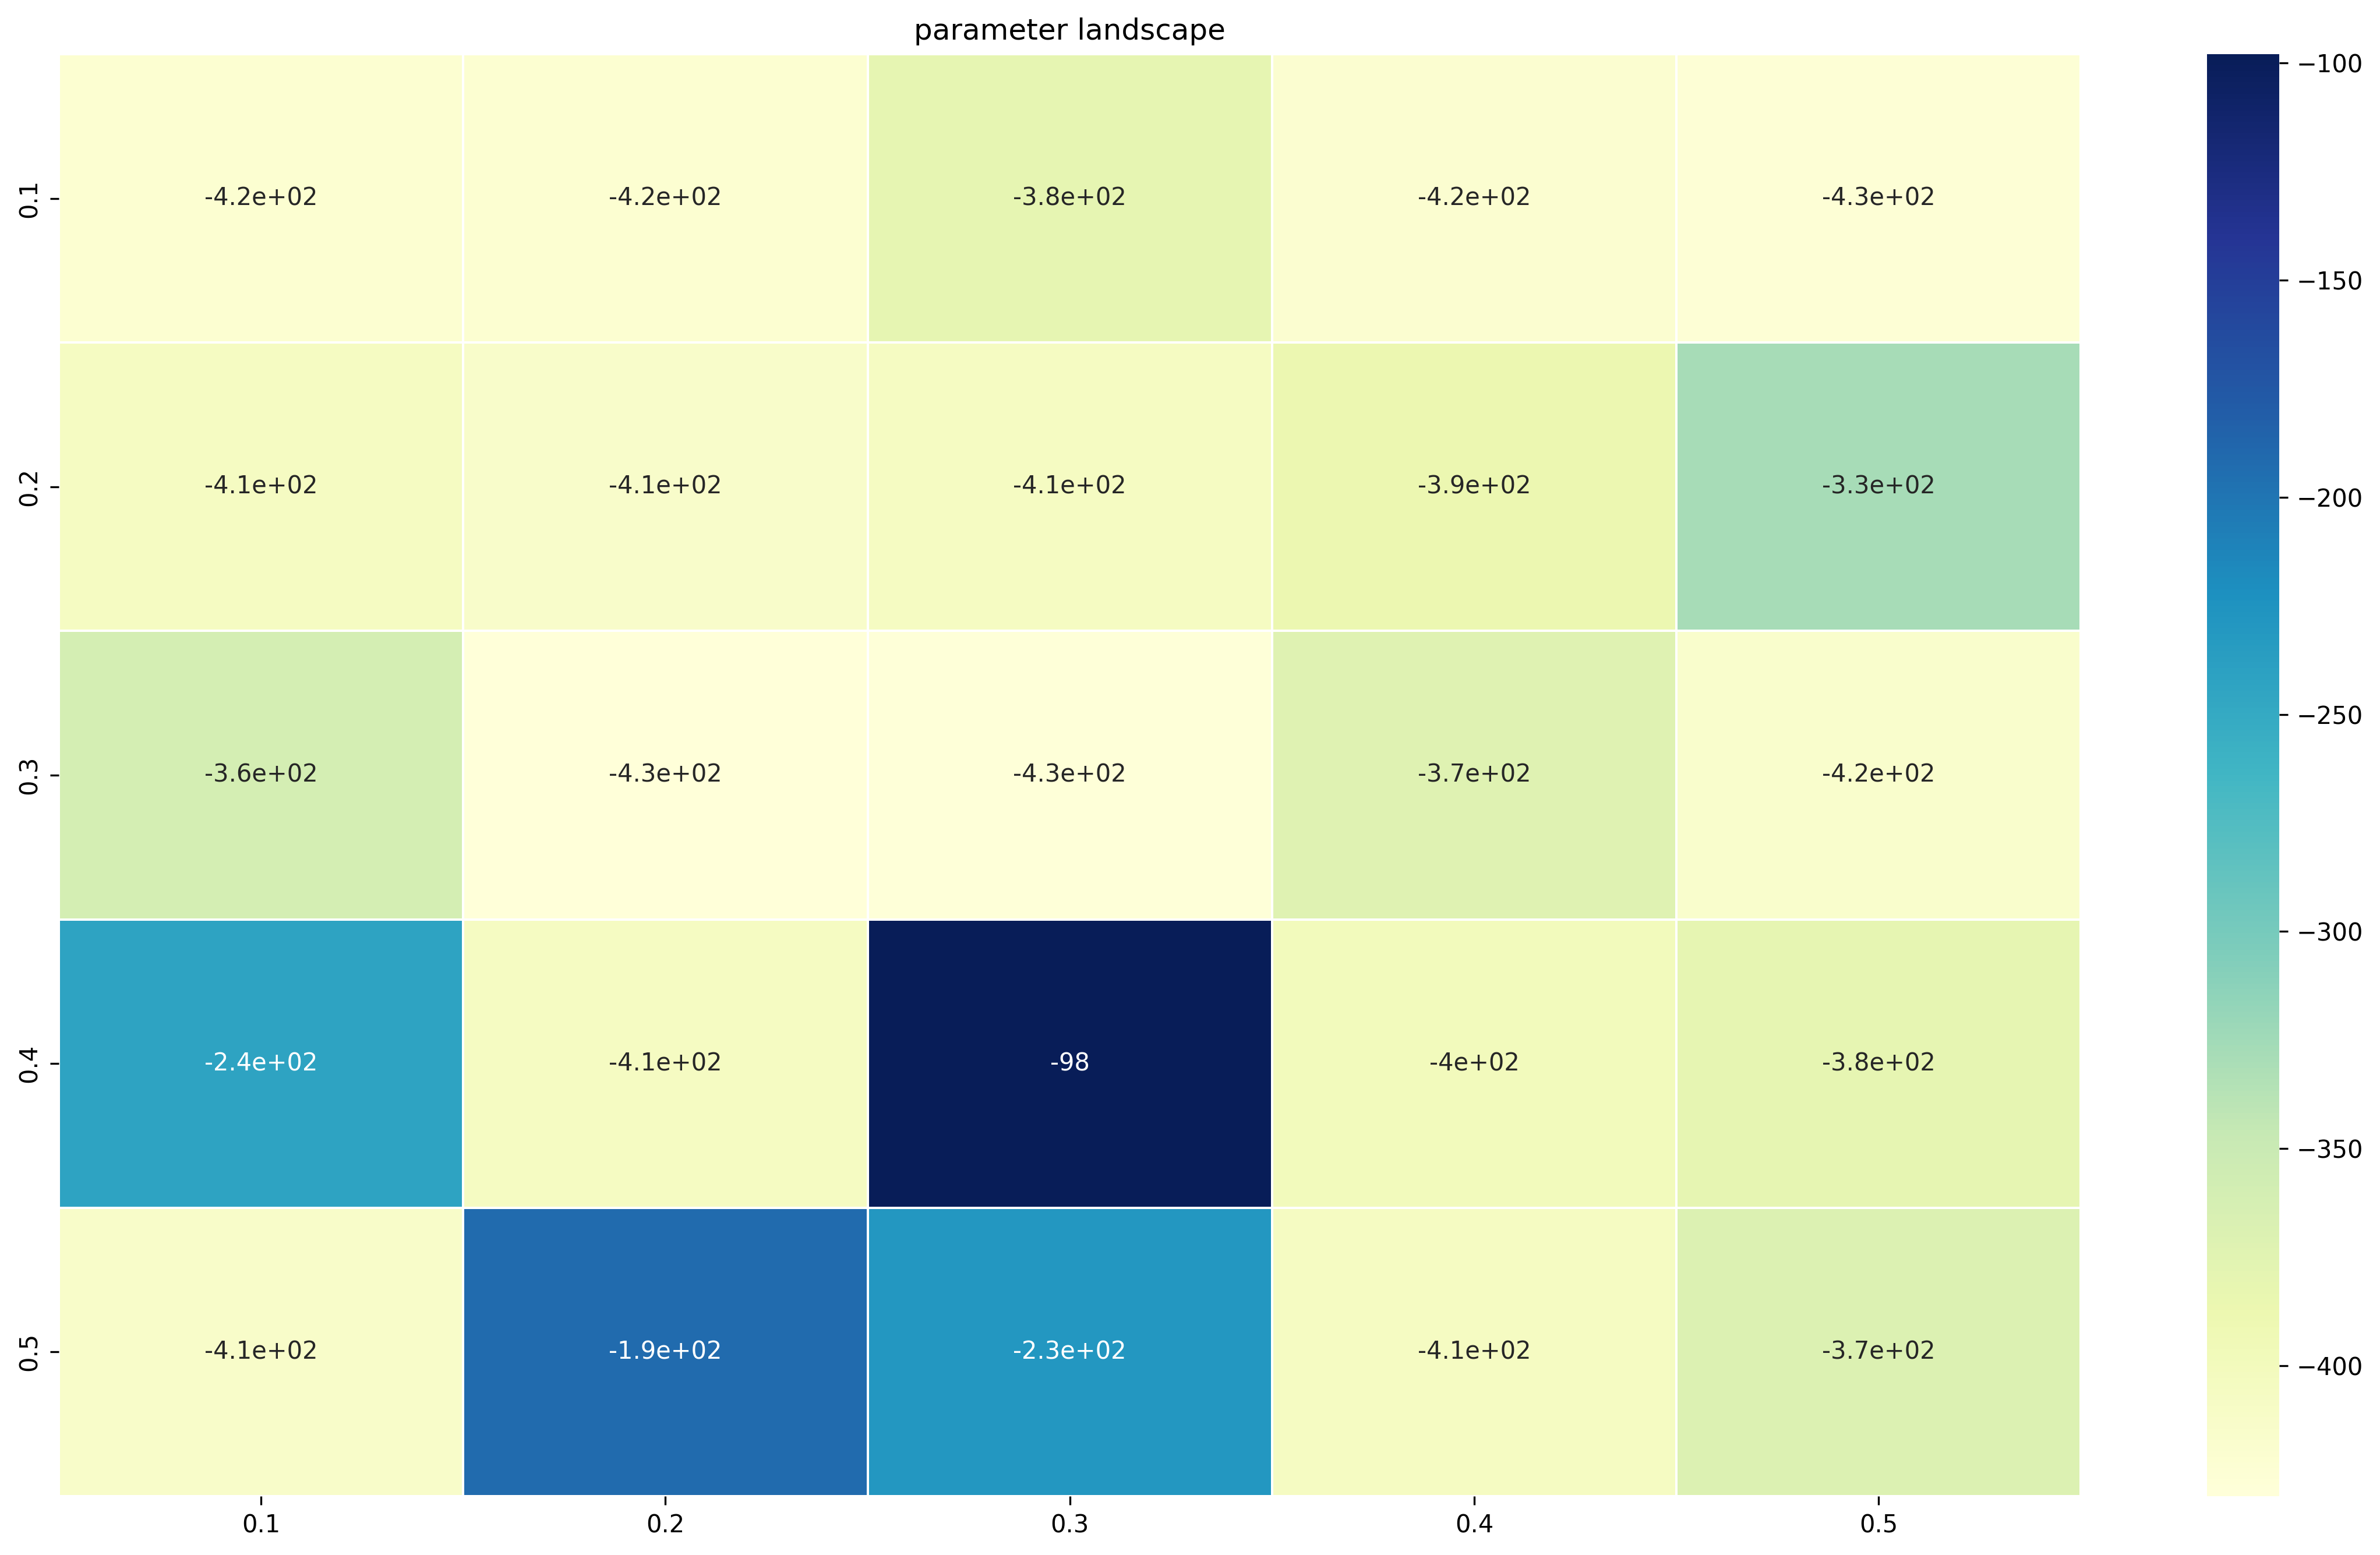

In [56]:
Qubits=len(Mf)
max_val=2**Qubits
param=np.arange(0.1,0.6,0.1,dtype=float)
print(param)
ideal_param1, ideal_param2, lowest_energy=param_optimizer_device(param, param, Mf, 1000,'SV1')
print(ideal_param1, ideal_param2, lowest_energy)

In [61]:
print(ideal_param1, ideal_param2)

0.30000000000000004 0.2


Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
device Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
num reads 100000
simulator cost per  minute : $ 0.075
total execution time:  389 ms
total cost estimated: $ 0.00048625000000000003
{808928: 1, 23688: 1, 953564: 1, 311982: 1, 970418: 1, 70823: 1, 994128: 2, 268915: 1, 77787: 1, 379430: 1, 7269: 1, 502774: 2, 1026396: 2, 607956: 2, 552407: 1, 290355: 1, 473635: 1, 650450: 1, 87910: 2, 759558: 1, 322785: 1, 475328: 1, 104032: 1, 150334: 1, 338068: 1, 972388: 1, 816321: 1, 358774: 1, 218740: 1, 118278: 1, 655322: 1, 41142: 1, 125265: 1, 725679: 1, 807698: 1, 800419: 1, 785546: 1, 763313: 2, 229944: 1, 31488: 1, 1034823: 1, 912604: 1, 873208: 1, 503977: 1, 471353: 1, 414924: 1, 999765: 2, 268092: 1, 165353: 1, 437461: 3, 922530: 1, 574263: 1, 710575: 1, 830015: 1, 795089: 1, 180279: 2, 125150: 1, 249892: 1, 775700: 1, 872706: 1, 221112: 1, 760676: 1, 978663: 1, 975855: 1, 5

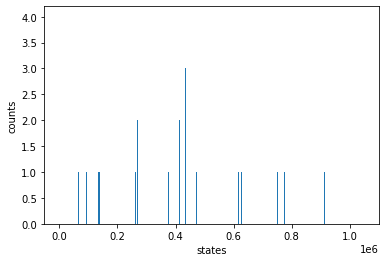

In [63]:
solution, quantity, energy, index=quantum_device_sampler([ideal_param1], [ideal_param2], Mf, 100000,'SV1')

In [64]:
cond1_fail=0
cond2_fail=0
count=50
good_solution=[]
good_value=[]
good_weight=[]
good_energy=[]

temp_sol=[]
temp_energy=[]
for i in (index):   
    temp=[]
    #print(solution[i], energy[i], quantity[i])
    for j in range(N+wc):
        if solution[i][j]=='1':
            temp.append(int(j))
    temp_sol.append(temp)
    temp_energy.append(energy[i])

for trial in range(count):    
    
    item_list=[]
    Vt=0
    Wt=0
    for i in temp_sol[trial]:
        if i <N:
            Vt+=value[i]
            Wt+=weight[i]
            #print(i, value[i], weight[i])
            item_list.append(i)
    #print('Items added to Knapsack',item_list)
    #print('Total value:',Vt)
    #print('Total weight:',Wt)

    check_y=0
    weight_list=[]
    for i in temp_sol[trial]:
        if i>=N:
            check_y+=1
            weight_list.append(i-N+1)
    #print('Condition 1 - Only one weight should be selected.')
    if check_y>1:
        #print('FAIL: One weight condition not met', weight_list)
        cond1_fail+=1

    else:
        #print('OK: condition met', weight_list)
        #print('Condition 2 - Total weight should be equal to weight selected')
        if len(weight_list)>0:
            if Wt==weight_list[0]:
                #print('OK: Condition met', Wt)
                good_solution.append(item_list)
                good_value.append(Vt)
                good_weight.append(Wt)
                good_energy.append(temp_energy[trial])
            
            else:
                #print('FAIL: Weight match condition not met', Wt, weight_list[0])
                cond2_fail+=1

good_count=len(good_value)
if good_count==0:
    print('-------FAIL!------------')
    print('No good values found')
    print('Condition 1: One weight condition failed',(cond1_fail/count)*100, '%')
    print('Condition 2: Weight match condition failed',(cond2_fail/count)*100, '%')
else:
    print('-------Success!------------')
    for i in range(good_count):
        
        #print(i, good_solution[i], 'Value', good_value[i],'Wt', good_weight[i])
        print(i, good_solution[i], 'Value', good_value[i],'Wt', good_weight[i], 'energy', good_energy[i])



-------Success!------------
0 [2, 4, 7] Value 32 Wt 10 energy -432.0
1 [0, 1, 2, 4] Value 22 Wt 10 energy -422.0
2 [0, 2, 5] Value 20 Wt 9 energy -420.0
3 [9] Value 20 Wt 9 energy -420.0
4 [0, 1, 2, 3] Value 20 Wt 10 energy -420.0
5 [0, 1, 5] Value 18 Wt 10 energy -418.0
6 [8] Value 18 Wt 8 energy -418.0
7 [0, 1, 4] Value 16 Wt 8 energy -416.0
8 [0, 1, 3] Value 14 Wt 8 energy -414.0
9 [0, 5] Value 14 Wt 7 energy -414.0
10 [0, 1, 2] Value 12 Wt 7 energy -412.0
11 [1, 2] Value 10 Wt 5 energy -410.0
12 [0, 2] Value 8 Wt 4 energy -408.0


## Run on Rigetti Aspen-M-2

In [ ]:
# Adjust code to use Aspen M-3 as of April 2023

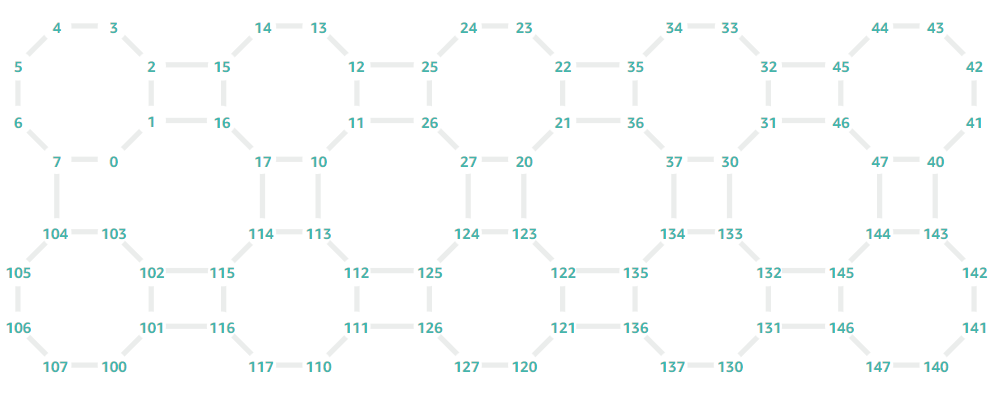

In [69]:
device=set_device('Aspen-M-2')
estimate_cost(device,num_shots=100000)

Device('name': Aspen-M-2, 'arn': arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-2)
device cost per  shot : $ 0.00035
total cost for 100000 shots is $35.30


In [71]:
ideal_param1=0.3
ideal_param2=0.2

Device('name': Aspen-M-2, 'arn': arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-2)
device Device('name': Aspen-M-2, 'arn': arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-2)
num reads 100000
device cost per  shot : $ 0.00035
total cost for 100000 shots is $35.30
{24580: 1, 80677: 2, 866436: 2, 408999: 4, 600610: 1, 736212: 1, 28527: 1, 800031: 2, 32614: 1, 1048311: 1, 737204: 1, 997509: 3, 153786: 1, 340269: 1, 272570: 2, 163212: 1, 801549: 2, 204097: 2, 13184: 1, 80160: 8, 994981: 1, 163216: 1, 657676: 1, 462505: 1, 15123: 2, 278001: 2, 104577: 1, 862803: 1, 130215: 1, 276772: 8, 811041: 1, 204672: 2, 386578: 1, 867841: 1, 408088: 1, 146693: 7, 276739: 4, 245686: 1, 424421: 2, 146522: 3, 147231: 3, 767262: 1, 860228: 1, 81667: 2, 289228: 1, 670154: 2, 417051: 1, 31004: 2, 801793: 2, 834957: 2, 293928: 1, 358789: 2, 605587: 2, 765072: 1, 474160: 4, 980996: 1, 359940: 1, 798039: 2, 470962: 2, 833623: 1, 932487: 3, 866741: 2, 290571: 1, 999261: 1, 408718: 3, 601274: 1, 604597:

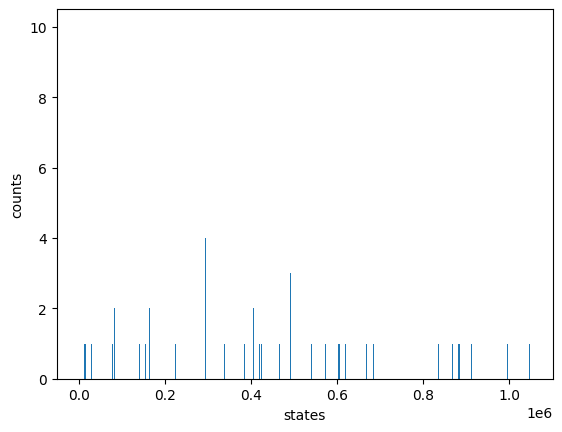

In [74]:
solution, quantity, energy, index=quantum_device_sampler([ideal_param1], [ideal_param2], Mf, 100000,'Aspen-M-2')

In [84]:

#count=len(solution)
count=len(solution)
cond1_fail=0
cond2_fail=0
good_solution=[]
good_value=[]
good_weight=[]
good_energy=[]

temp_sol=[]
temp_energy=[]
for i in (index):   
    temp=[]
    #print(solution[i], energy[i], quantity[i])
    for j in range(N+wc):
        if solution[i][j]=='1':
            temp.append(int(j))
    temp_sol.append(temp)
    temp_energy.append(energy[i])
nn=0
for trial in range(count): 
    nn+=1
    if nn==100:
        break
    item_list=[]
    Vt=0
    Wt=0
    for i in temp_sol[trial]:
        if i <N:
            Vt+=value[i]
            Wt+=weight[i]
            print(i, value[i], weight[i])
            item_list.append(i)
    print('Items added to Knapsack',item_list)
    print('Total value:',Vt)
    print('Total weight:',Wt)

    check_y=0
    weight_list=[]
    for i in temp_sol[trial]:
        if i>=N:
            check_y+=1
            weight_list.append(i-N+1)
    print('Condition 1 - Only one weight should be selected.')
    if check_y>1:
        print('FAIL: One weight condition not met', weight_list)
        cond1_fail+=1

    elif check_y==1:
        print('OK: condition met', weight_list)
        print('Condition 2 - Total weight should be equal to weight selected')
        if Wt==weight_list[0]:
            print('OK: Condition met', Wt)
            good_solution.append(item_list)
            good_value.append(Vt)
            good_weight.append(Wt)
            good_energy.append(temp_energy[trial])
            
        else:
            print('FAIL: Weight match condition not met', Wt, weight_list[0])
            cond2_fail+=1
    else:
        print('FAIL: No weight found')

good_count=len(good_value)
if good_count==0:
    print('-------FAIL!------------')
    print('No good values found')
    print('Condition 1: One weight condition failed',(cond1_fail/count)*100, '%')
    print('Condition 2: Weight match condition failed',(cond2_fail/count)*100, '%')
else:
    print('-------Success!------------')
    for i in range(good_count):
        
        #print(i, good_solution[i], 'Value', good_value[i],'Wt', good_weight[i])
        print(i, good_solution[i], 'Value', good_value[i],'Wt', good_weight[i], 'energy', good_energy[i])


6 14 6
7 16 5
Items added to Knapsack [6, 7]
Total value: 30
Total weight: 11
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
FAIL: Weight match condition not met 11 10
2 6 2
3 8 3
7 16 5
Items added to Knapsack [2, 3, 7]
Total value: 30
Total weight: 10
Condition 1 - Only one weight should be selected.
OK: condition met [9]
Condition 2 - Total weight should be equal to weight selected
FAIL: Weight match condition not met 10 9
4 10 3
6 14 6
Items added to Knapsack [4, 6]
Total value: 24
Total weight: 9
Condition 1 - Only one weight should be selected.
OK: condition met [10]
Condition 2 - Total weight should be equal to weight selected
FAIL: Weight match condition not met 9 10
6 14 6
7 16 5
Items added to Knapsack [6, 7]
Total value: 30
Total weight: 11
Condition 1 - Only one weight should be selected.
OK: condition met [9]
Condition 2 - Total weight should be equal to weight selected
FAIL: Weight mat

In [ ]:
#we only sampled the first 100 results and found the lowest energy of -422.  